In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
from multiprocess import Pool

In [2]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [3]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

In [4]:
def read_files_v2(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    #print(name)
    culling_factor = od()
    #print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters

def read_tuple_files(tpl):
    if tpl[1]["heat"]:
        return {
            "cool": read_files_v2(tpl[0]),
            "heat": read_files_v2(tpl[1])
        }

def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift    
    return {"S": result, "L": heat["L"], "D": heat["D"]}



In [5]:
%%writefile magic_functions.py

import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True

def calc_hc_tpl(tpl):
    st, T = tpl

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

Overwriting magic_functions.py


In [6]:

def calc_hc(st, T):

    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    E_qr = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
        E_qr += w * e * e * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    avgE_qr = E_qr / Z;
    # T, C, average E, BinderCumulant
    return T, float( (avgE_sq - avgE * avgE) / (T * T) ), float( avgE ), float(1 - (avgE_qr / (3 * avgE_sq * avgE_sq)))

In [7]:
L_list = [8, 12, 16, 20, 24, 32, 48, 64, 96]
[l * l for l in L_list]

[64, 144, 256, 400, 576, 1024, 2304, 4096, 9216]

In [8]:
from magic_functions import calc_hc_tpl

not found D1.8 L16
not found D1.8 L20
not found D1.8 L24


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


found D1.8 L32



not found D1.8 L48
not found D1.8 L64
not found D1.8 L96



found D1.87 L16



found D1.87 L20



found D1.87 L24



found D1.87 L32


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


found D1.87 L48


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


found D1.87 L64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


not found D1.87 L96



not found D1.875 L16
not found D1.875 L20
not found D1.875 L24
found D1.875 L32


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


not found D1.875 L48
not found D1.875 L64
not found D1.875 L96



found D1.9 L16



found D1.9 L20



found D1.9 L24



found D1.9 L32



not found D1.9 L48
found D1.9 L64



not found D1.9 L96



found D1.92 L16



found D1.92 L20



found D1.92 L24



found D1.92 L32



not found D1.92 L48
found D1.92 L64



found D1.92 L96


not found D1.9375 L16
not found D1.9375 L20
not found D1.9375 L24
found D1.9375 L32



not found D1.9375 L48
not found D1.9375 L64
not found D1.9375 L96



found D1.95 L16



found D1.95 L20



found D1.95 L24



not found D1.95 L32
not found D1.95 L48
found D1.95 L64



not found D1.95 L96



found D1.96 L16



found D1.96 L20



found D1.96 L24



found D1.96 L32



found D1.96 L48



found D1.96 L64



found D1.96 L96


found D1.962 L16



found D1.962 L20



found D1.962 L24



found D1.962 L32



not found D1.962 L48
found D1.962 L64



not found D1.962 L96



found D1.963 L16



found D1.963 L20



found D1.963 L24



found D1.963 L32



found D1.963 L48



not found D1.963 L64
not found D1.963 L96



found D1.964 L16



found D1.964 L20



found D1.964 L24



found D1.964 L32



found D1.964 L48



found D1.964 L64



not found D1.964 L96



found D1.965 L16



found D1.965 L20



found D1.965 L24



found D1.965 L32



not found D1.965 L48
not found D1.965 L64
not found D1.965 L96



found D1.966 L16



found D1.966 L20



found D1.966 L24



found D1.966 L32



not found D1.966 L48
not found D1.966 L64
not found D1.966 L96



found D1.967 L16



found D1.967 L20



found D1.967 L24



found D1.967 L32



found D1.967 L48



not found D1.967 L64
not found D1.967 L96



found D1.968 L16



found D1.968 L20



found D1.968 L24



found D1.968 L32



found D1.968 L48



not found D1.968 L64
not found D1.968 L96



not found D1.96875 L16
not found D1.96875 L20
not found D1.96875 L24
found D1.96875 L32



not found D1.96875 L48
not found D1.96875 L64
not found D1.96875 L96



found D1.969 L16



found D1.969 L20



found D1.969 L24



found D1.969 L32



not found D1.969 L48
found D1.969 L64



not found D1.969 L96



not found D1.97 L16
not found D1.97 L20
not found D1.97 L24
found D1.97 L32



not found D1.97 L48
not found D1.97 L64
not found D1.97 L96



found D1.99 L16



found D1.99 L20



found D1.99 L24



found D1.99 L32



not found D1.99 L48
found D1.99 L64



not found D1.99 L96



not found D1.992 L16
not found D1.992 L20
not found D1.992 L24
found D1.992 L32



not found D1.992 L48
not found D1.992 L64
not found D1.992 L96



not found D0.01 L16
not found D0.01 L20
not found D0.01 L24
not found D0.01 L32
not found D0.01 L48
not found D0.01 L64
not found D0.01 L96




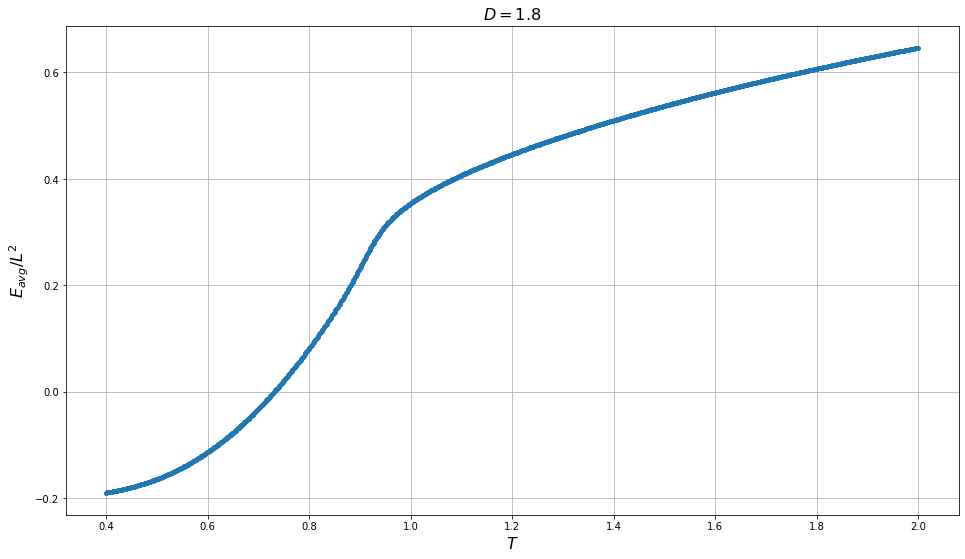

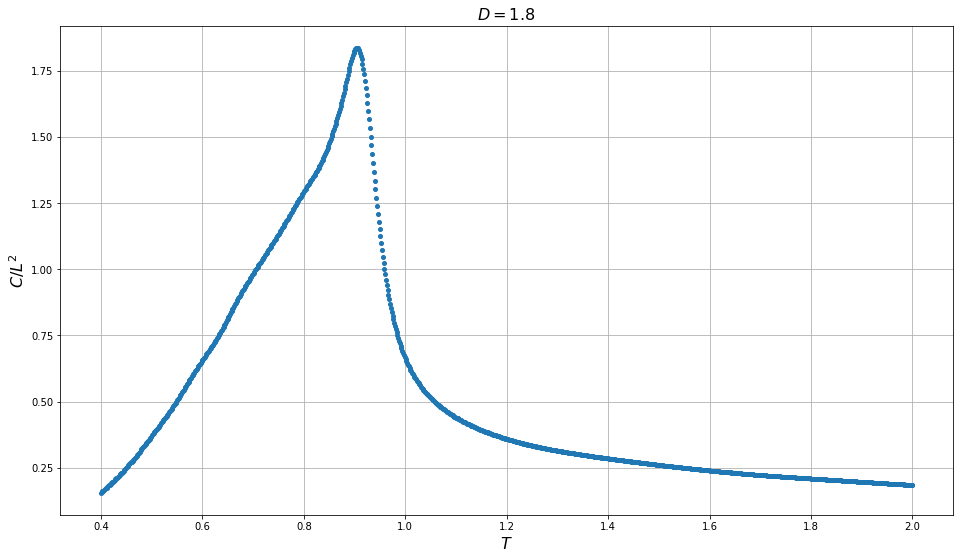

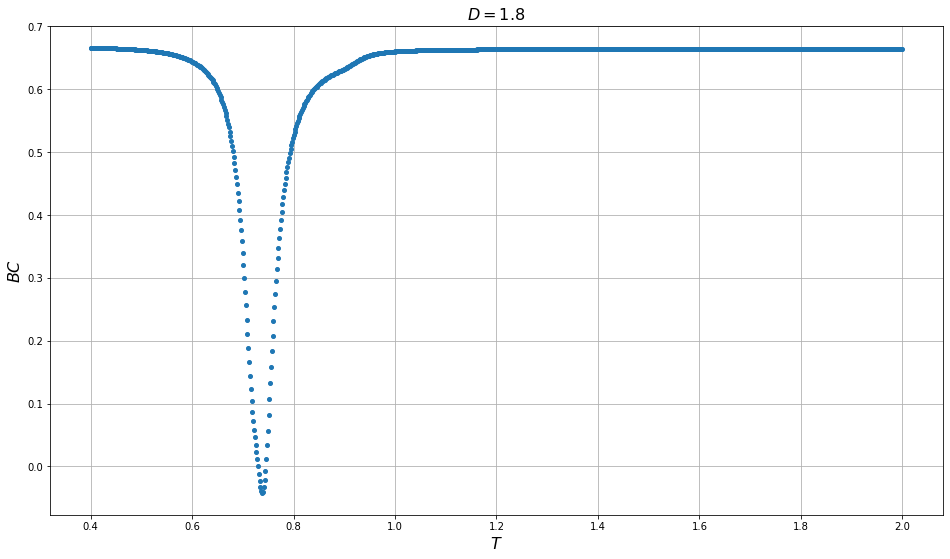

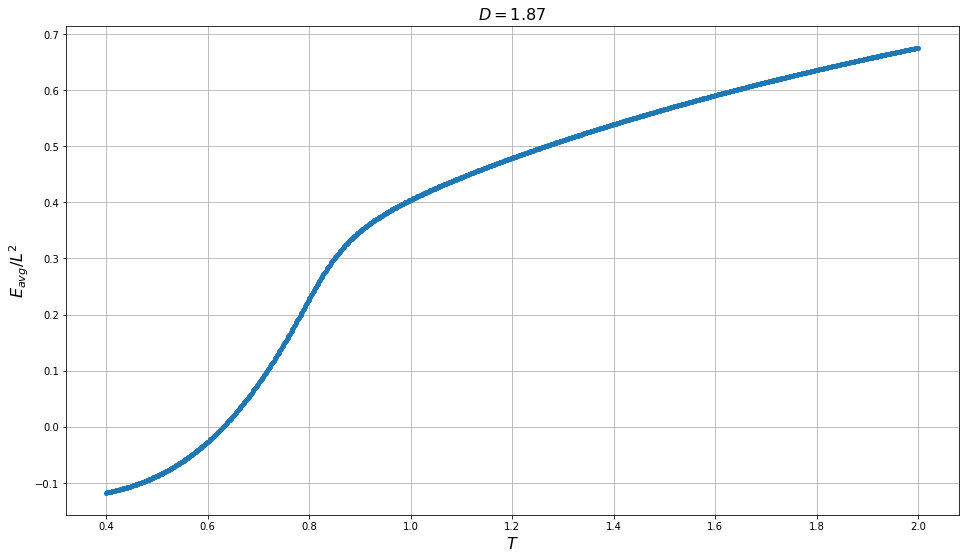

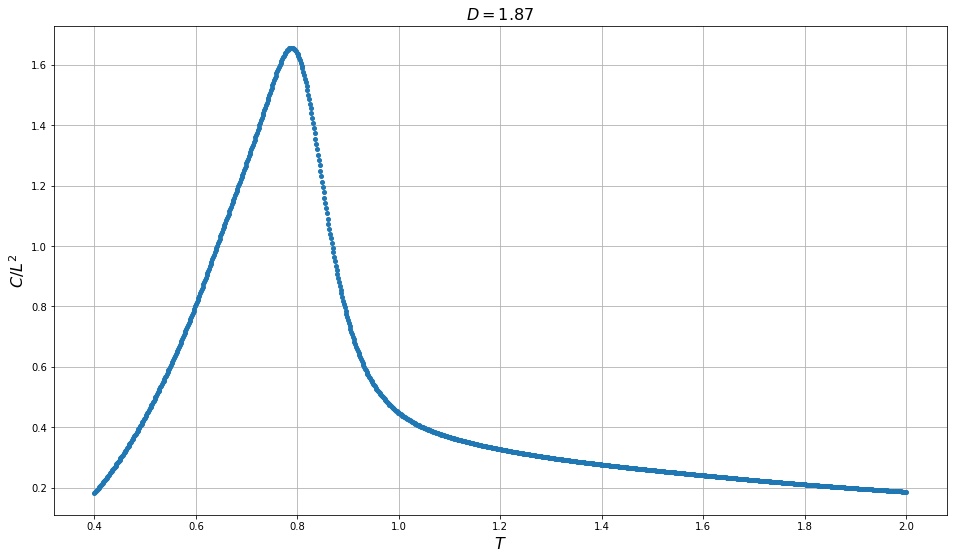

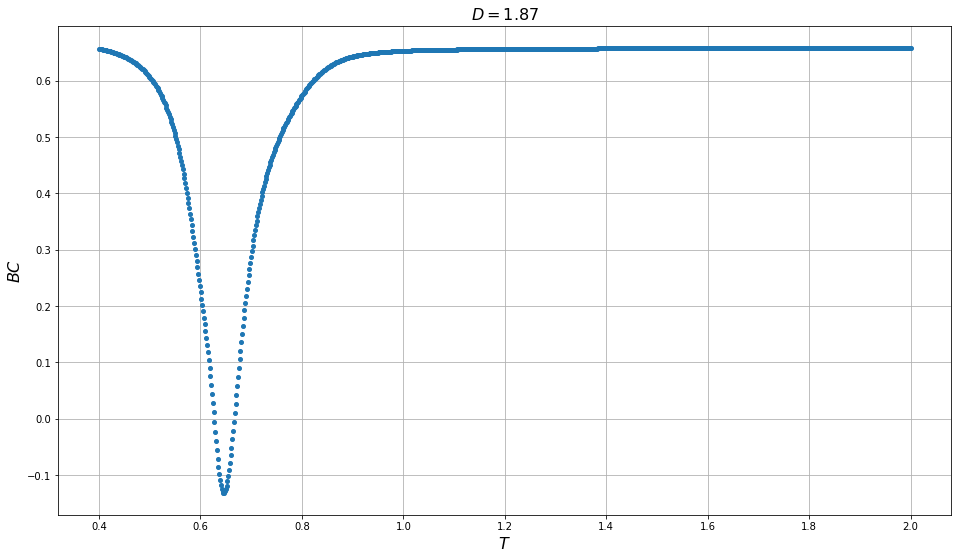

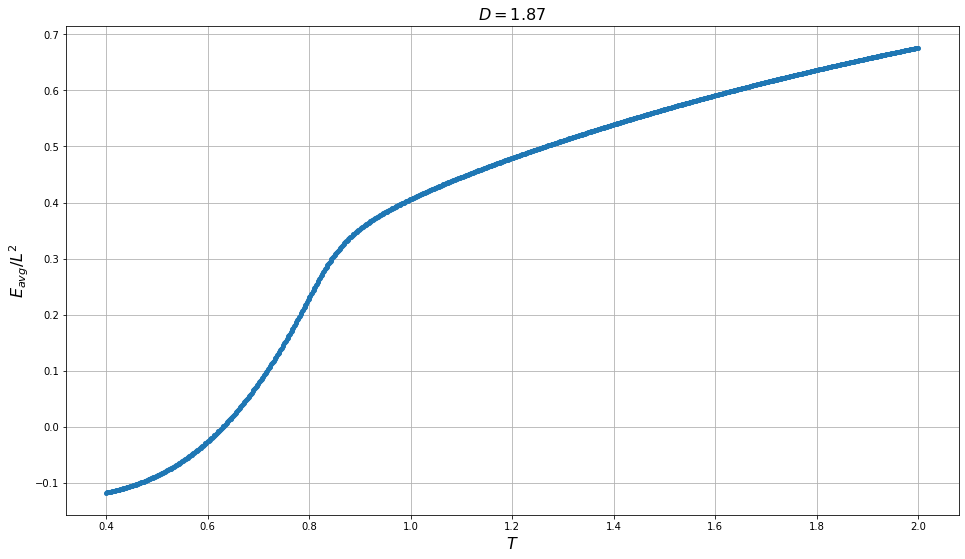

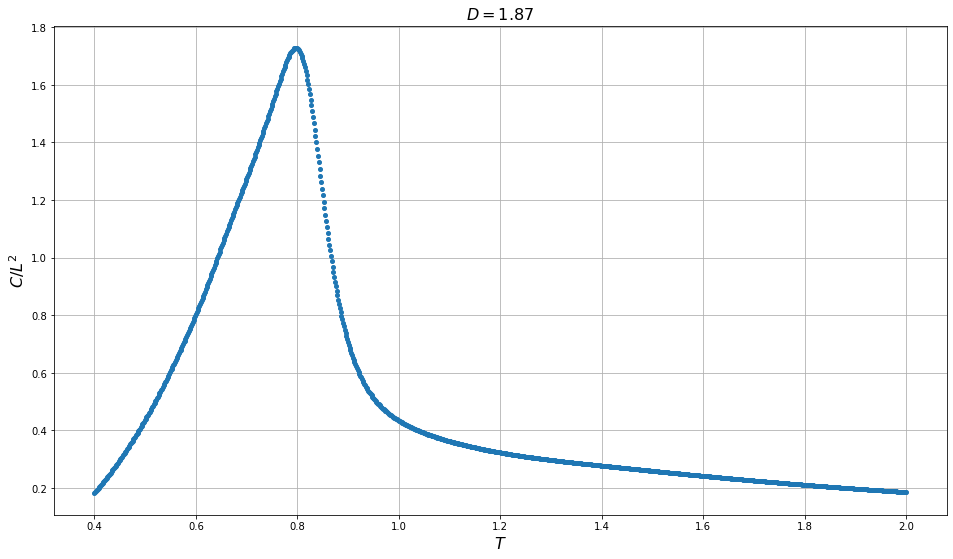

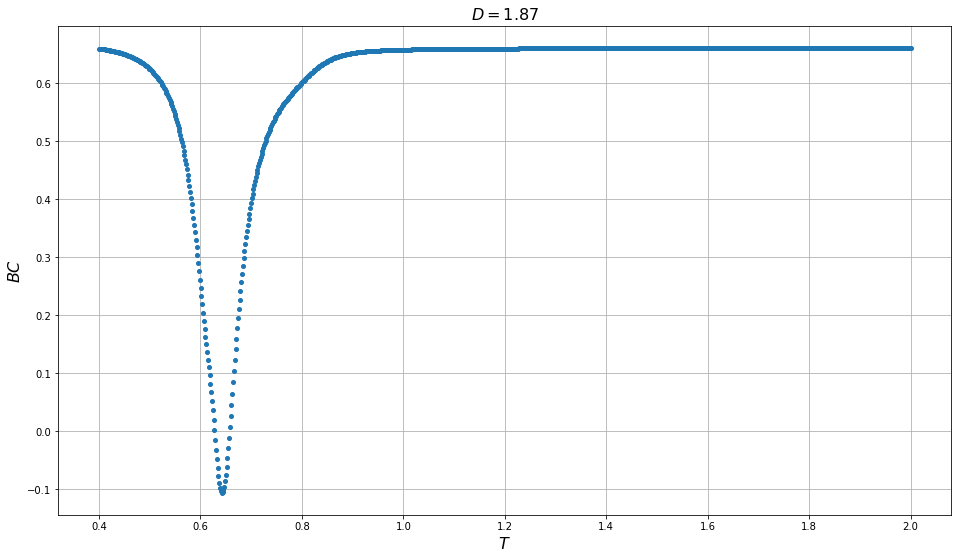

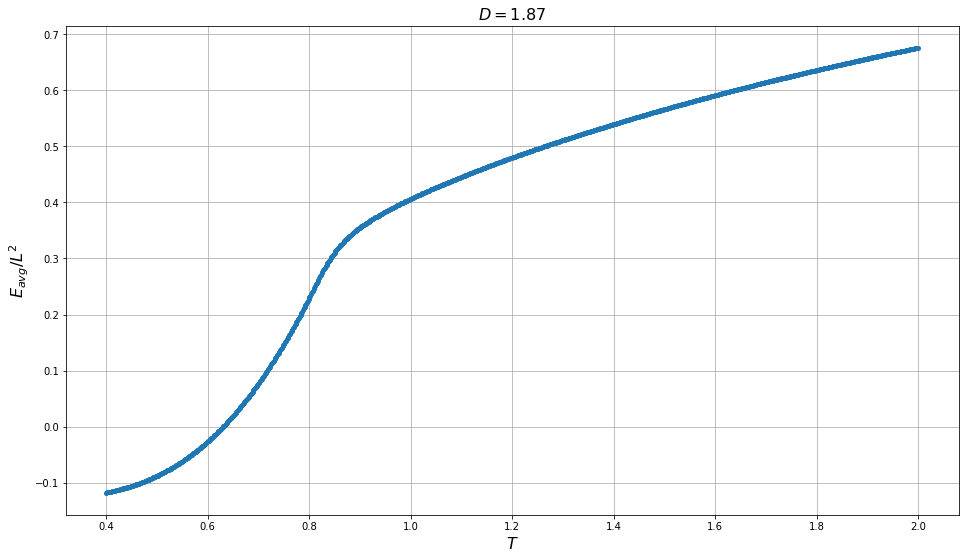

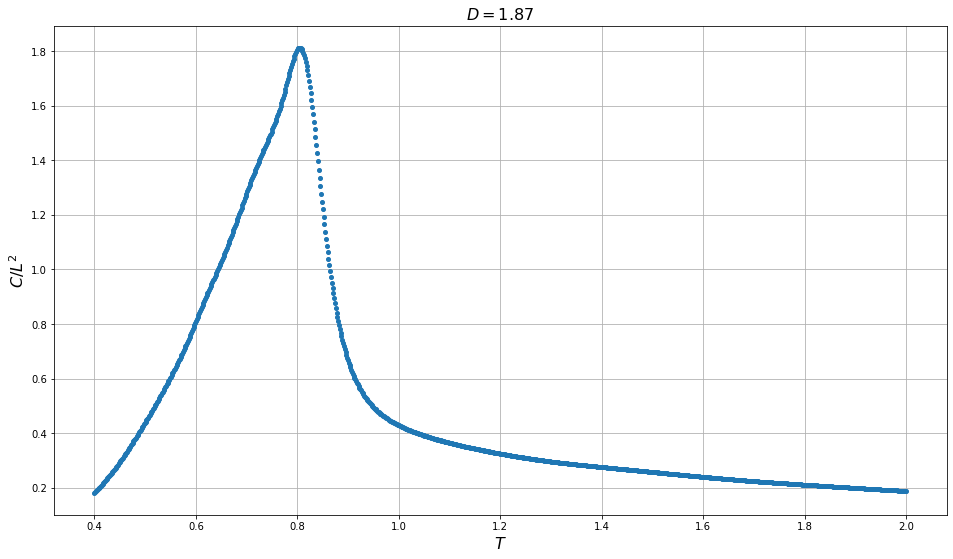

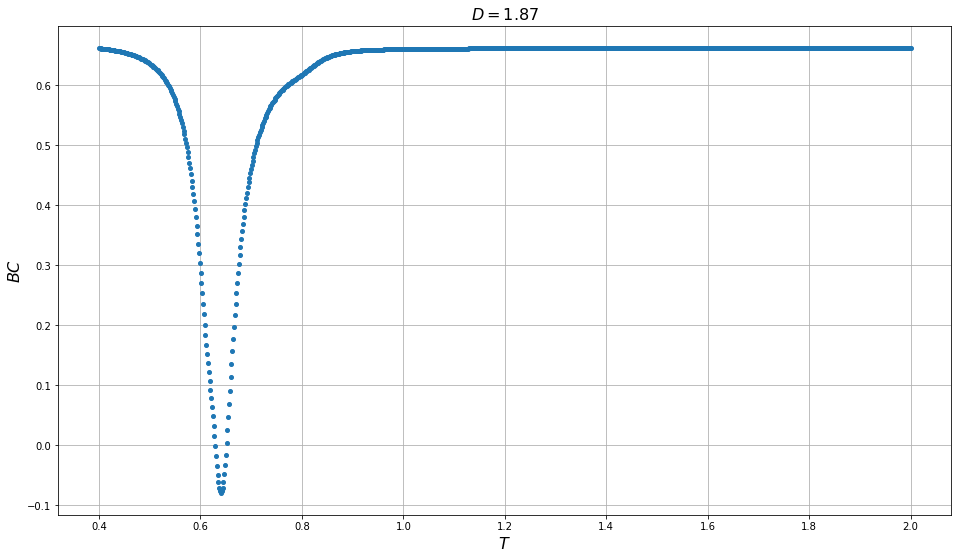

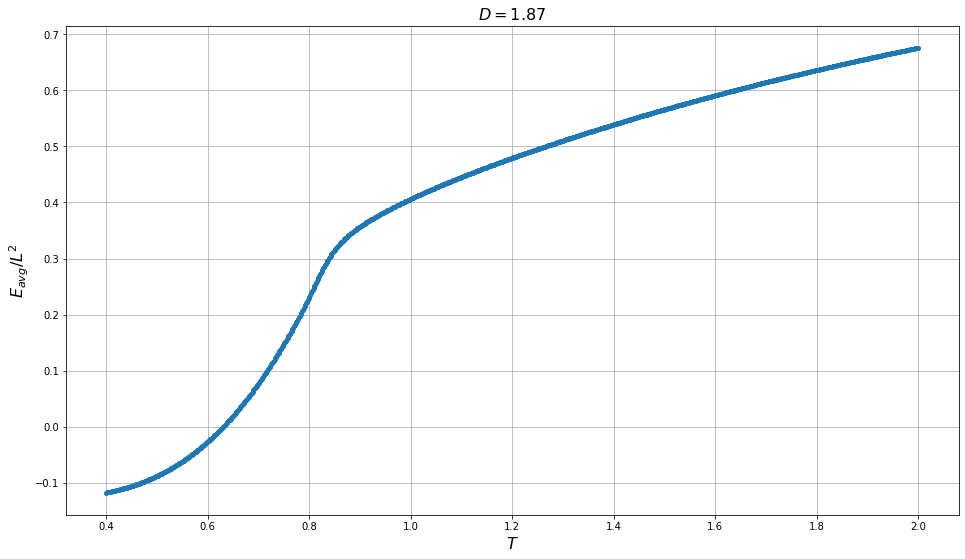

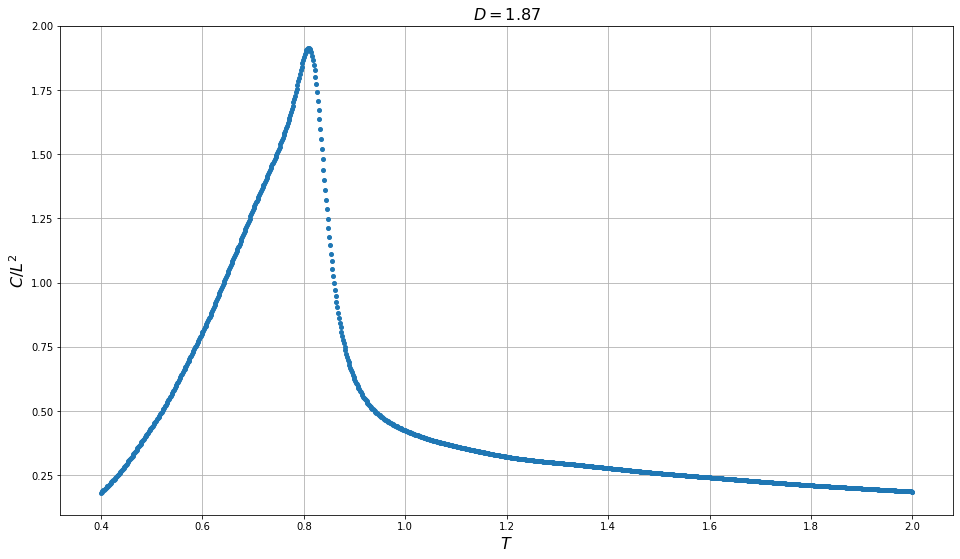

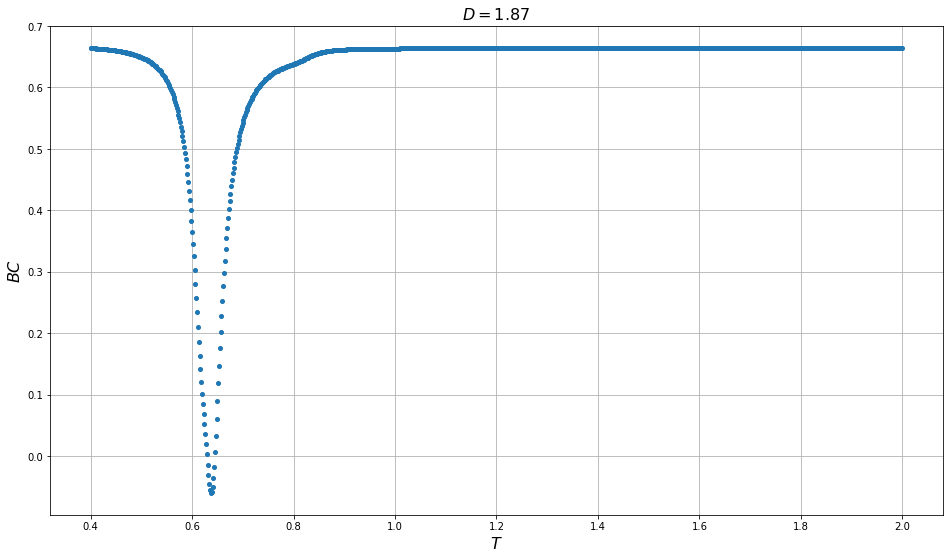

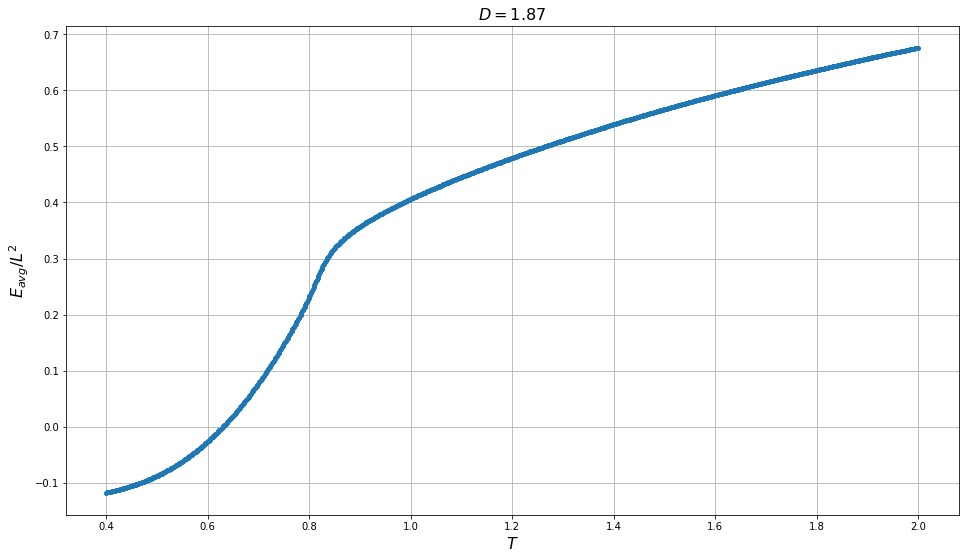

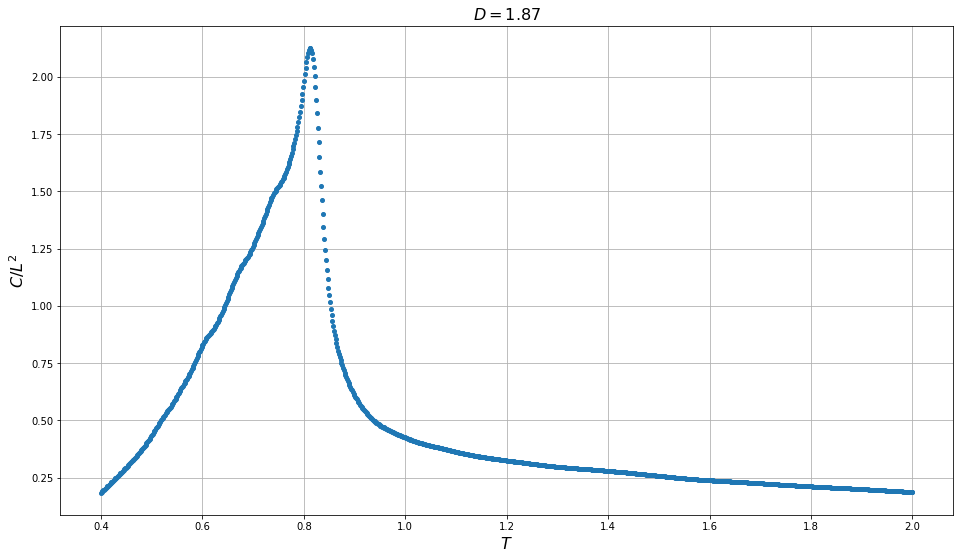

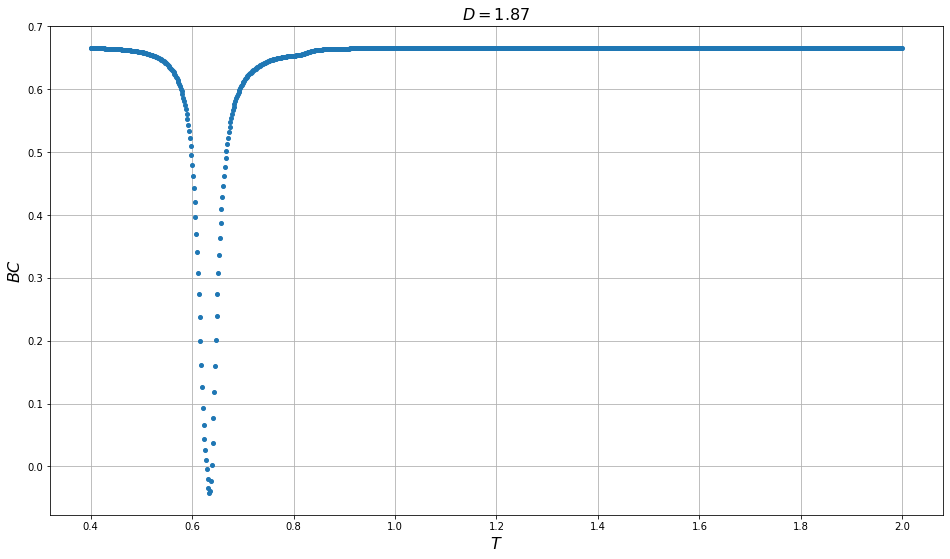

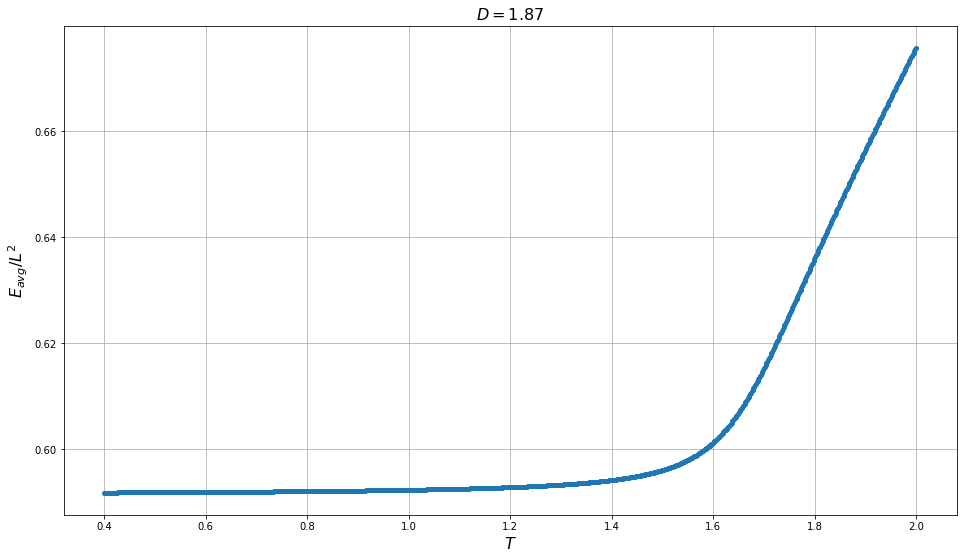

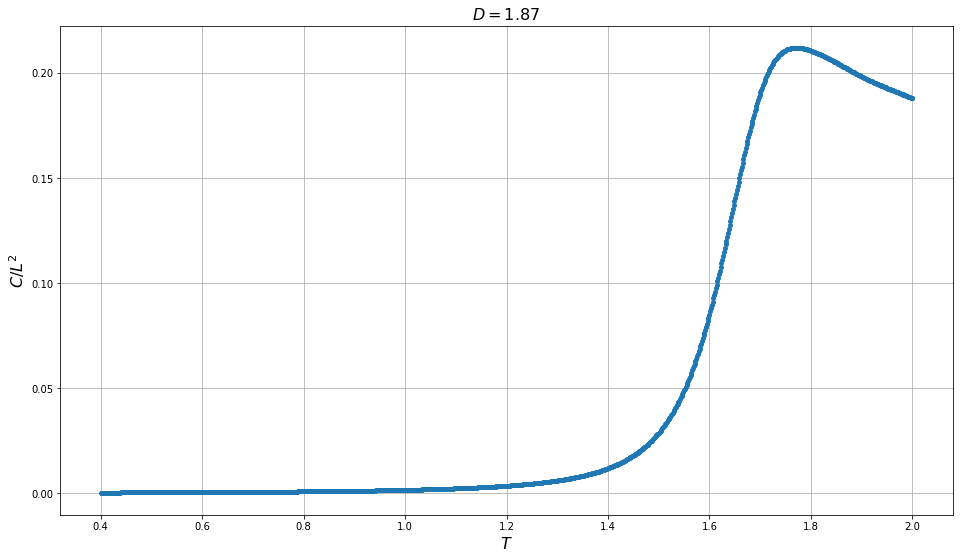

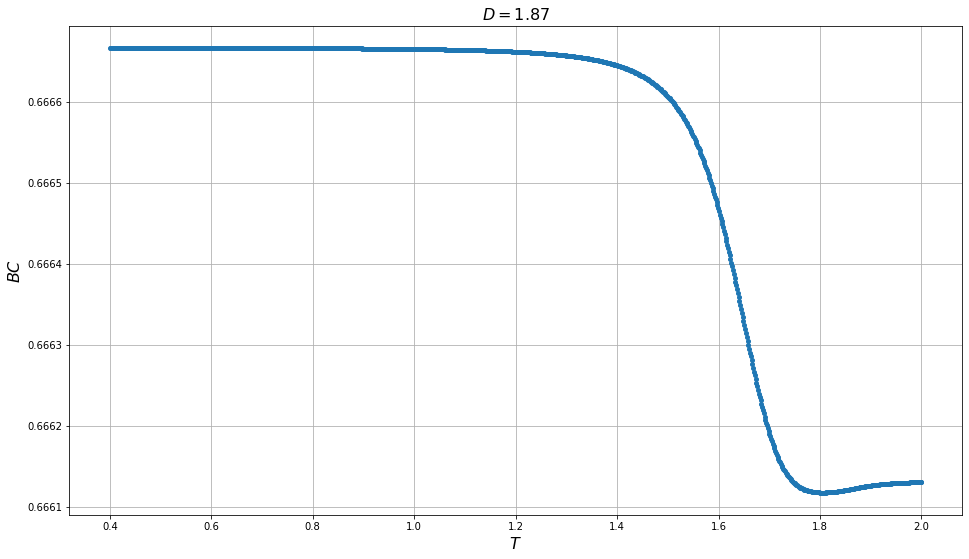

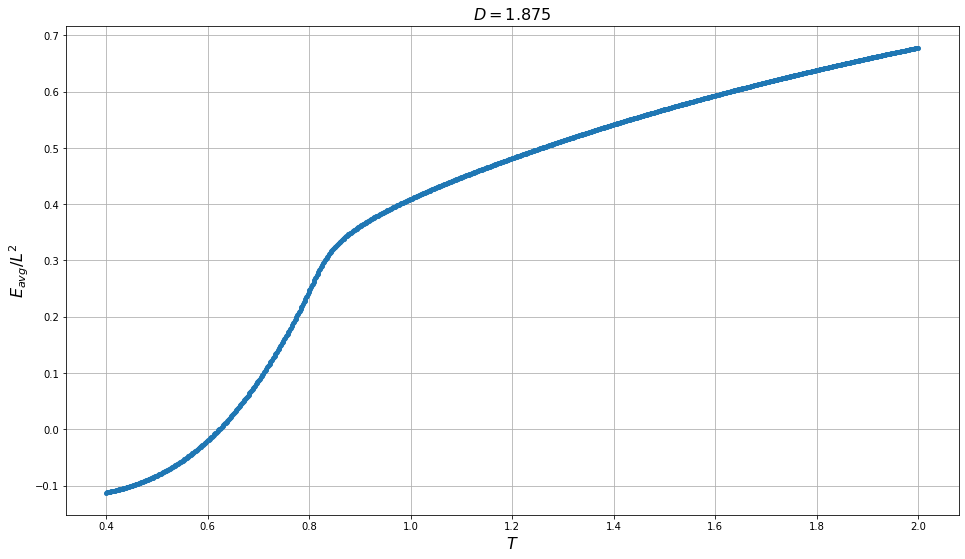

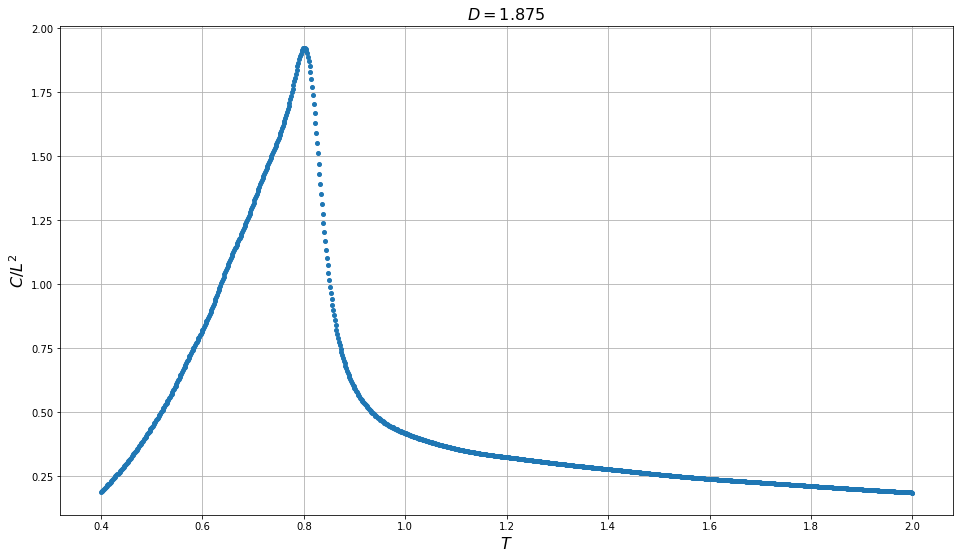

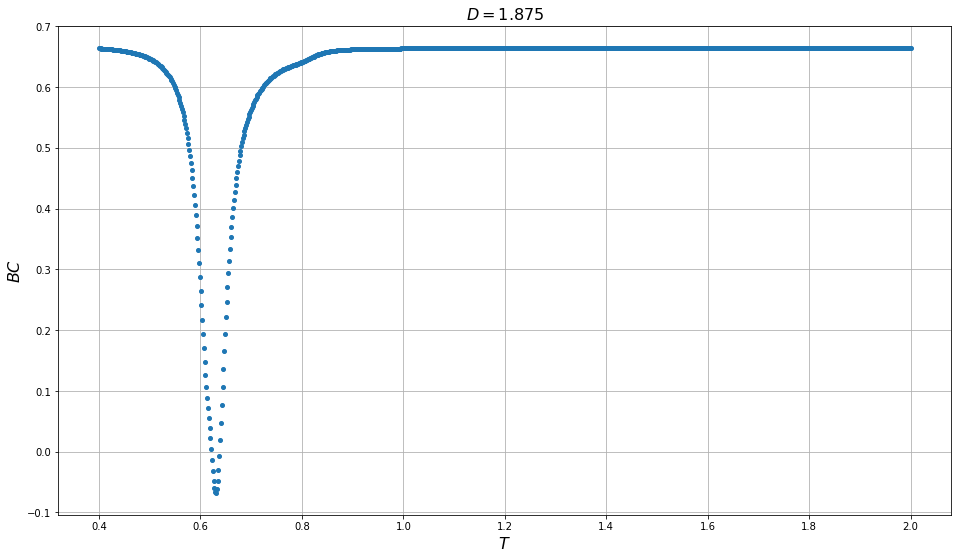

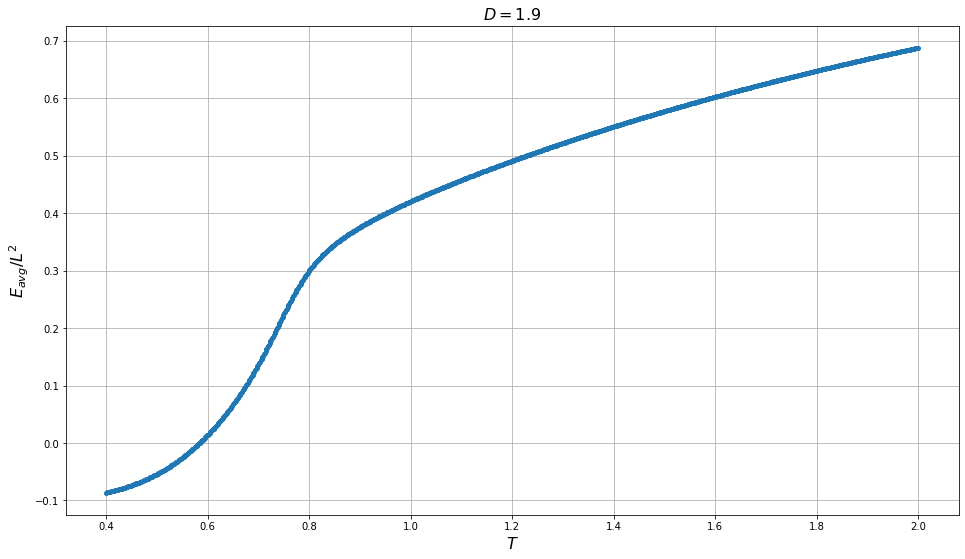

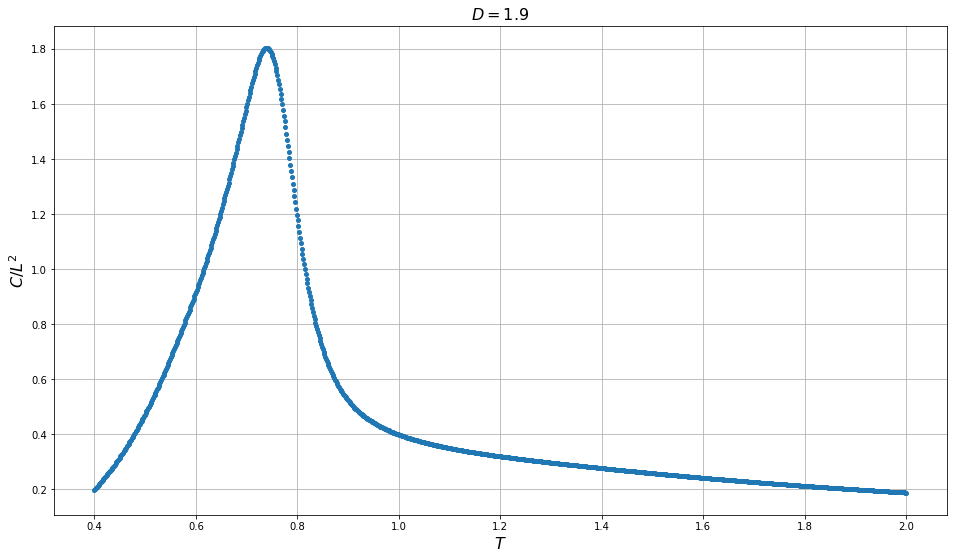

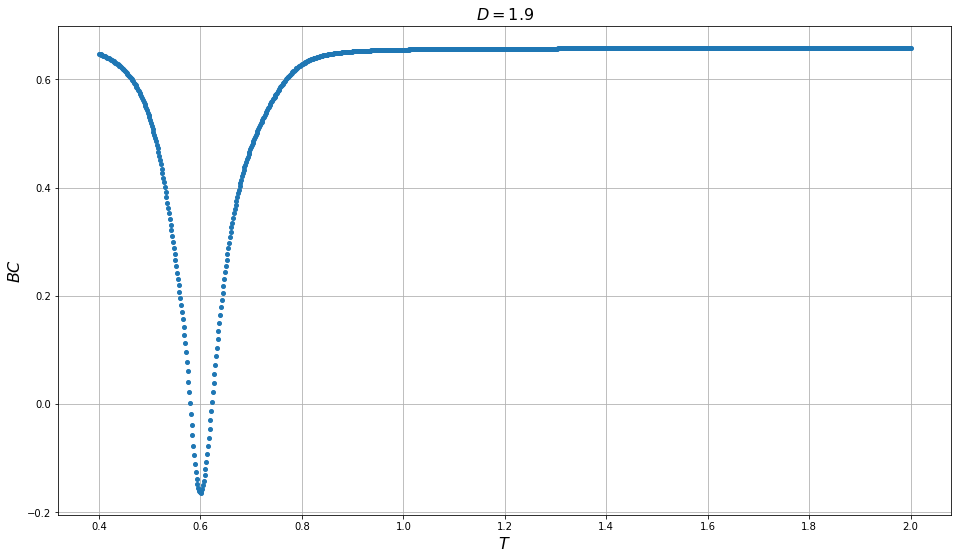

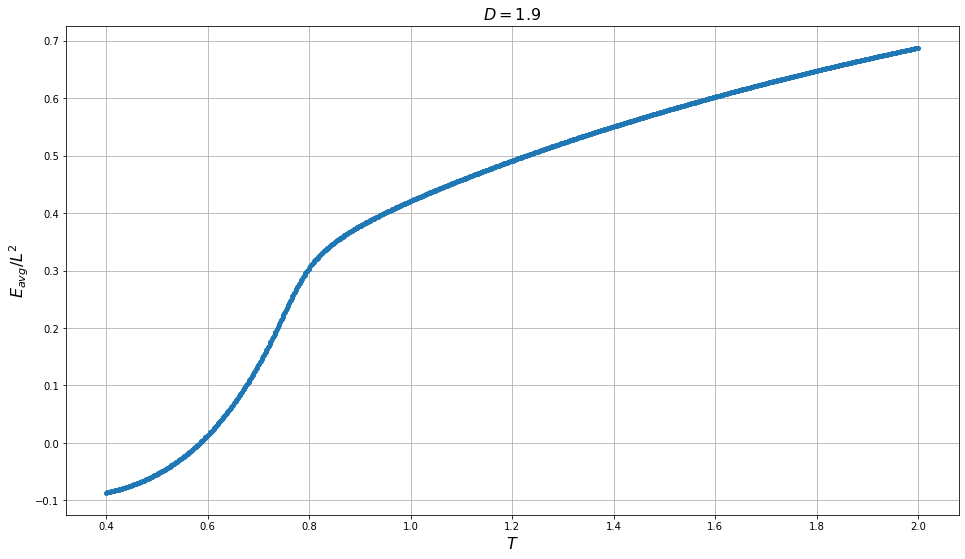

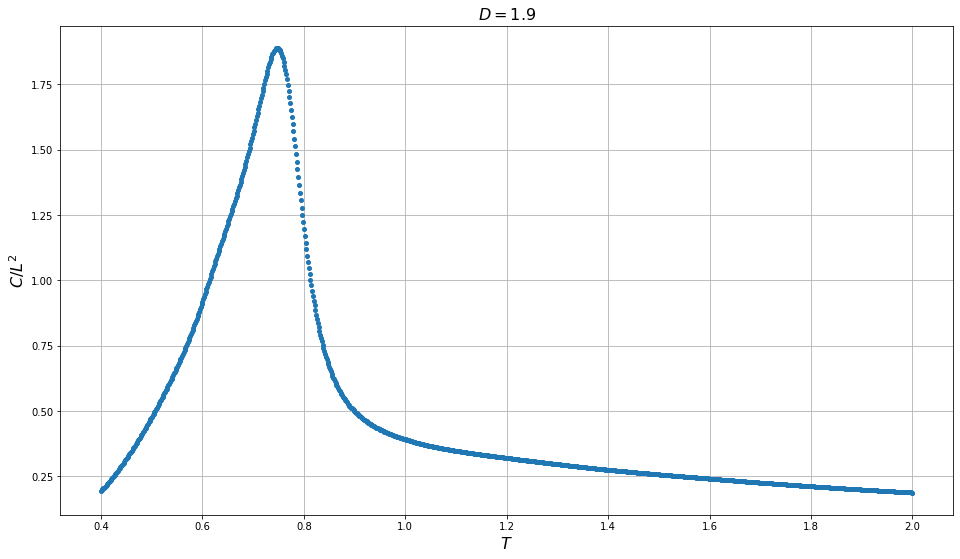

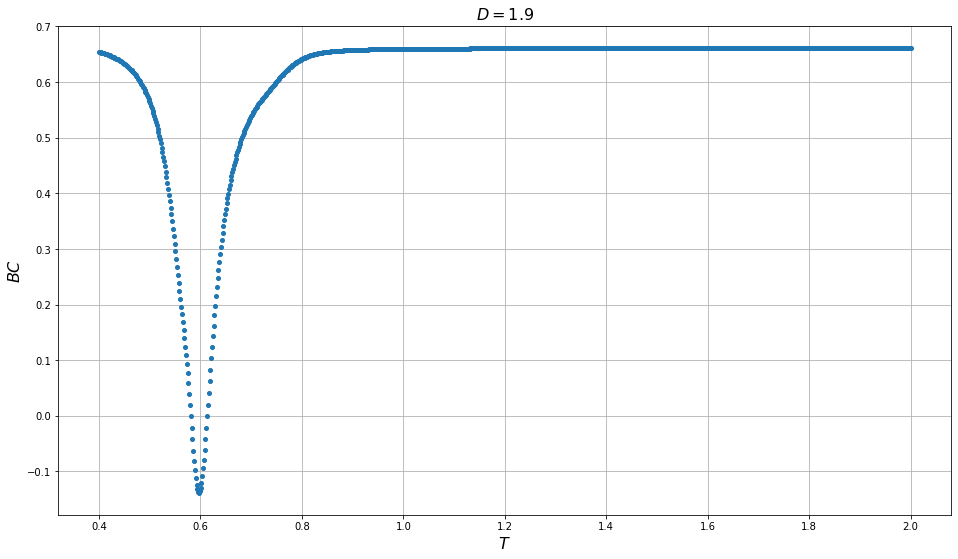

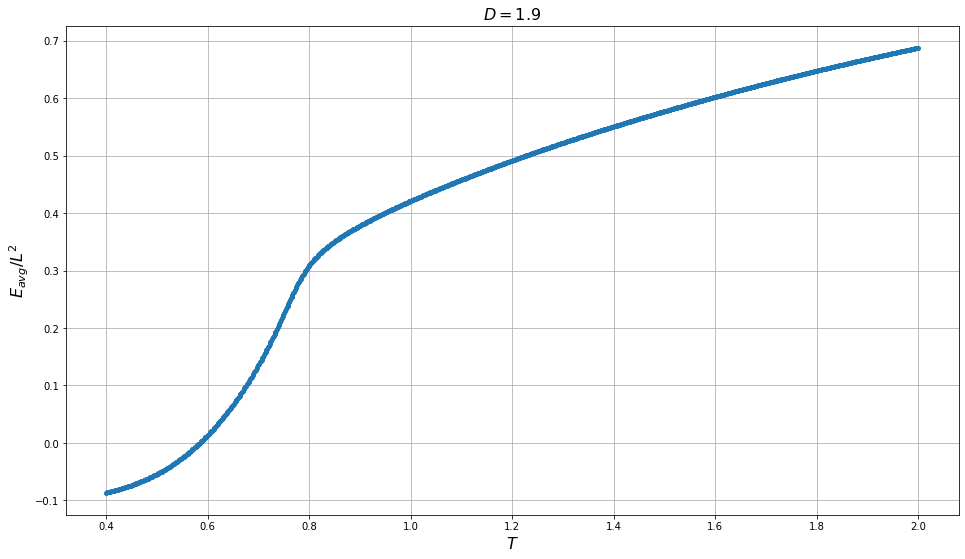

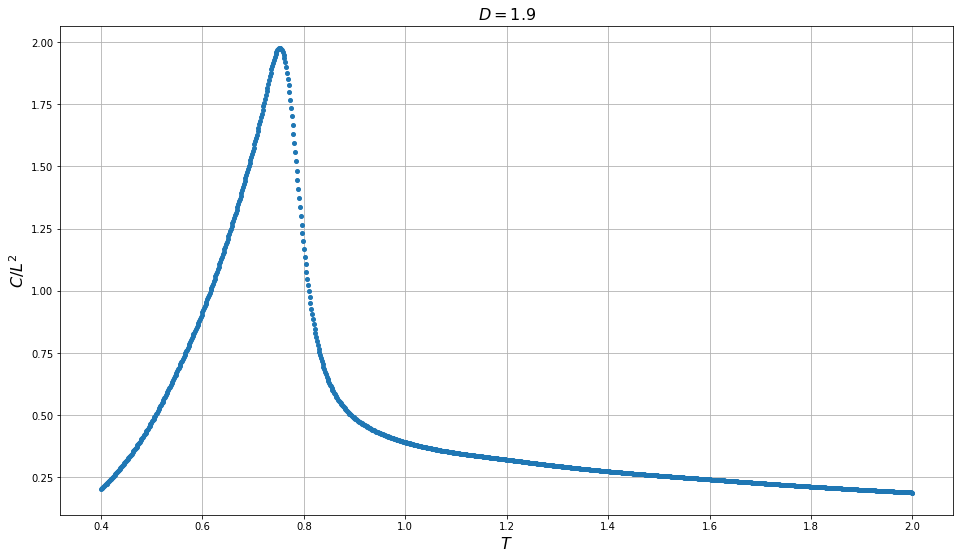

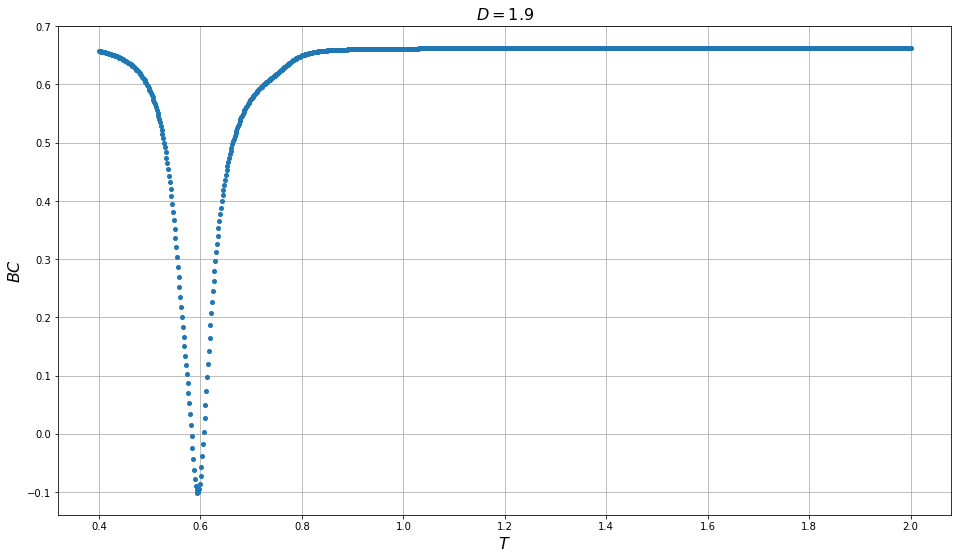

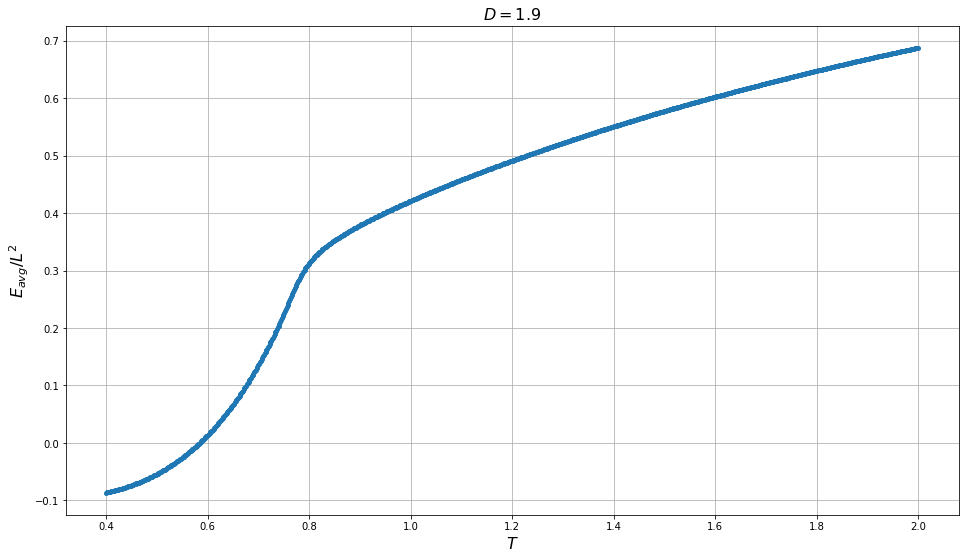

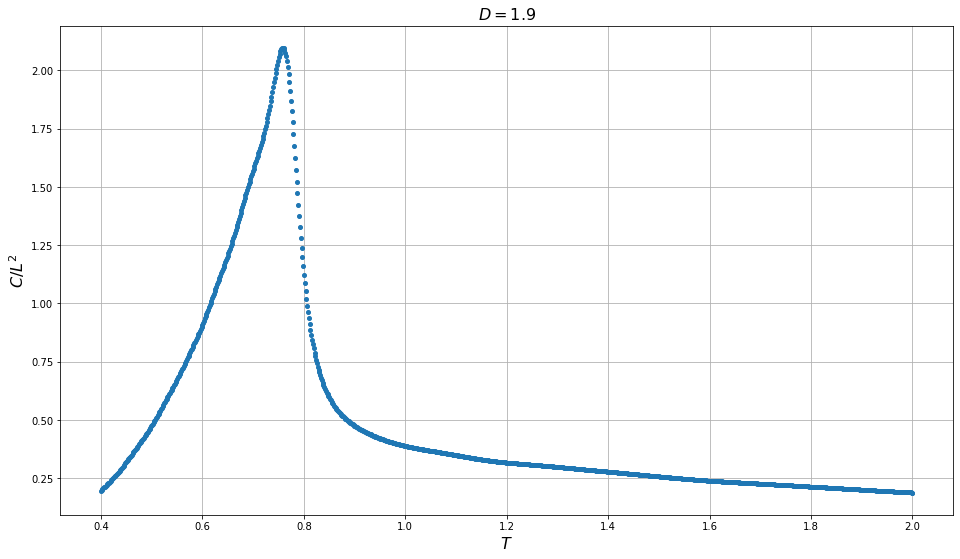

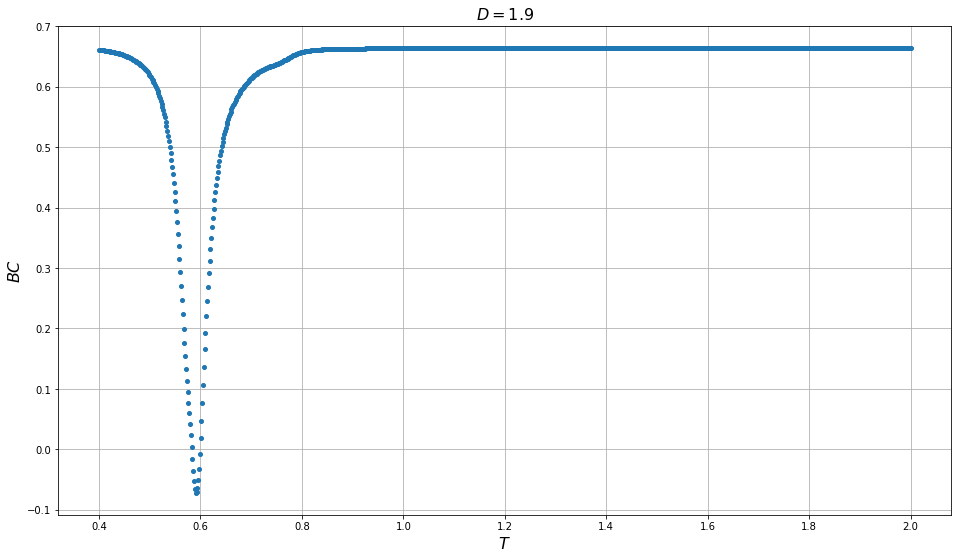

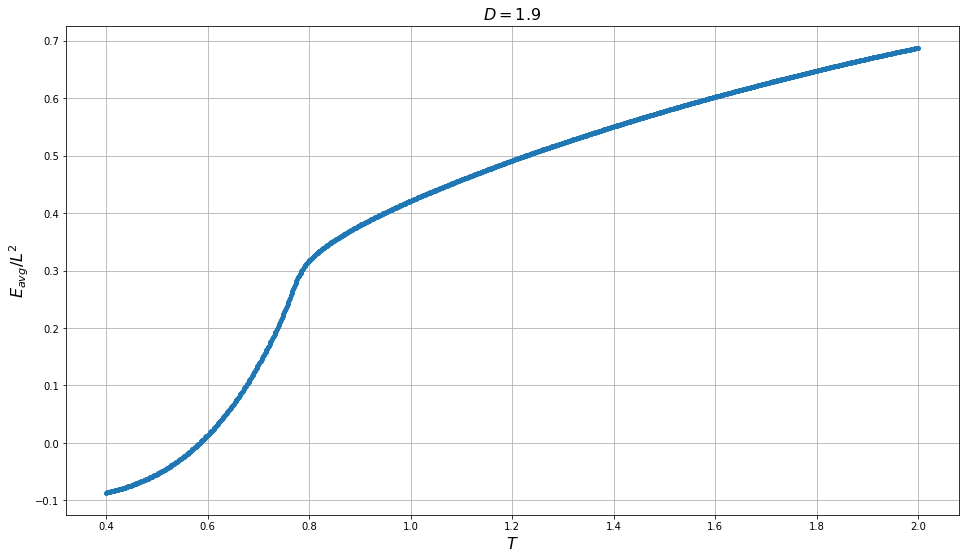

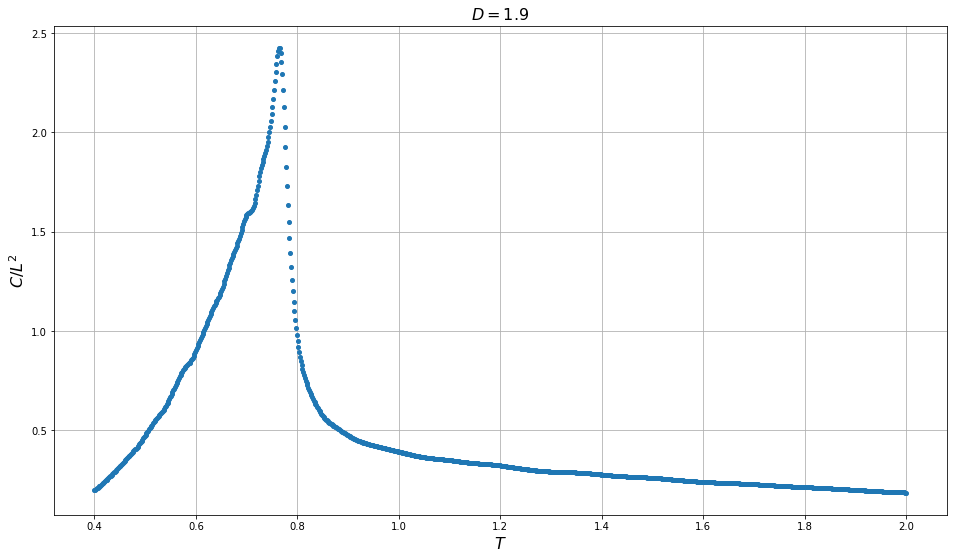

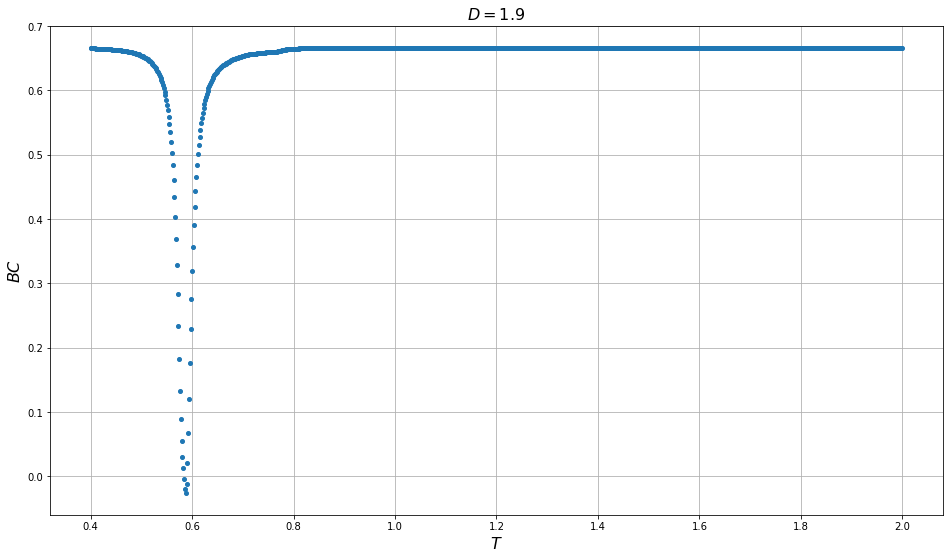

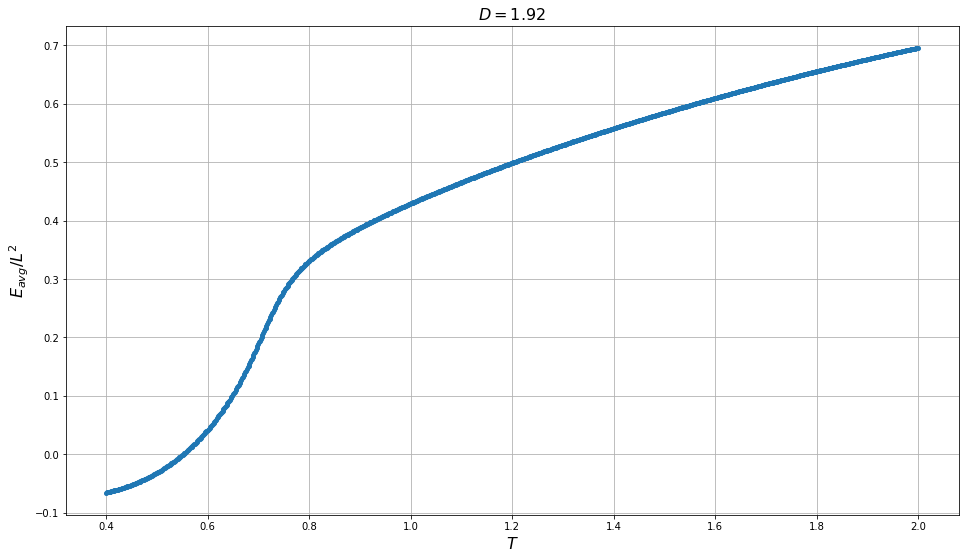

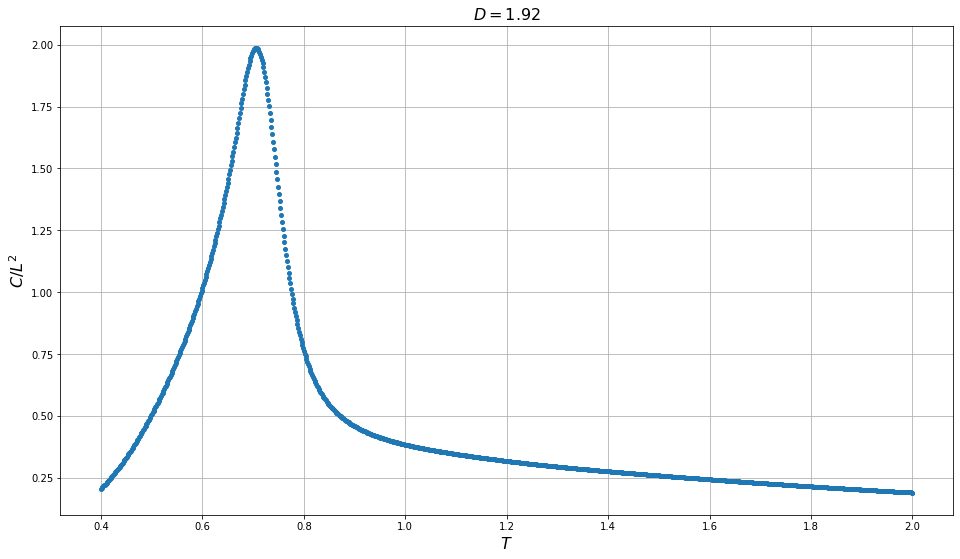

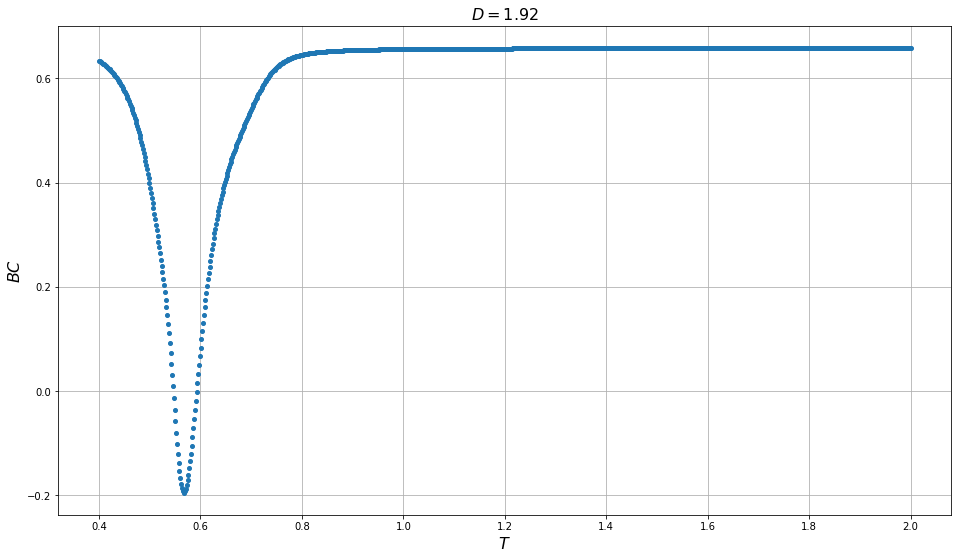

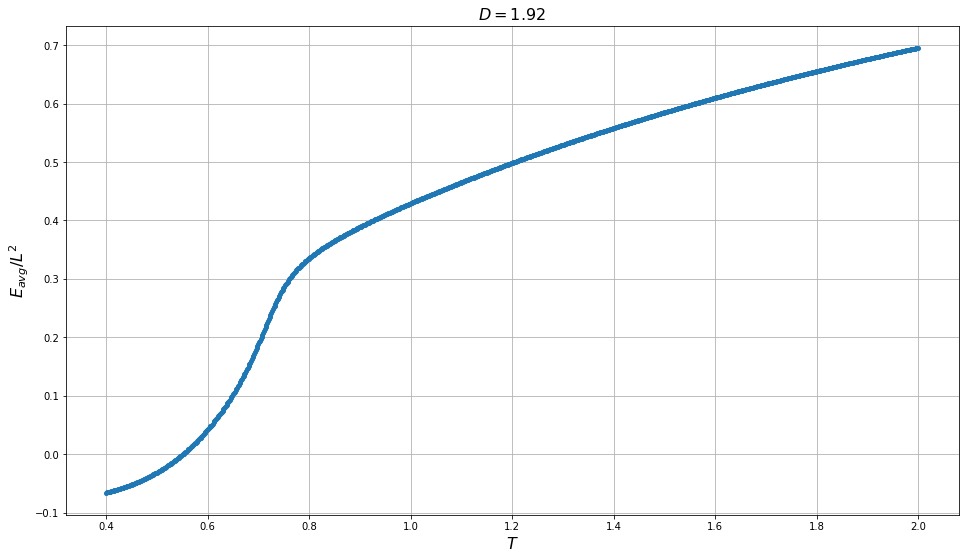

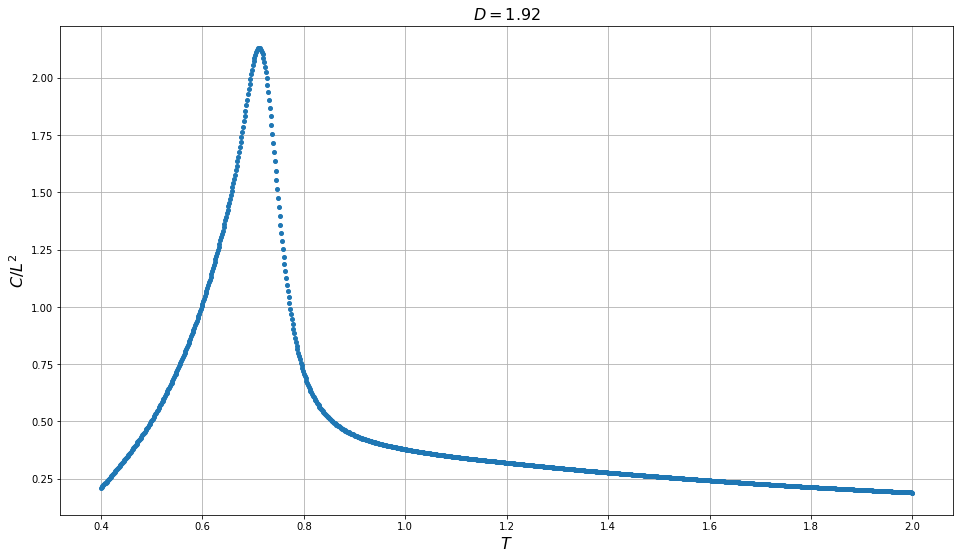

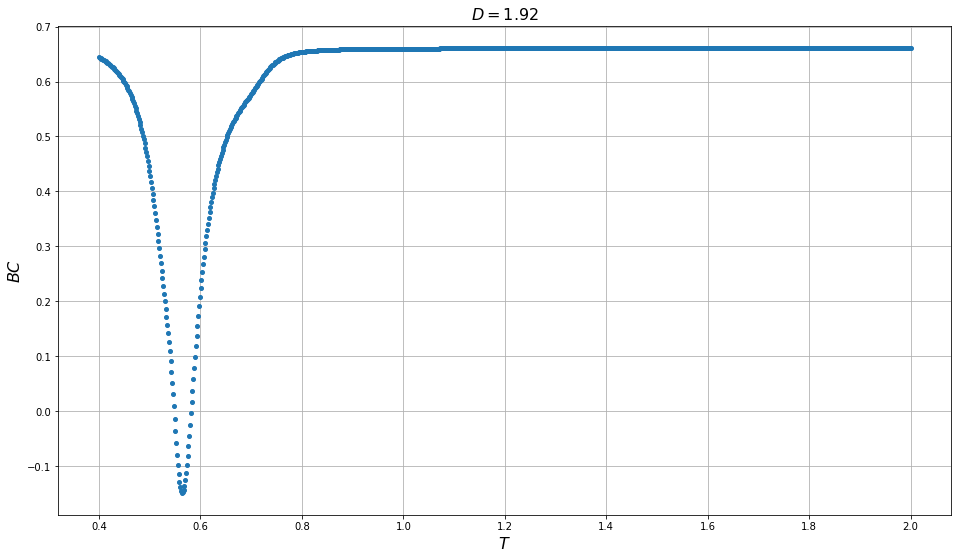

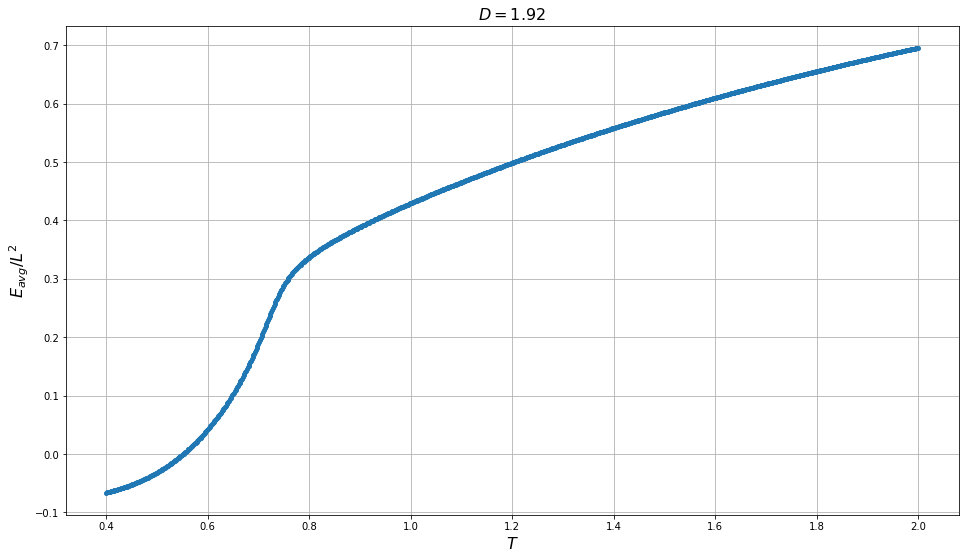

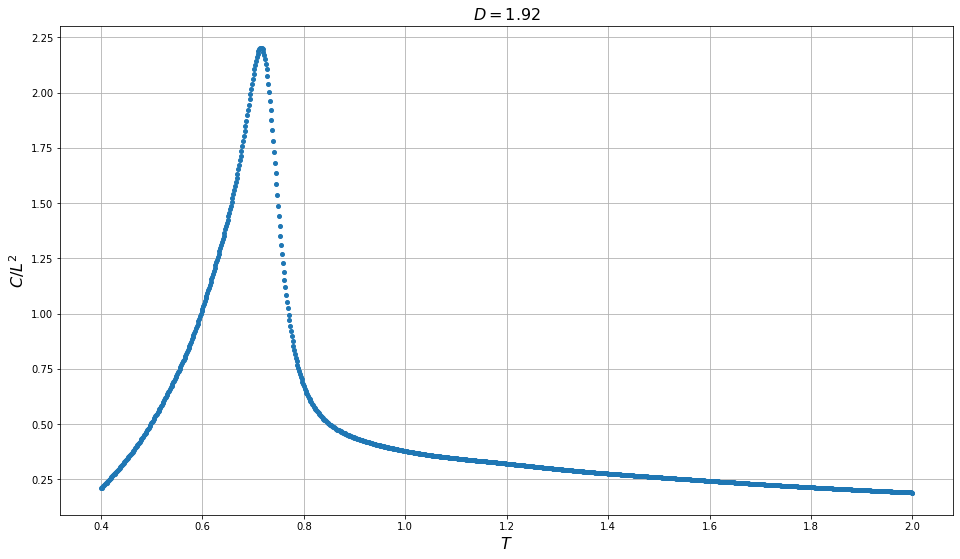

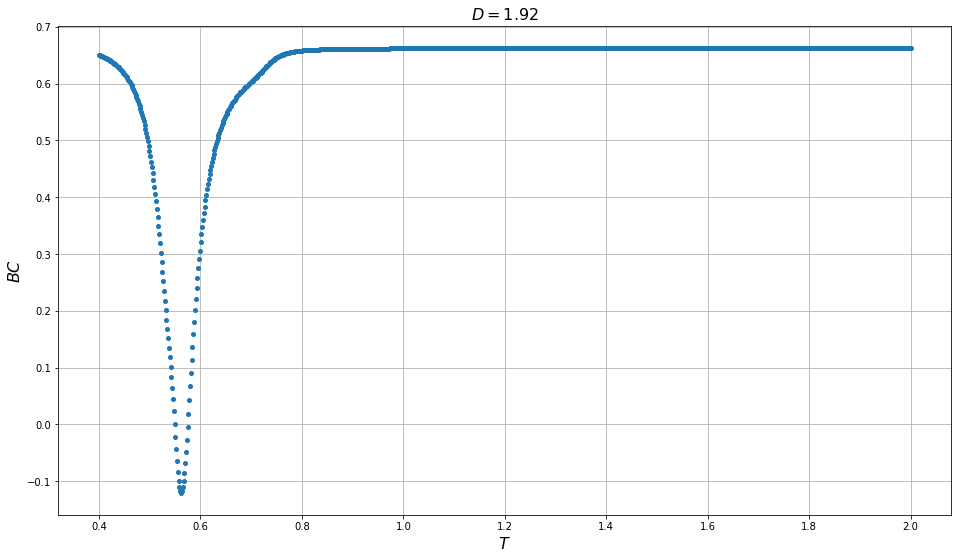

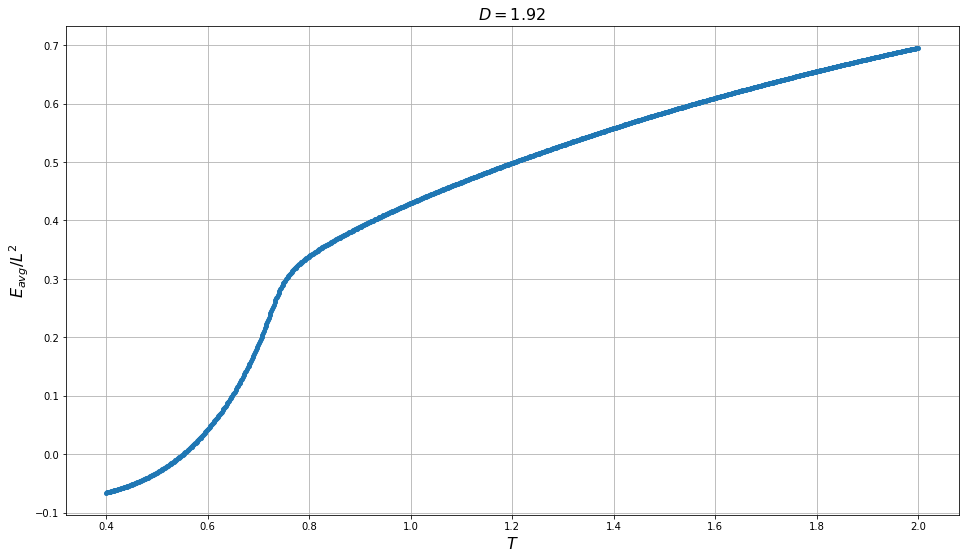

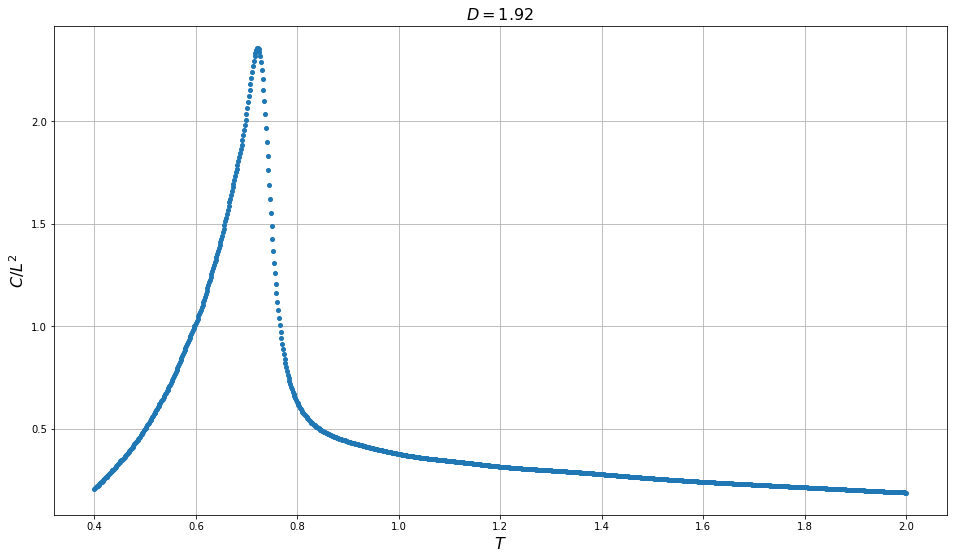

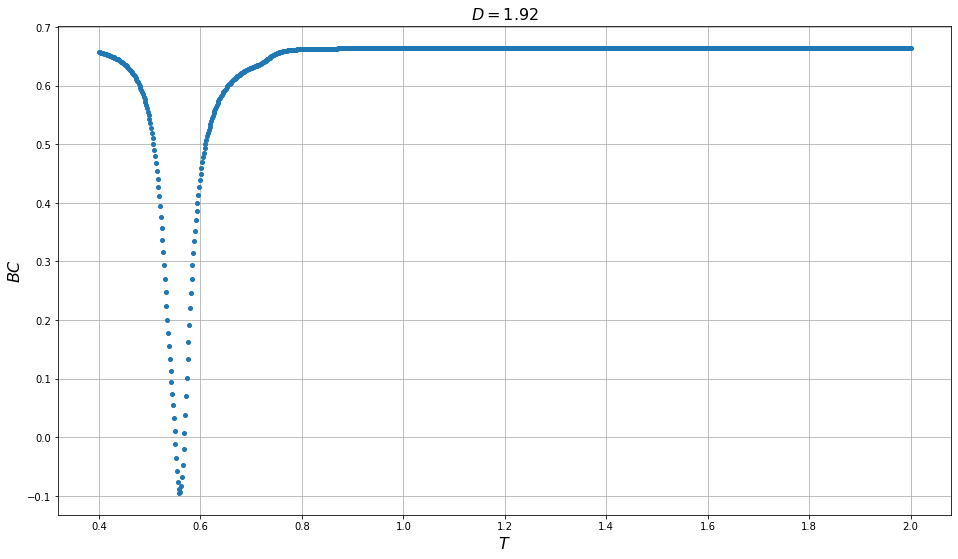

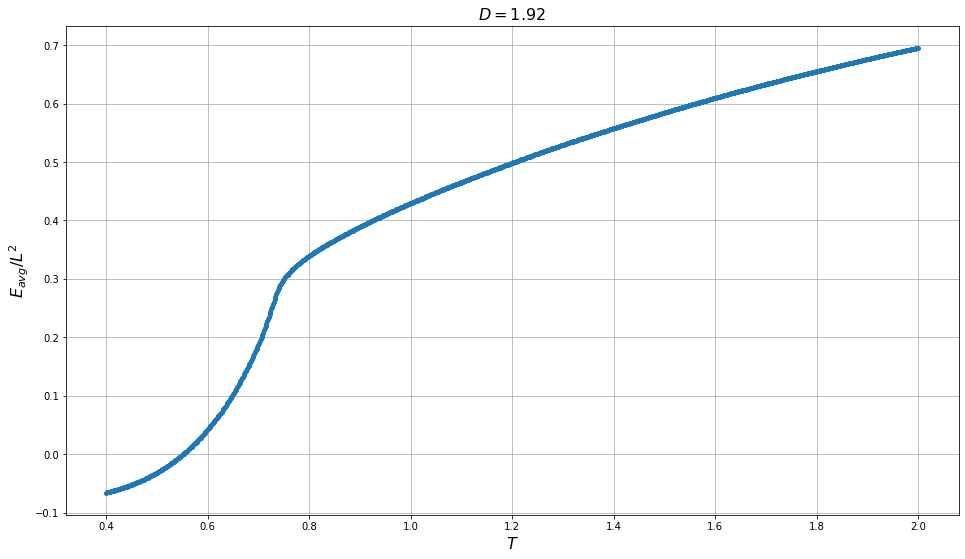

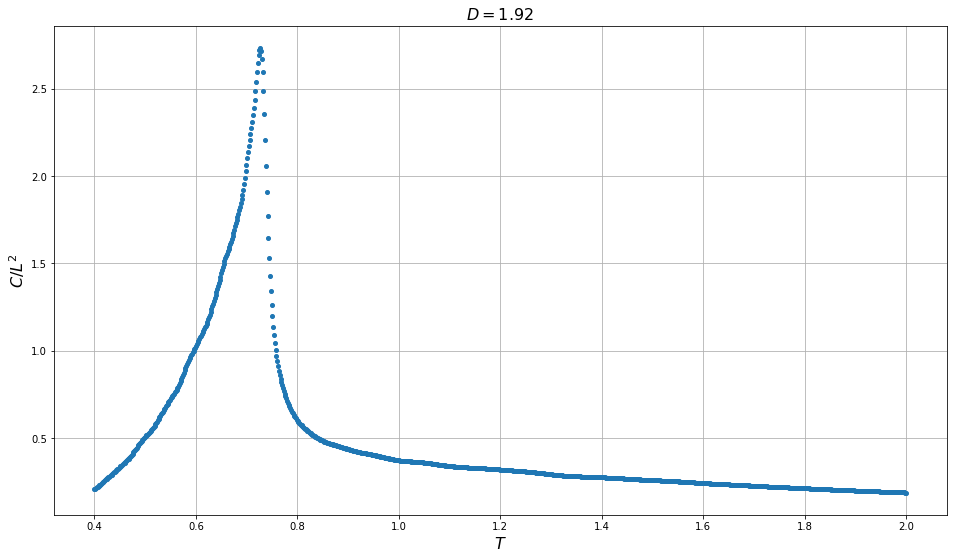

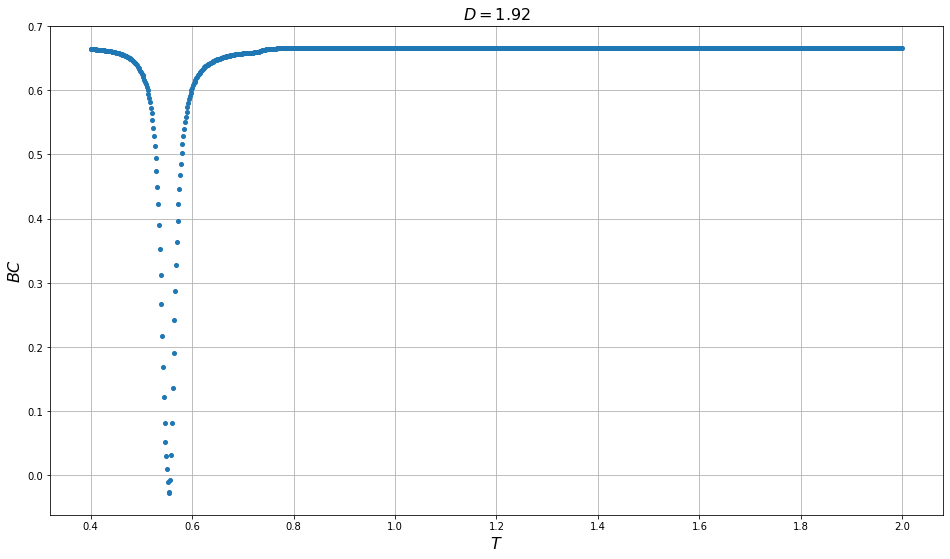

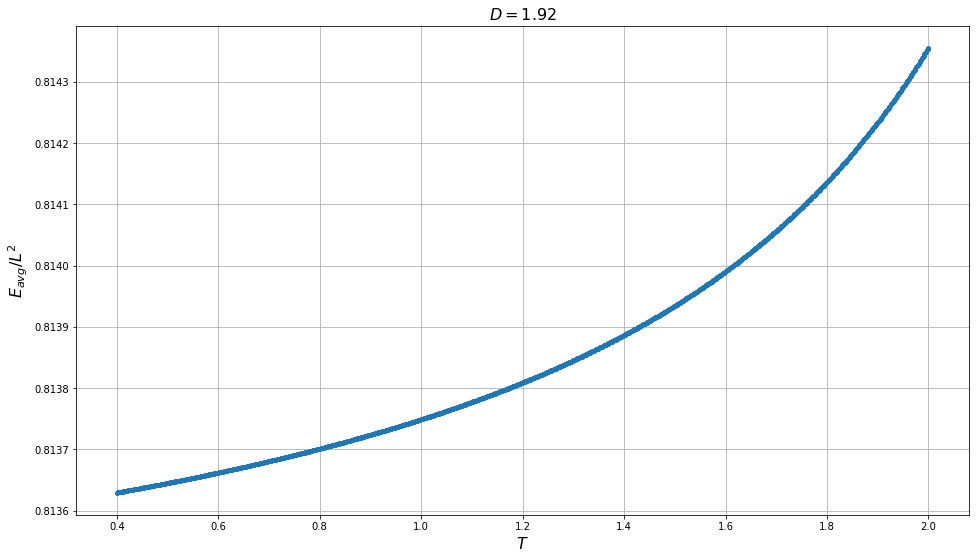

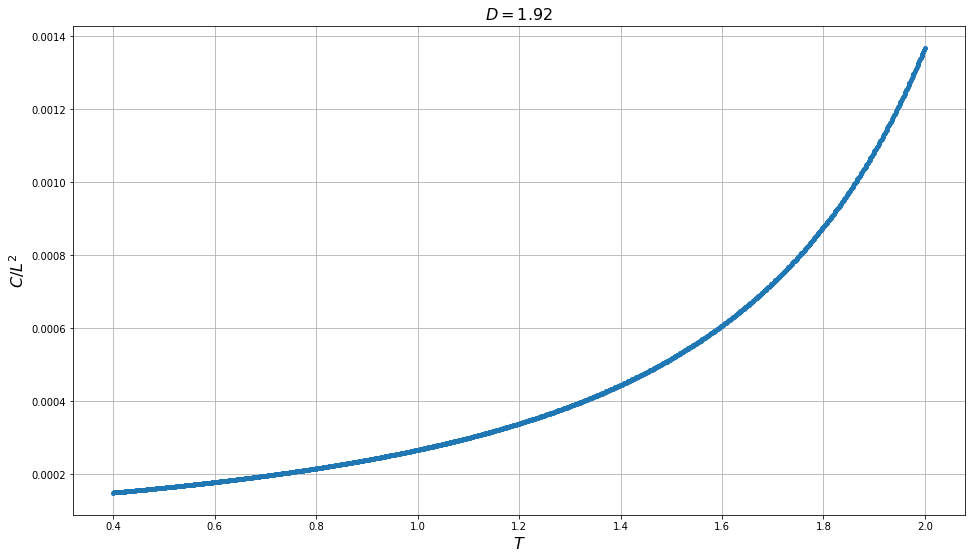

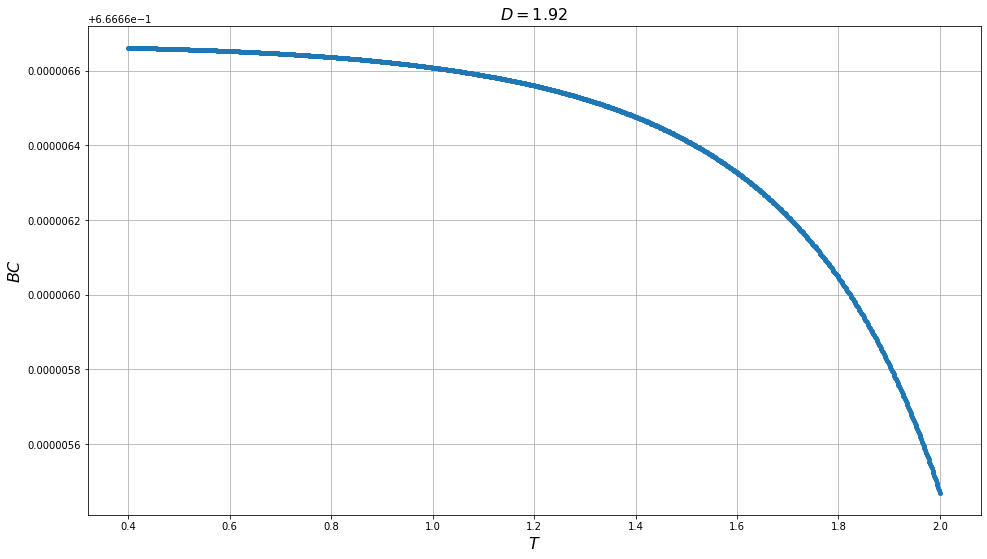

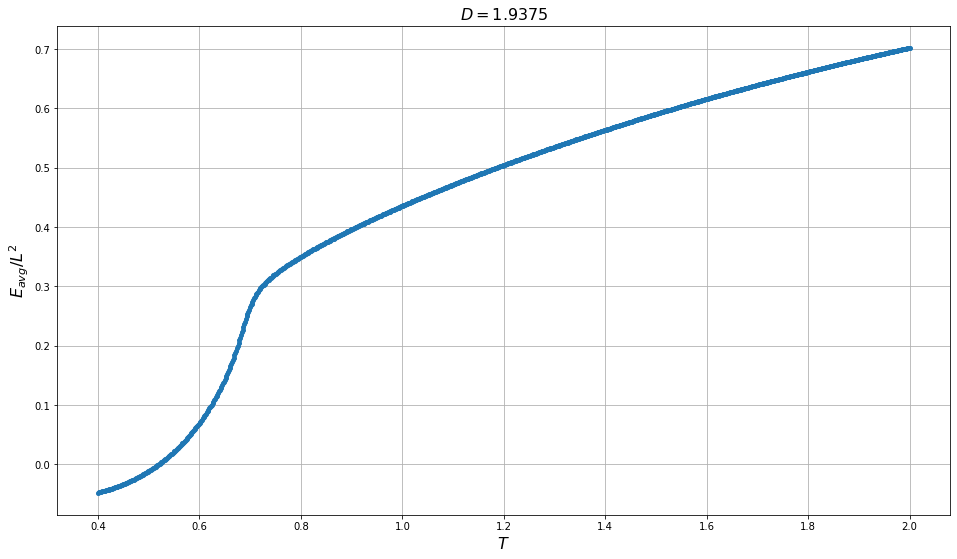

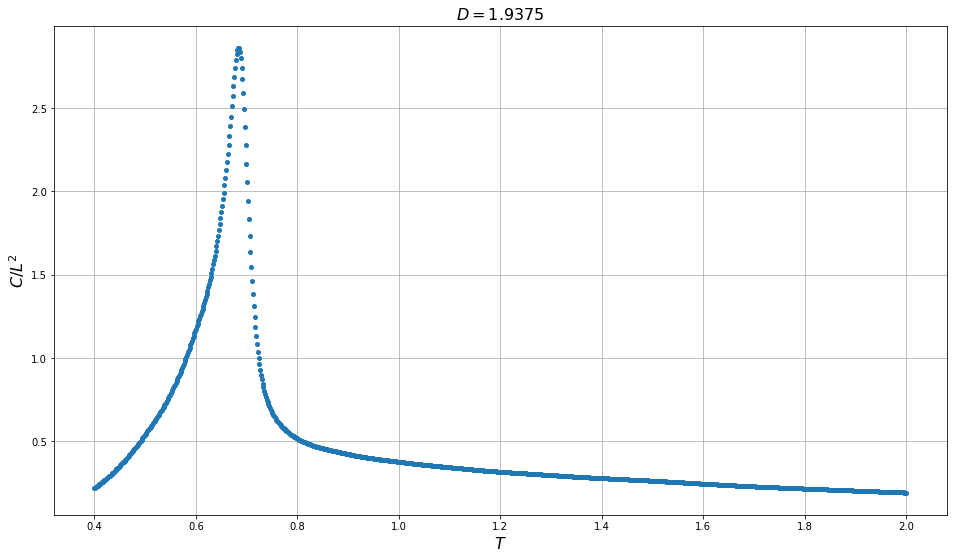

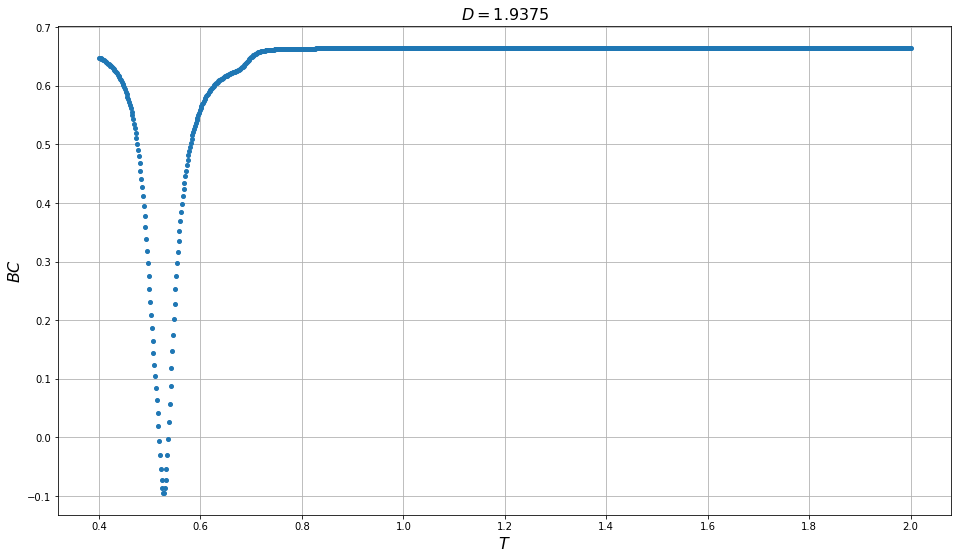

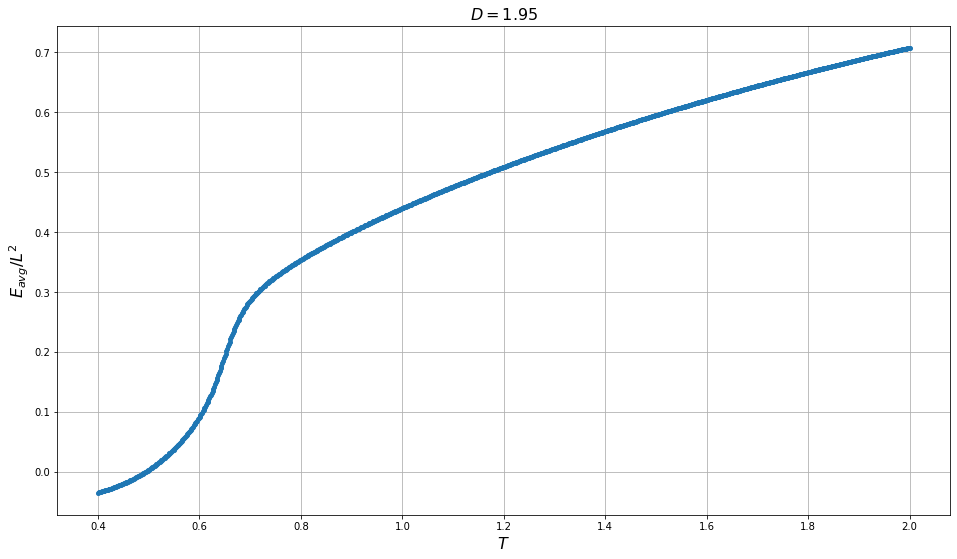

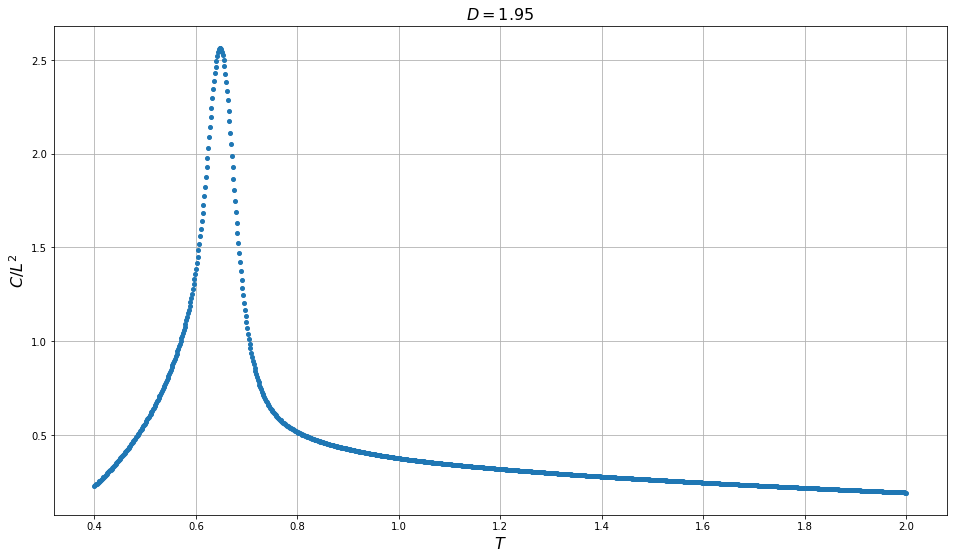

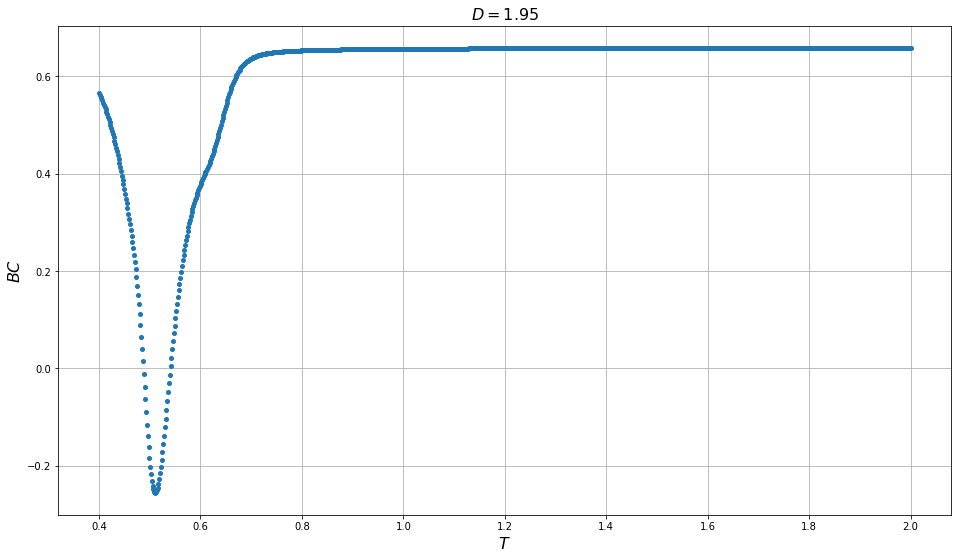

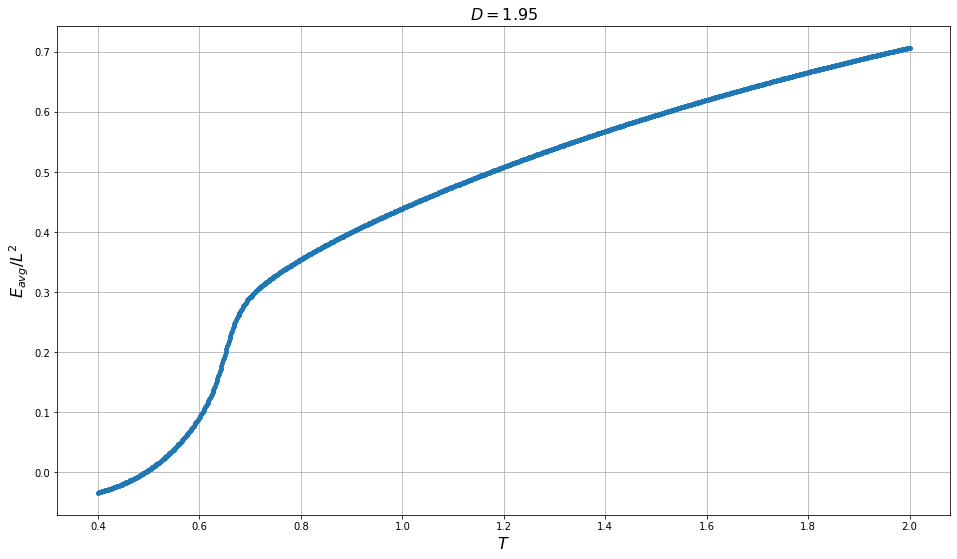

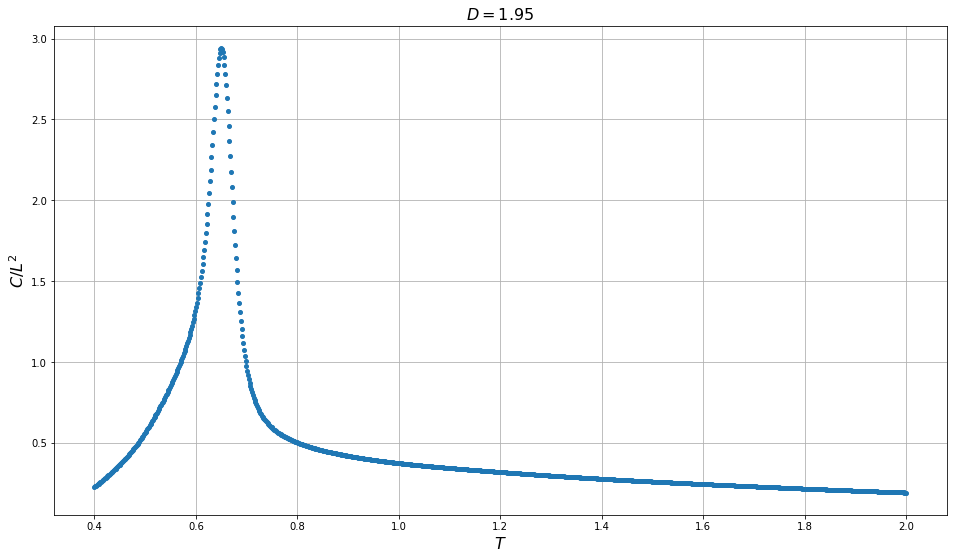

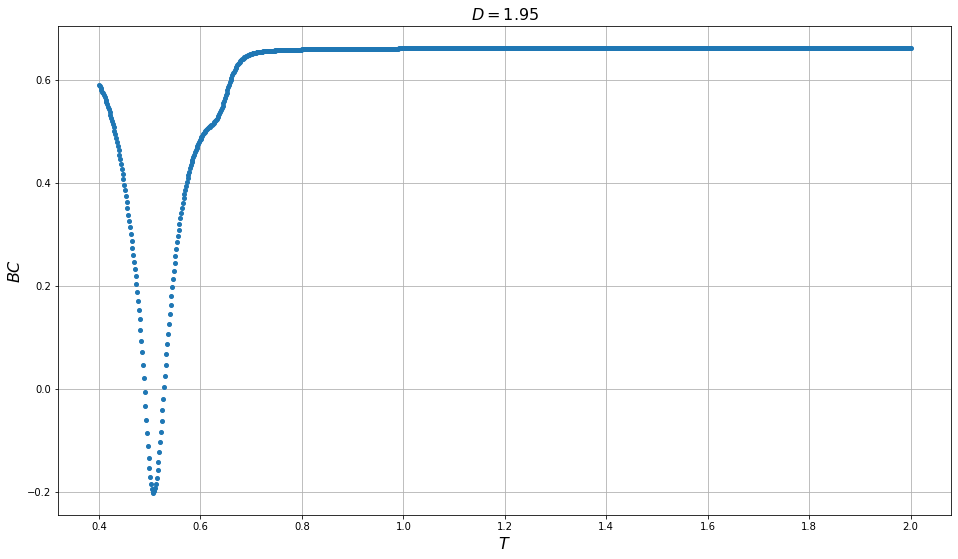

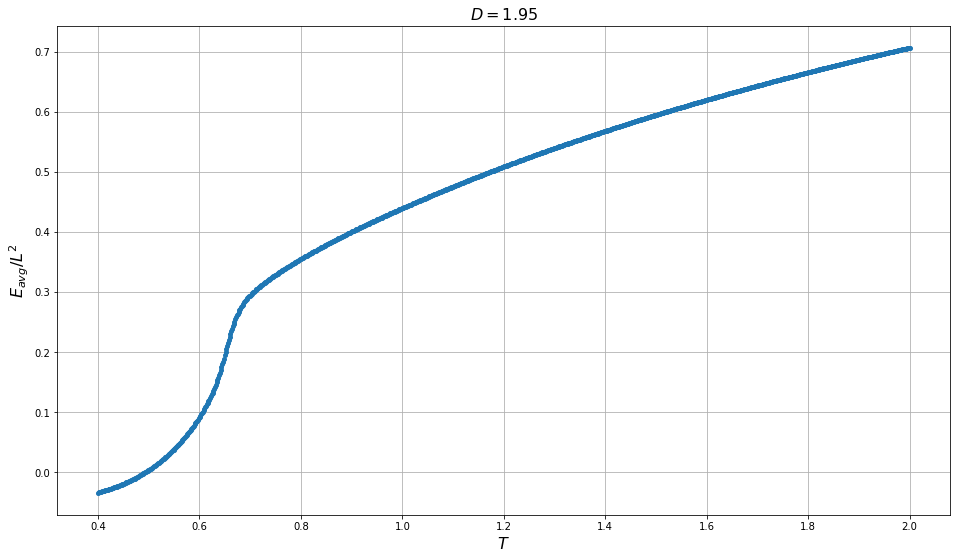

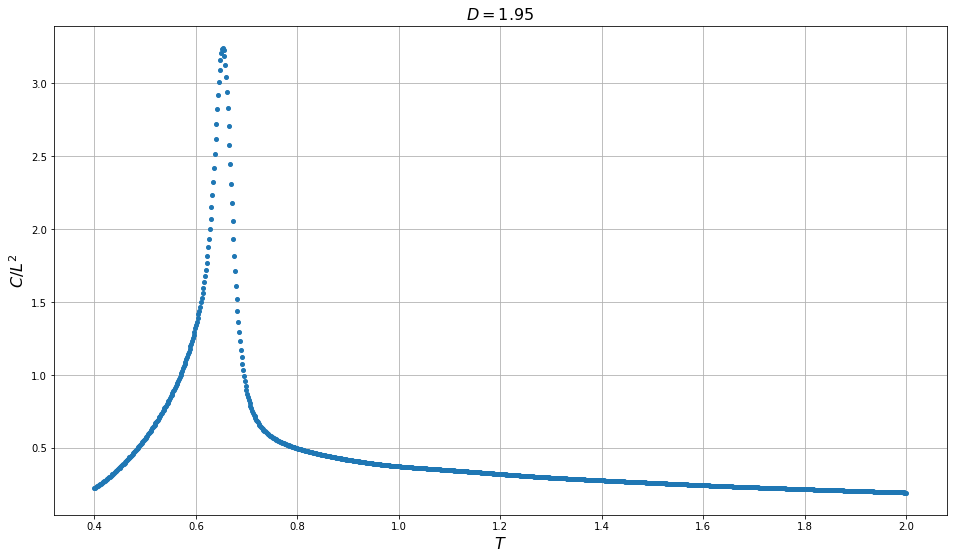

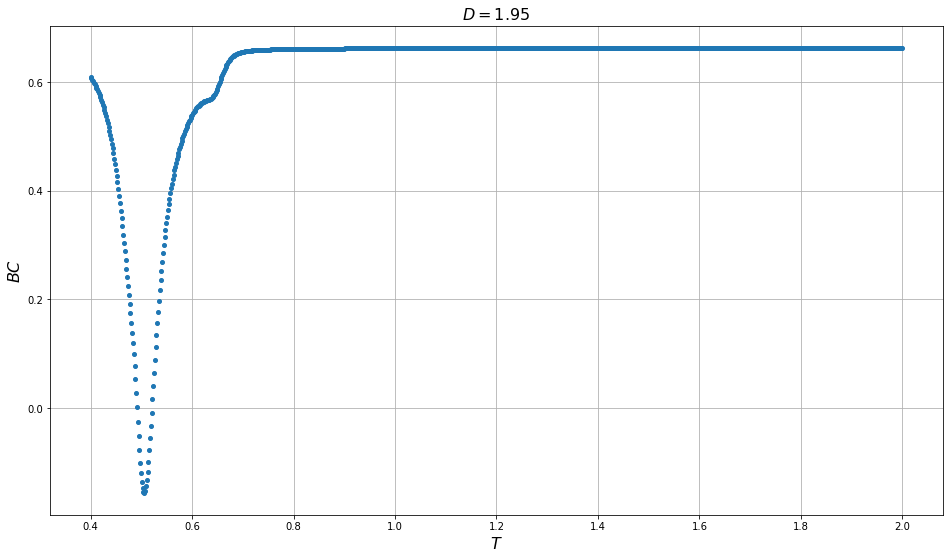

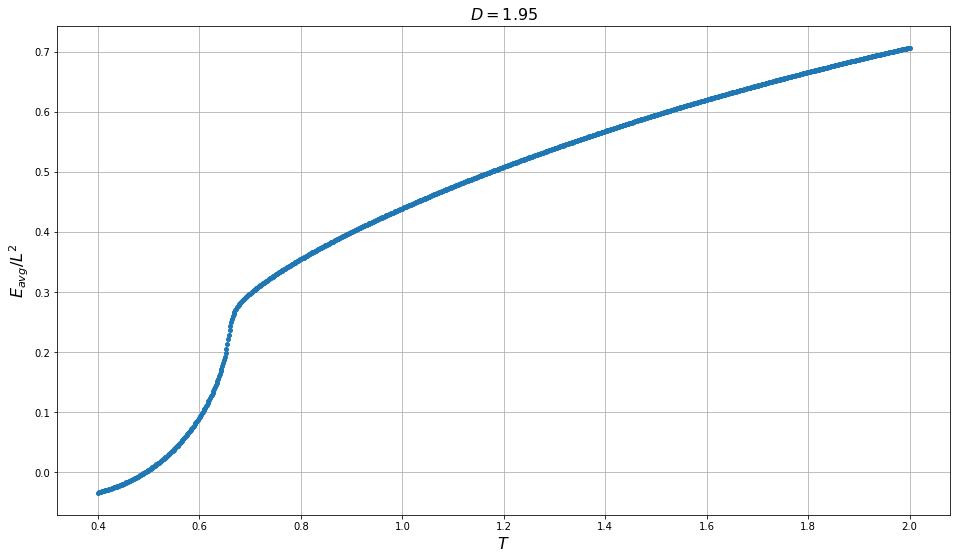

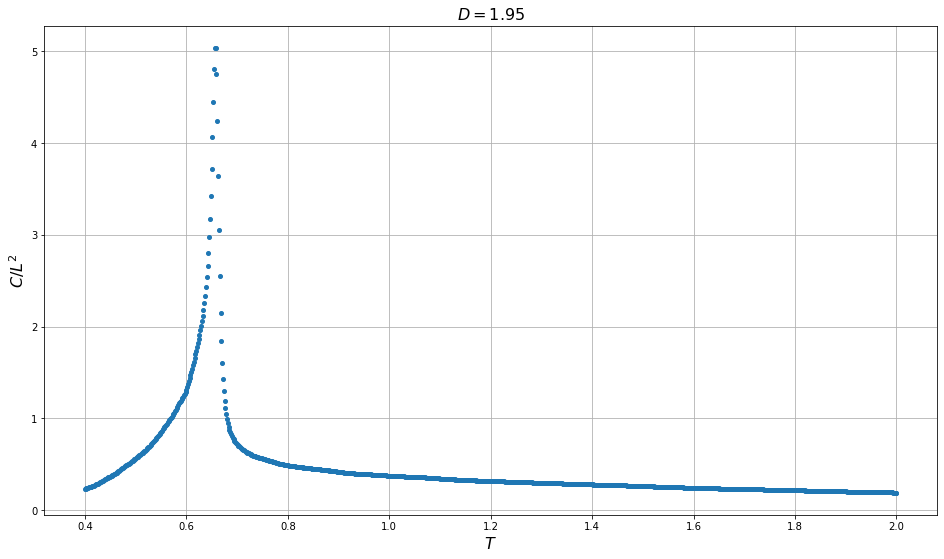

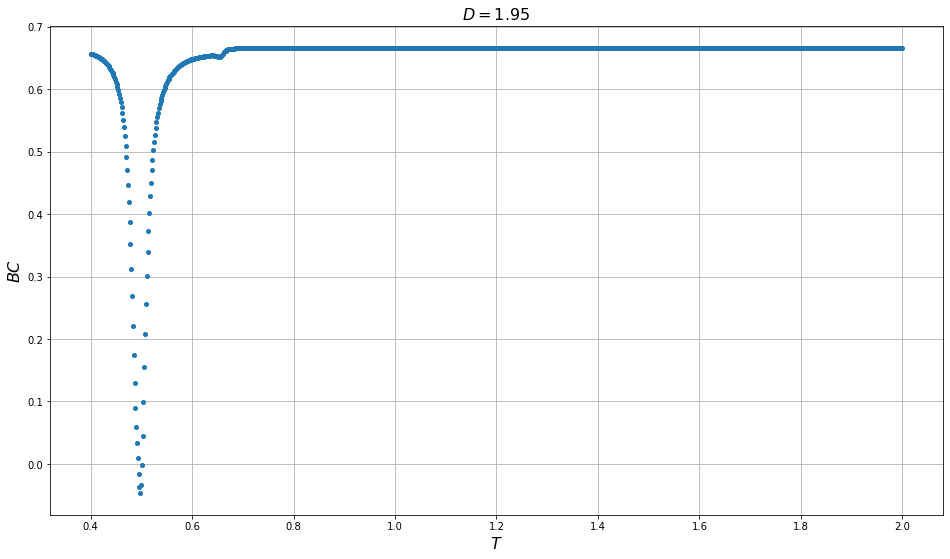

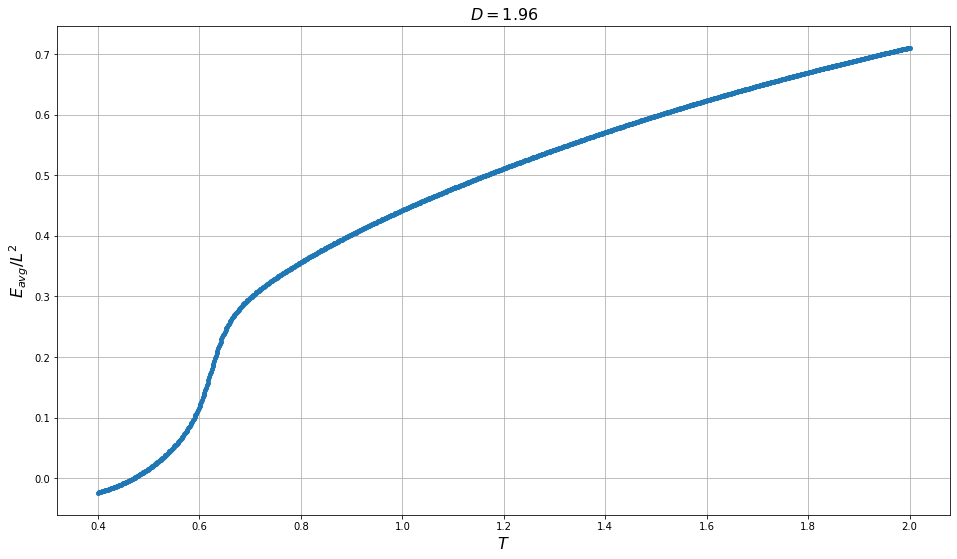

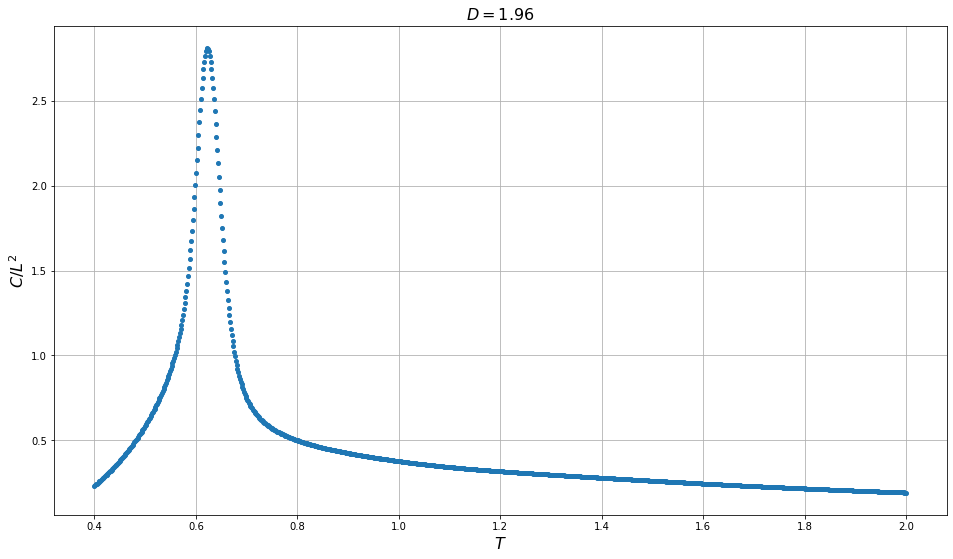

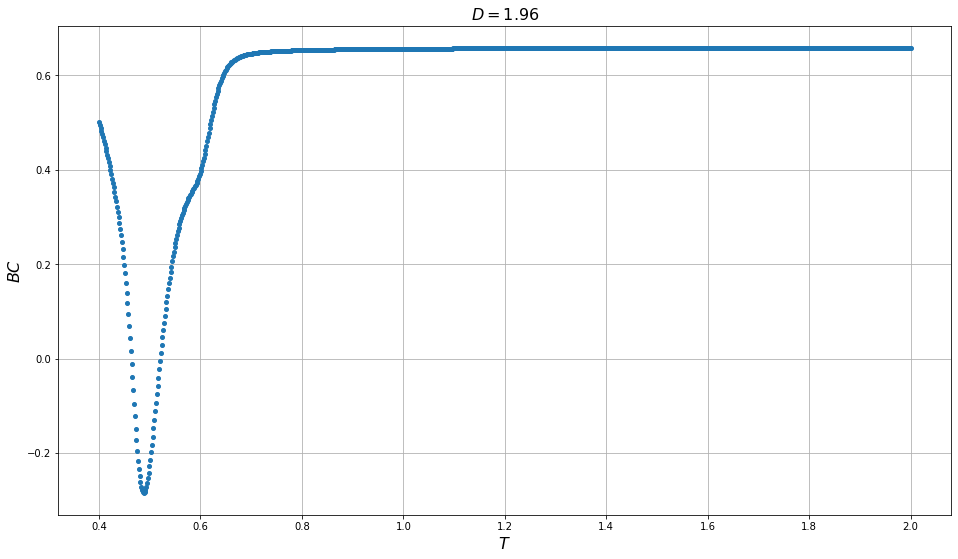

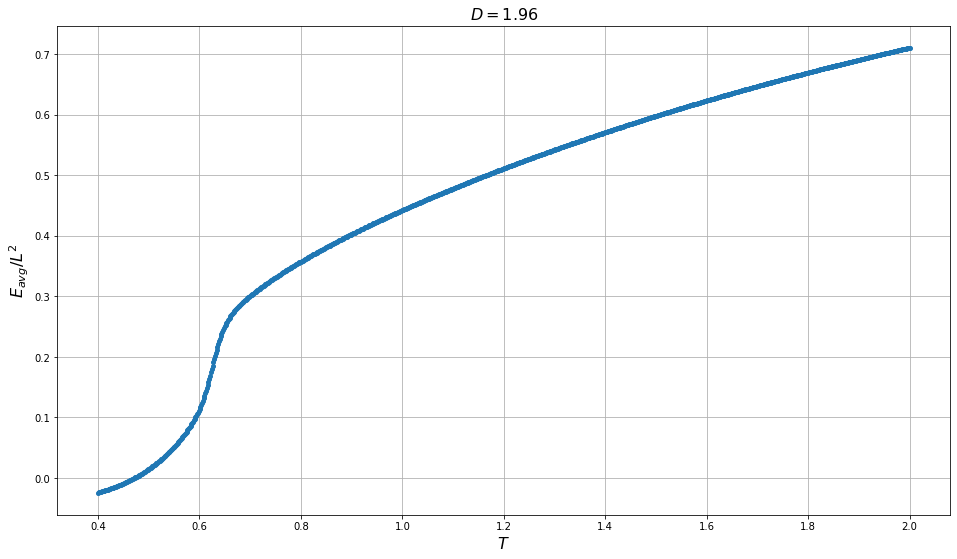

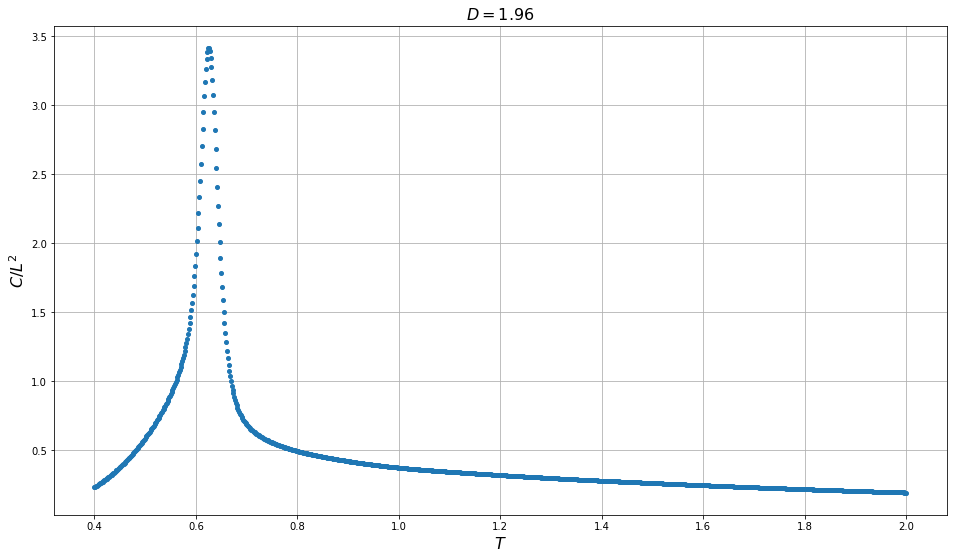

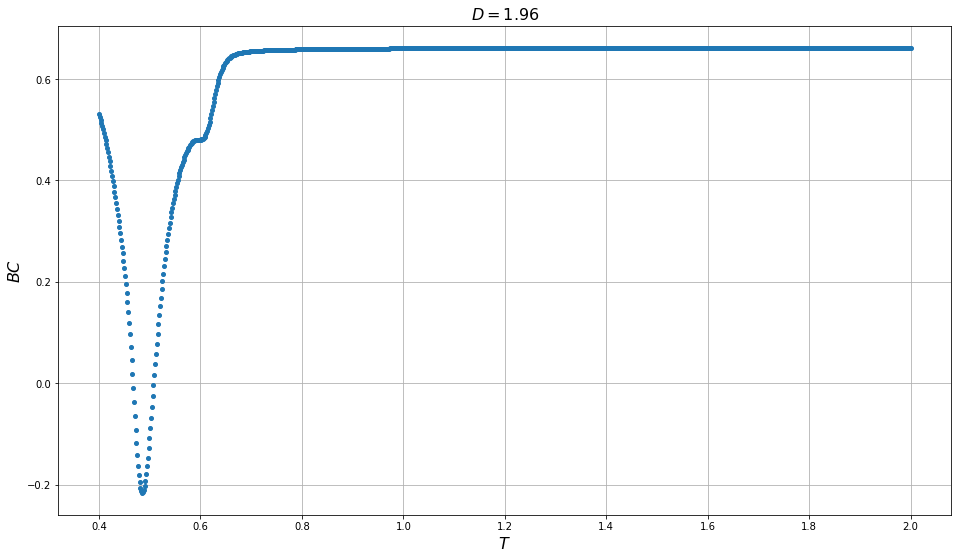

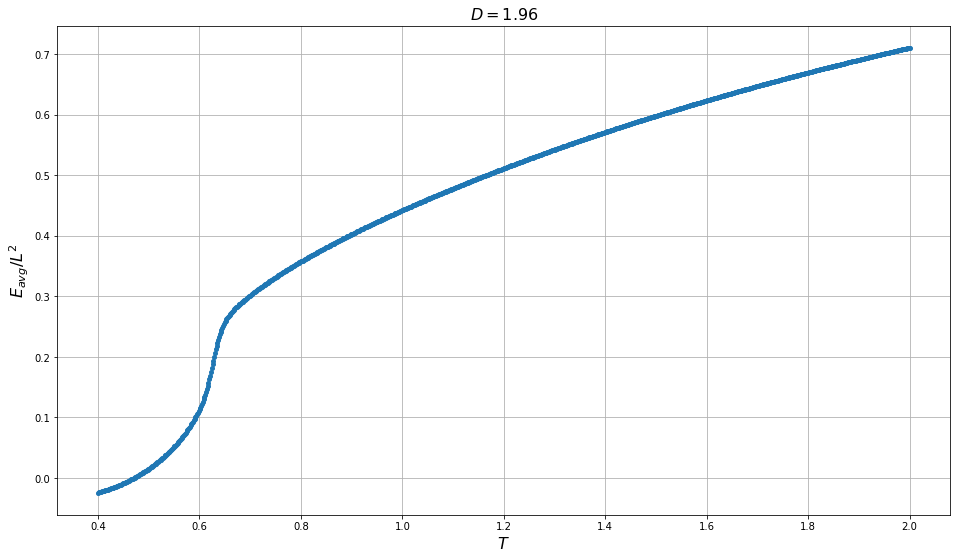

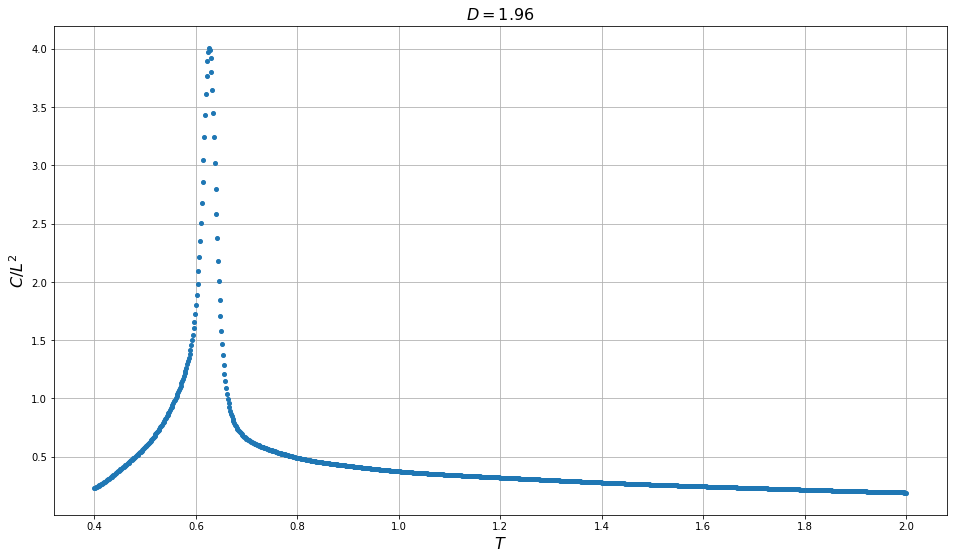

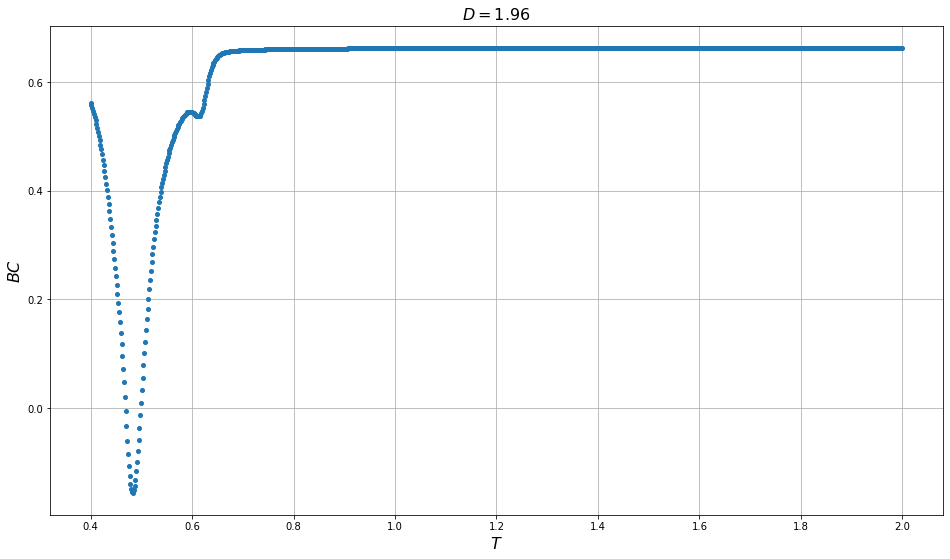

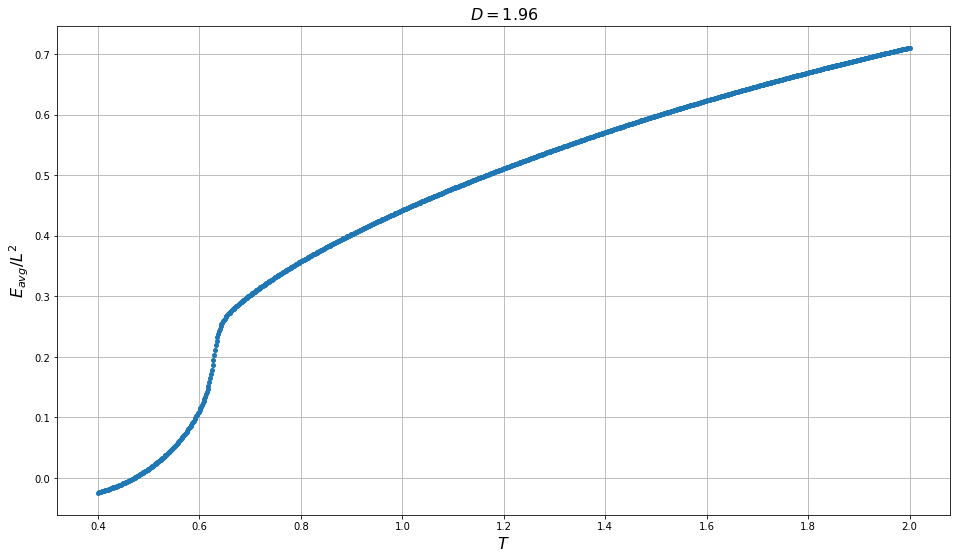

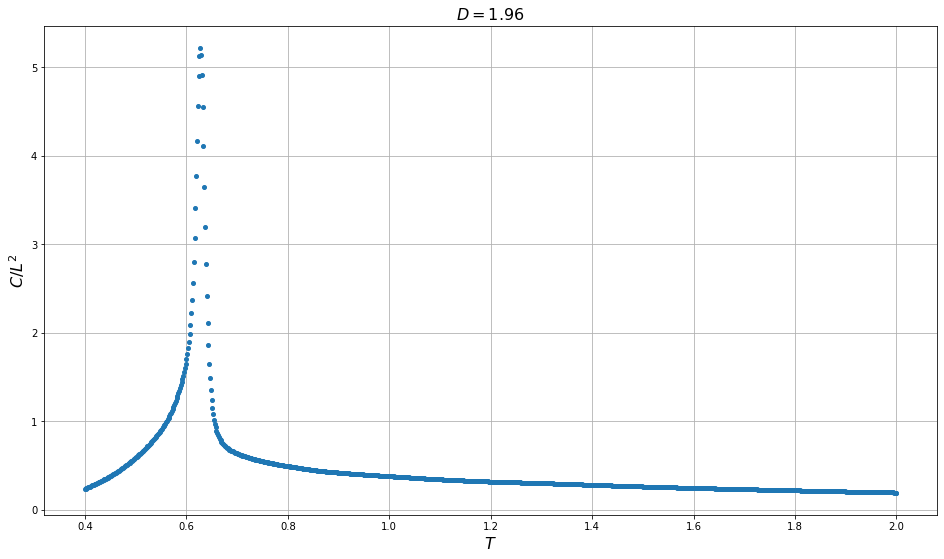

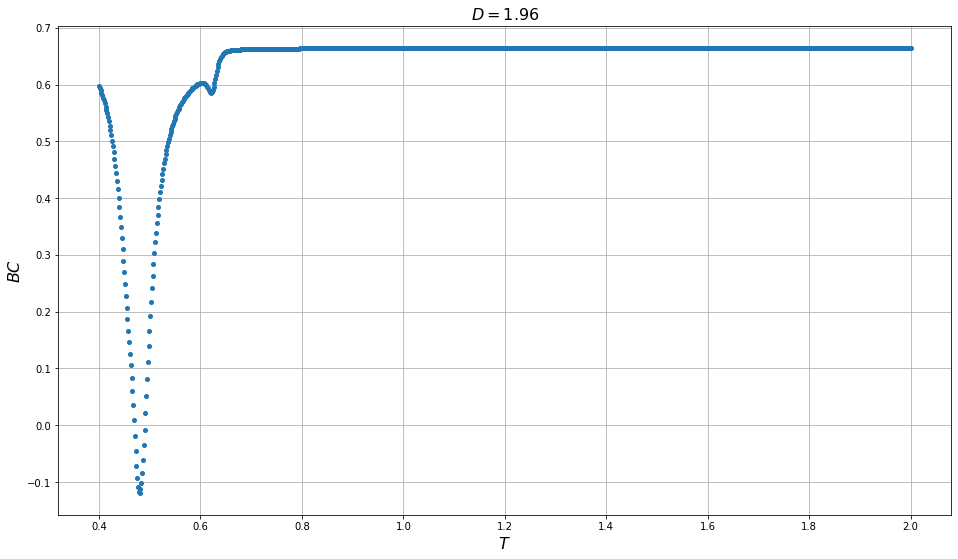

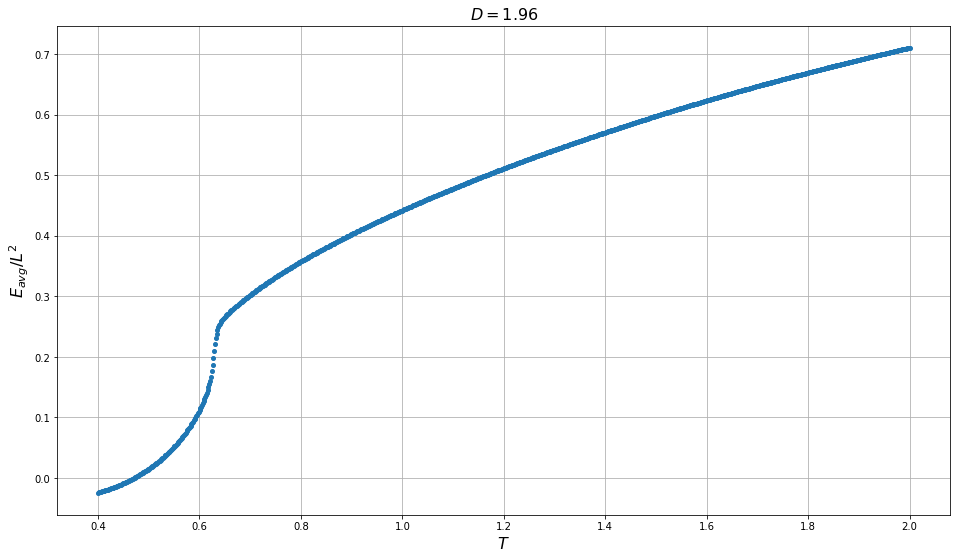

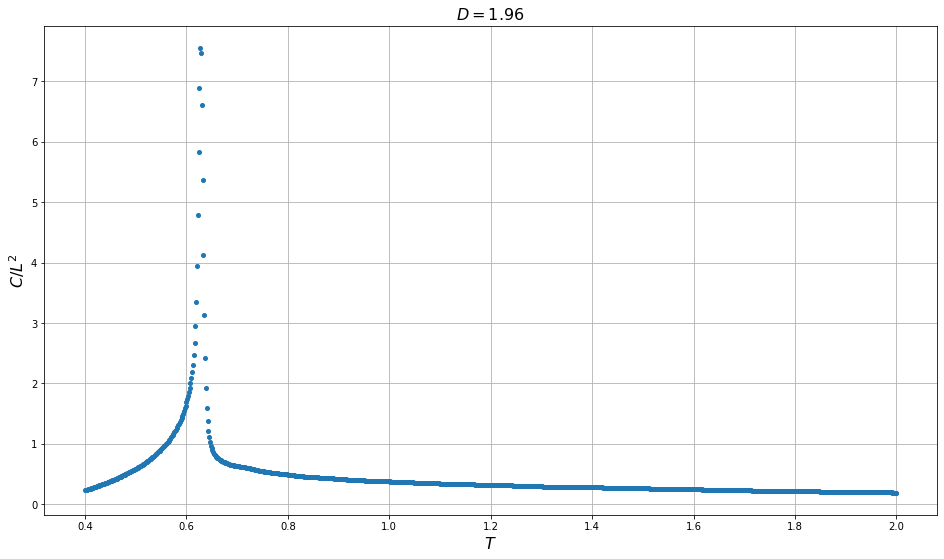

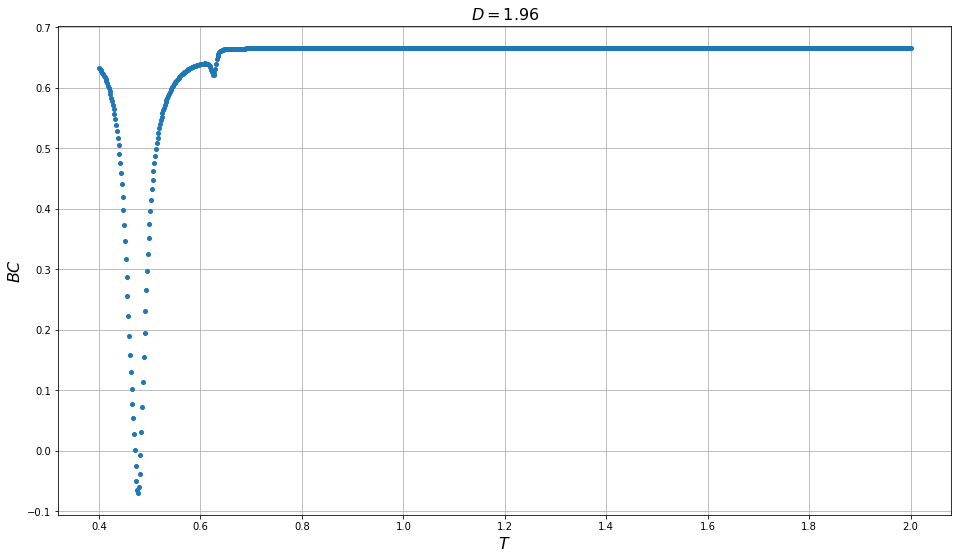

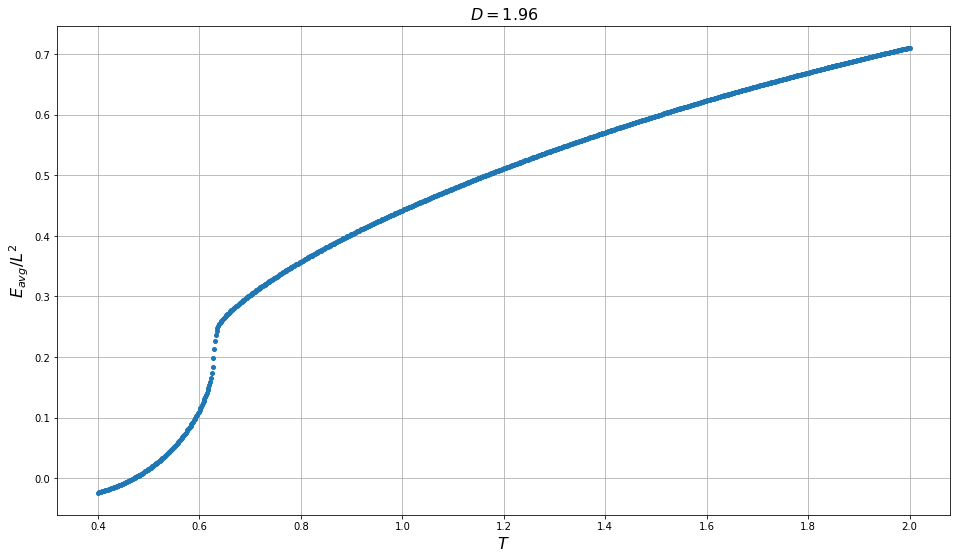

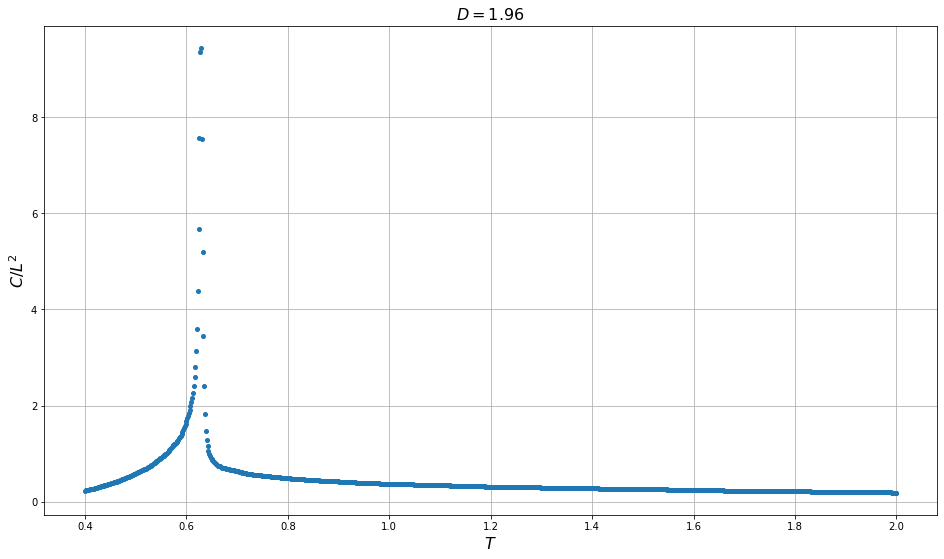

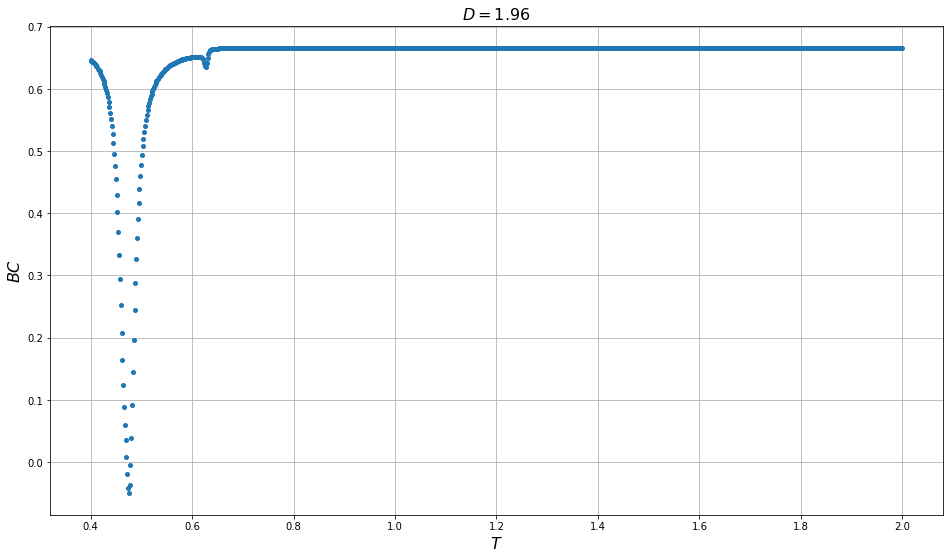

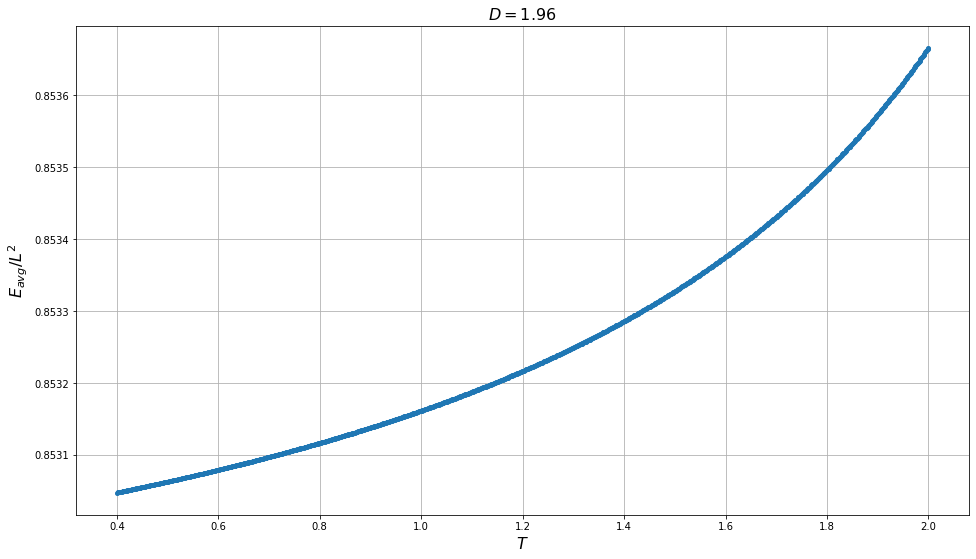

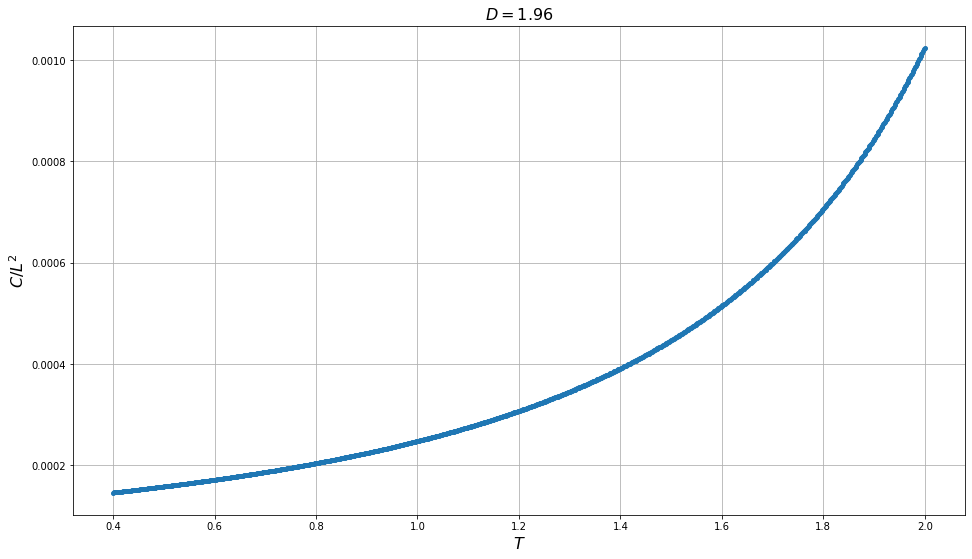

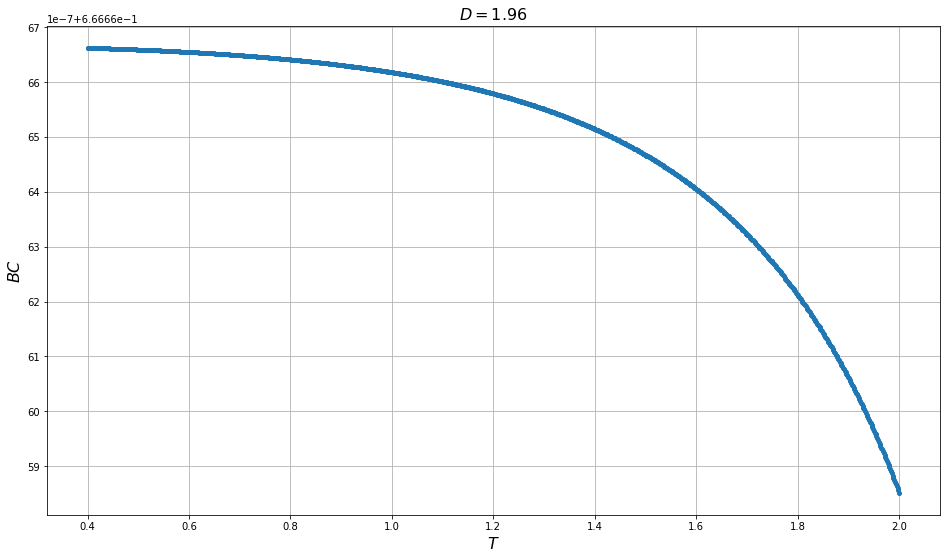

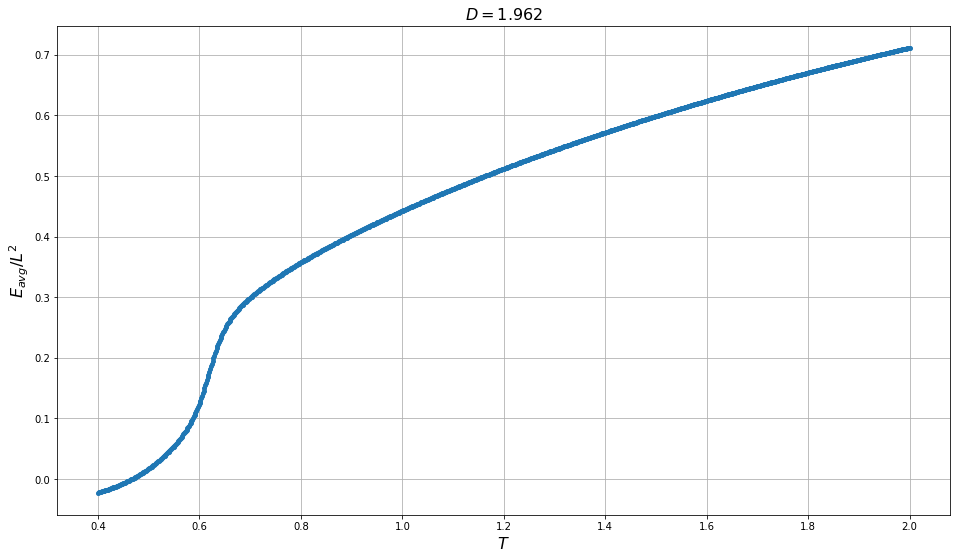

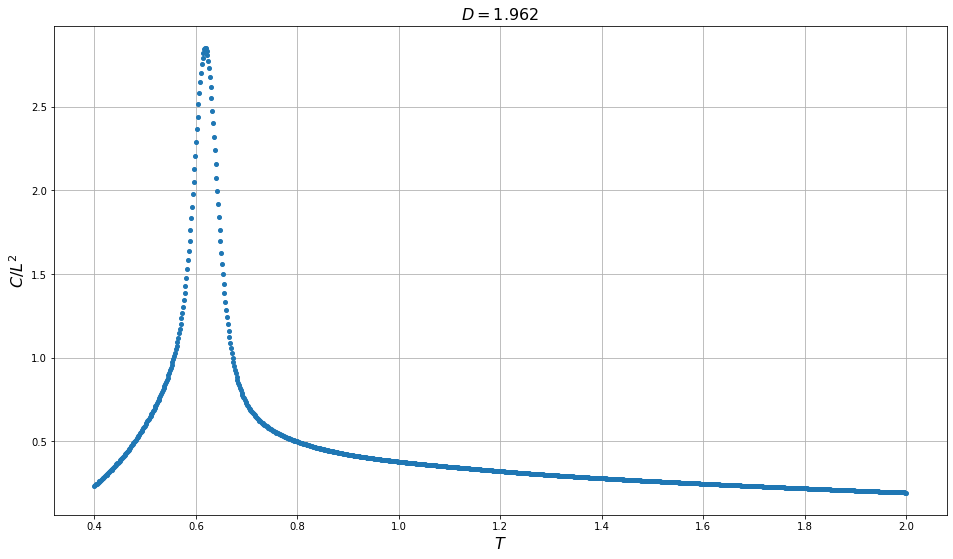

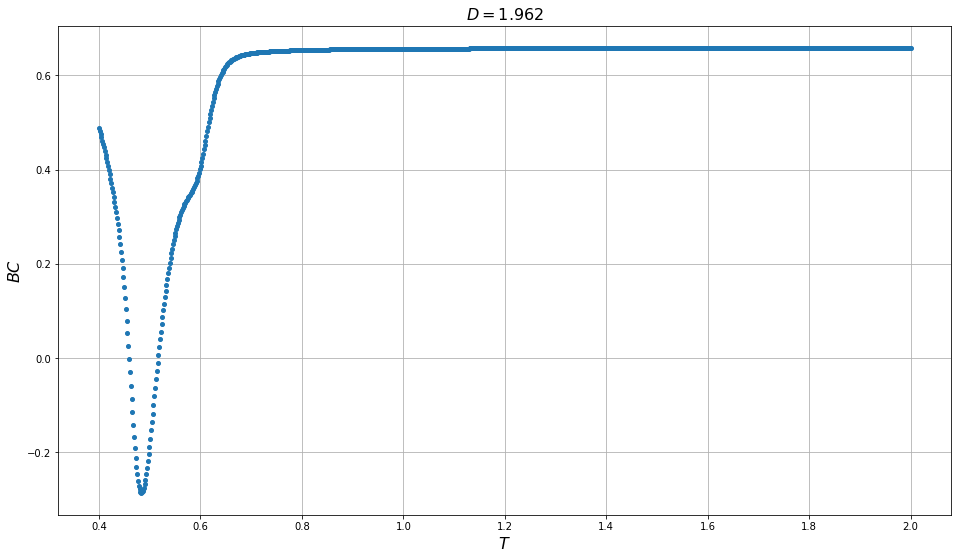

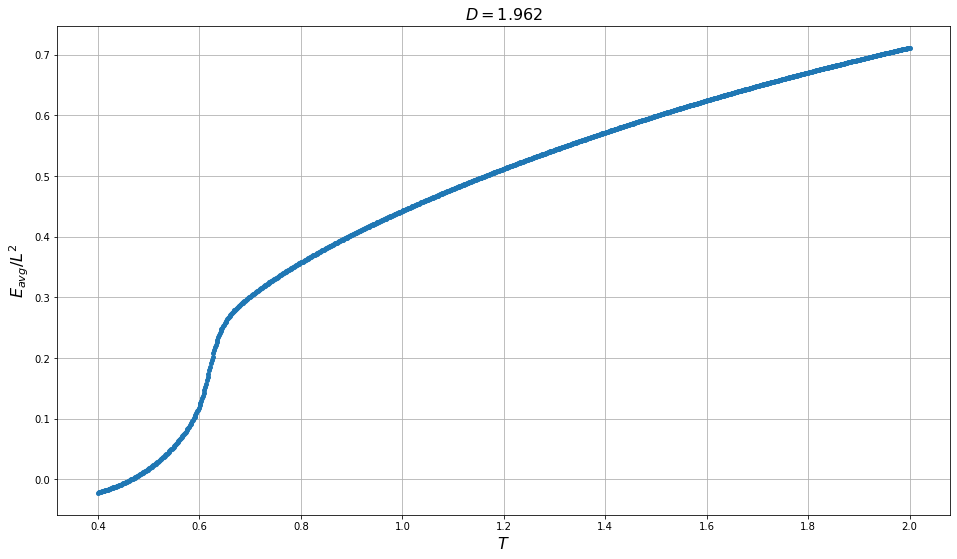

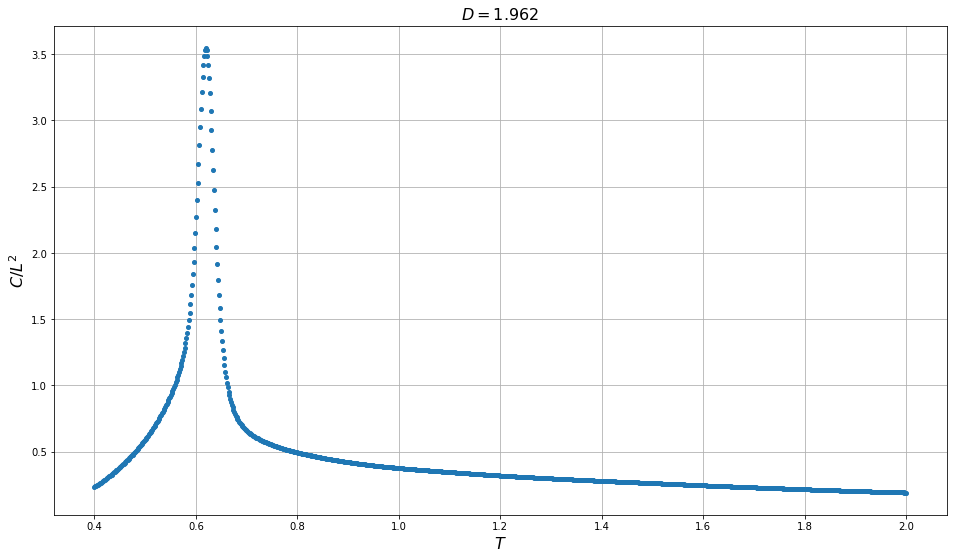

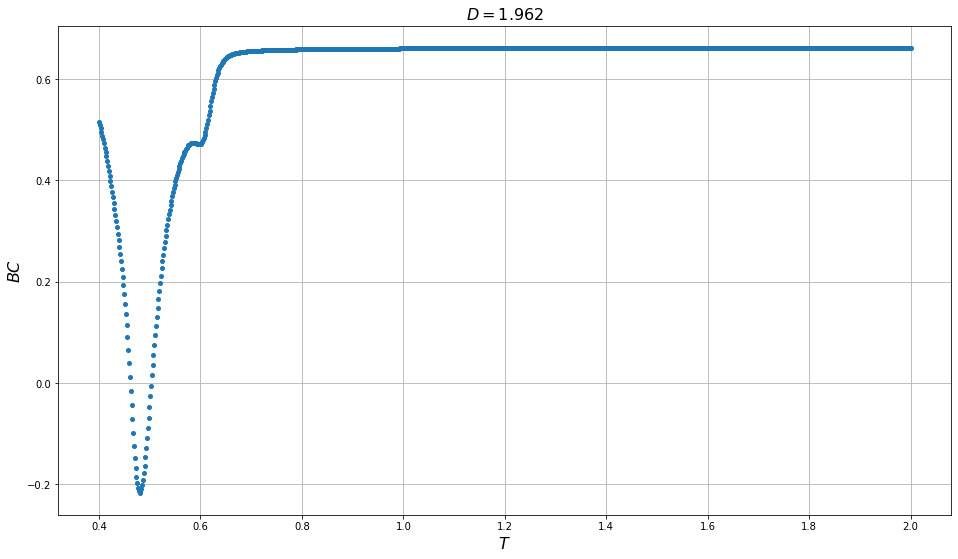

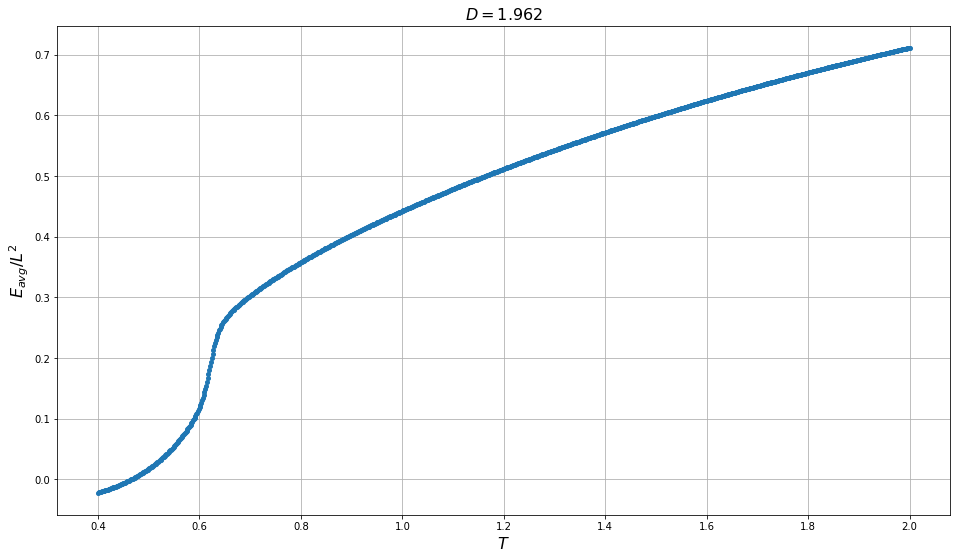

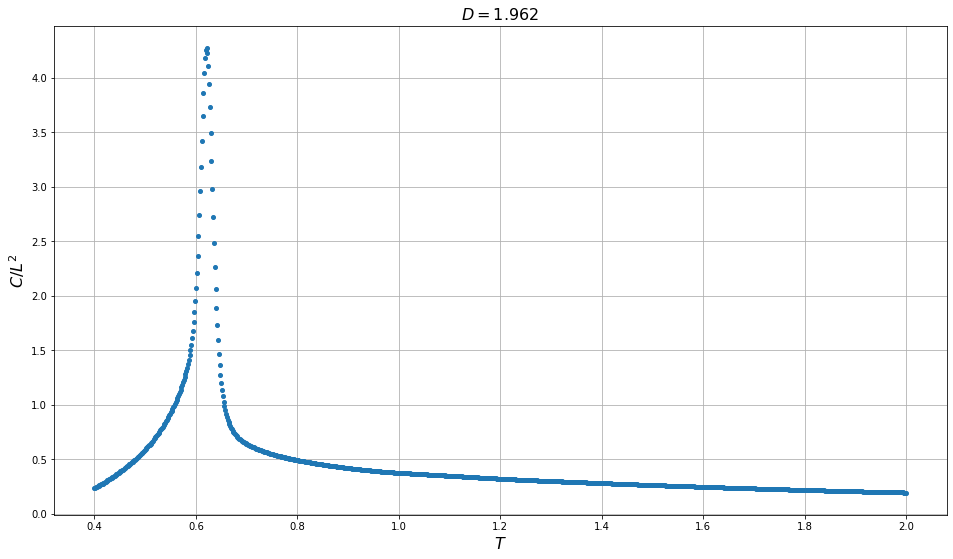

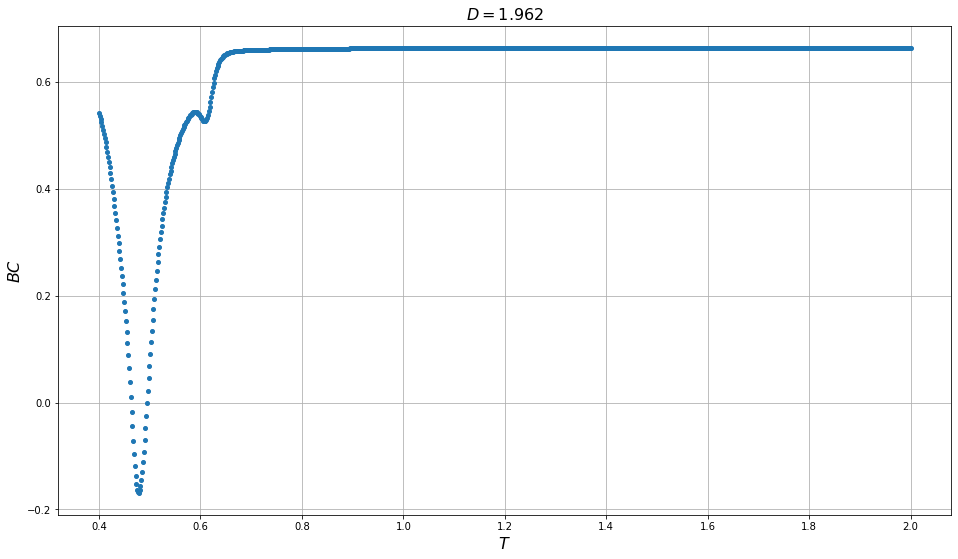

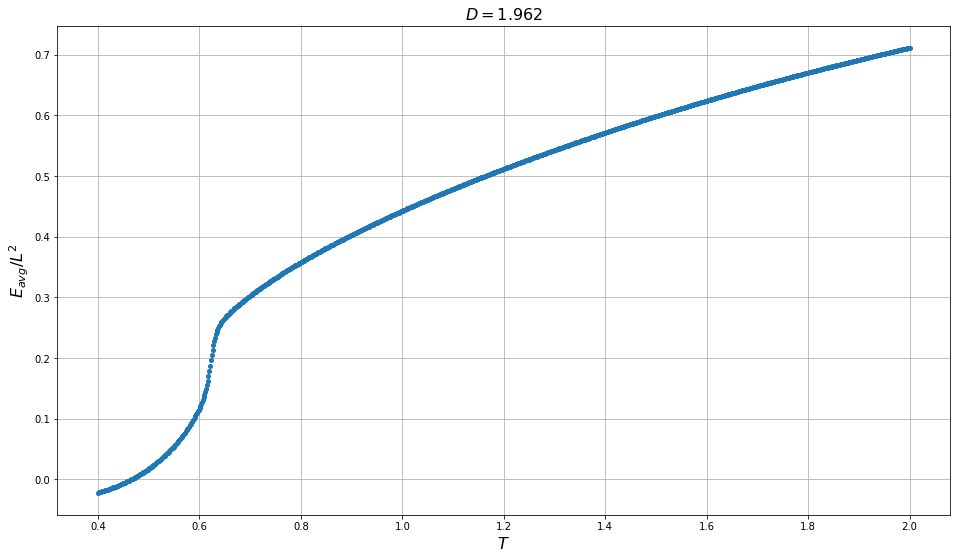

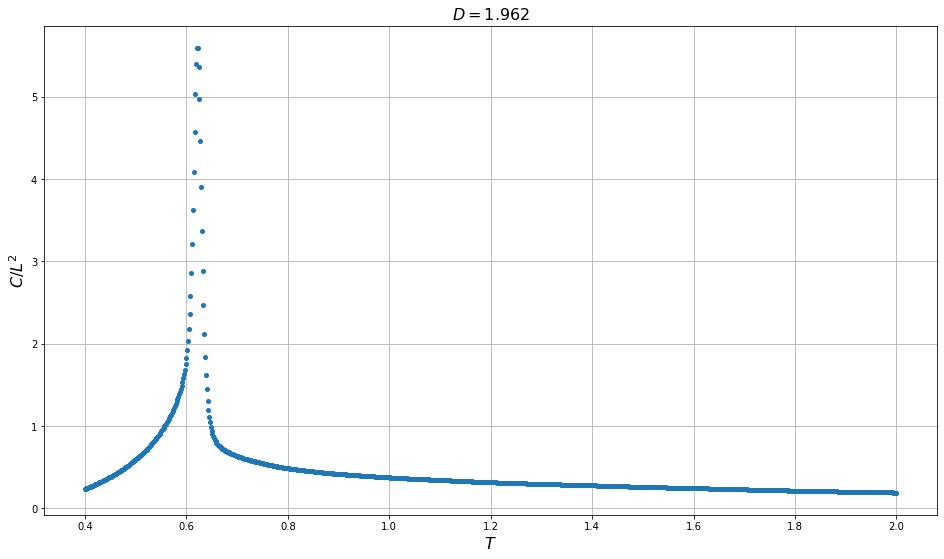

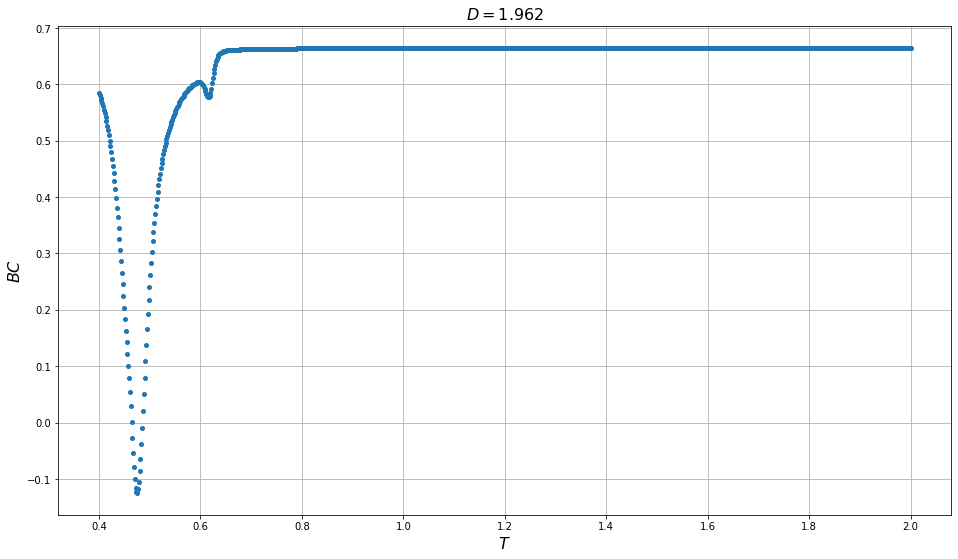

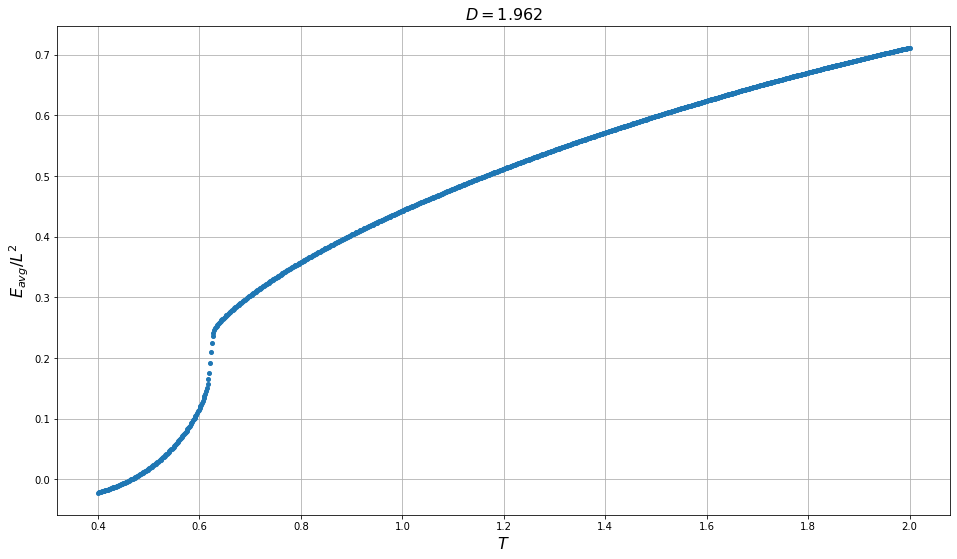

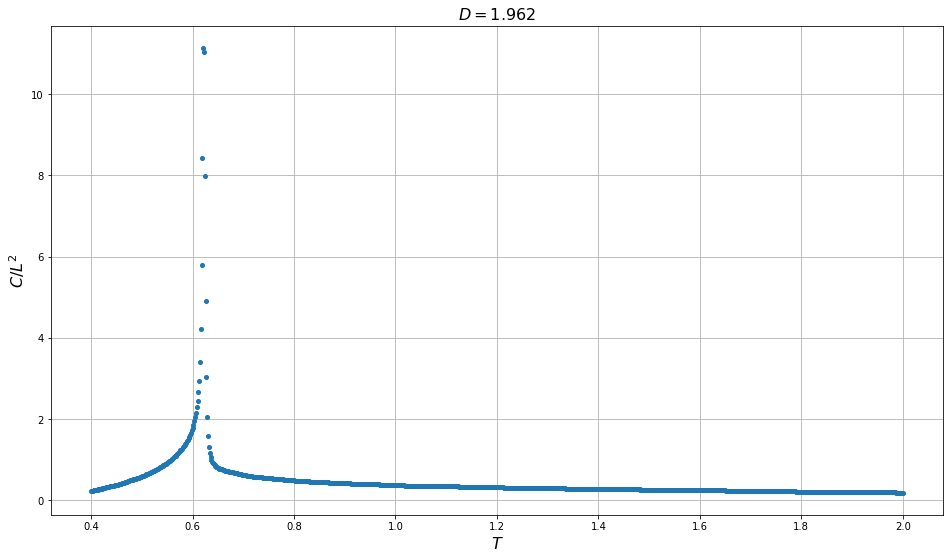

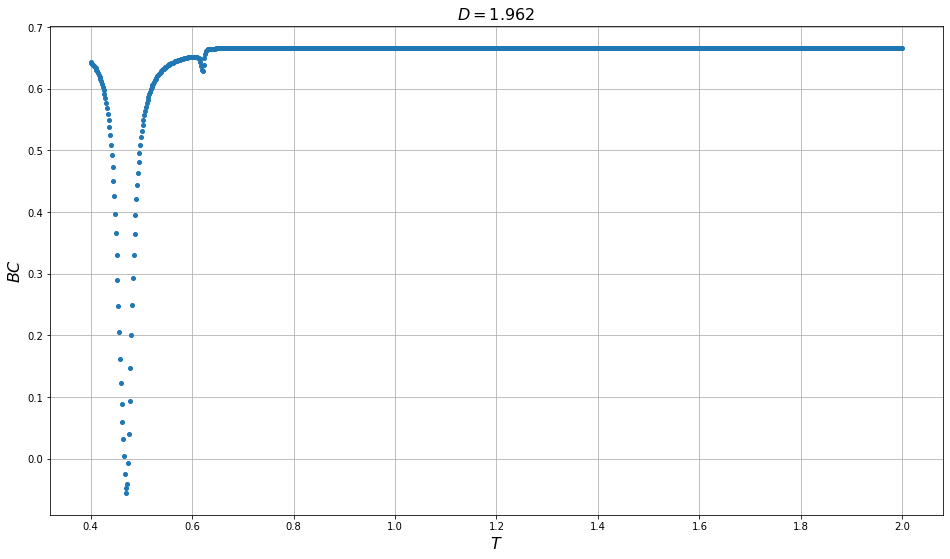

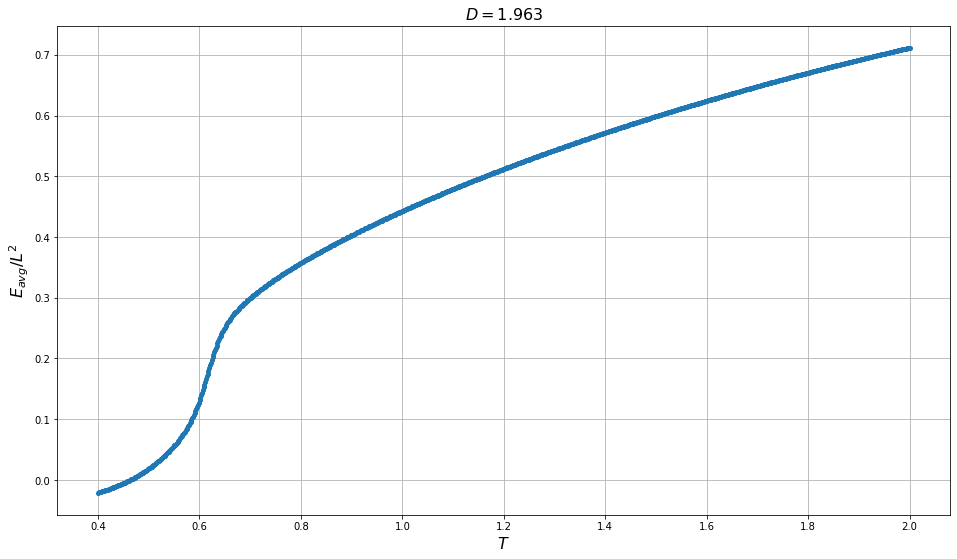

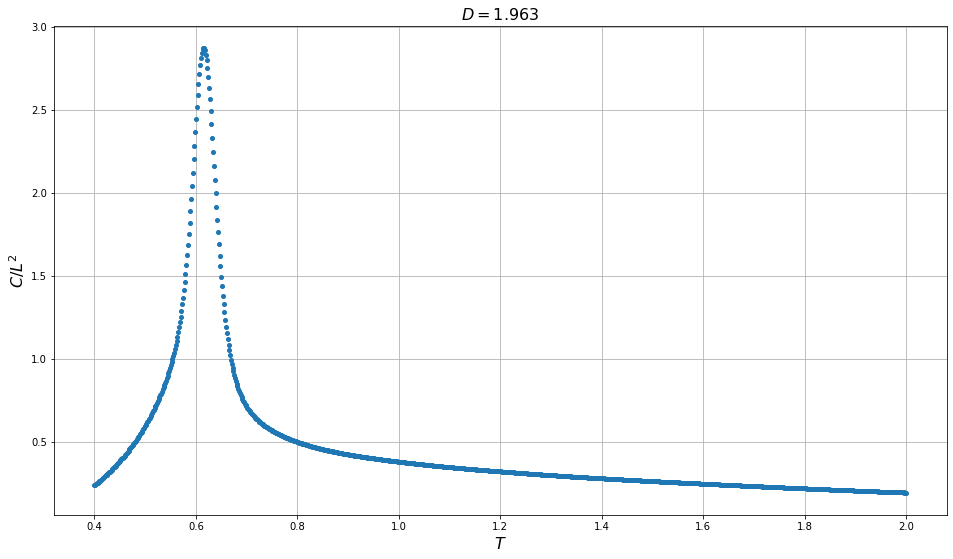

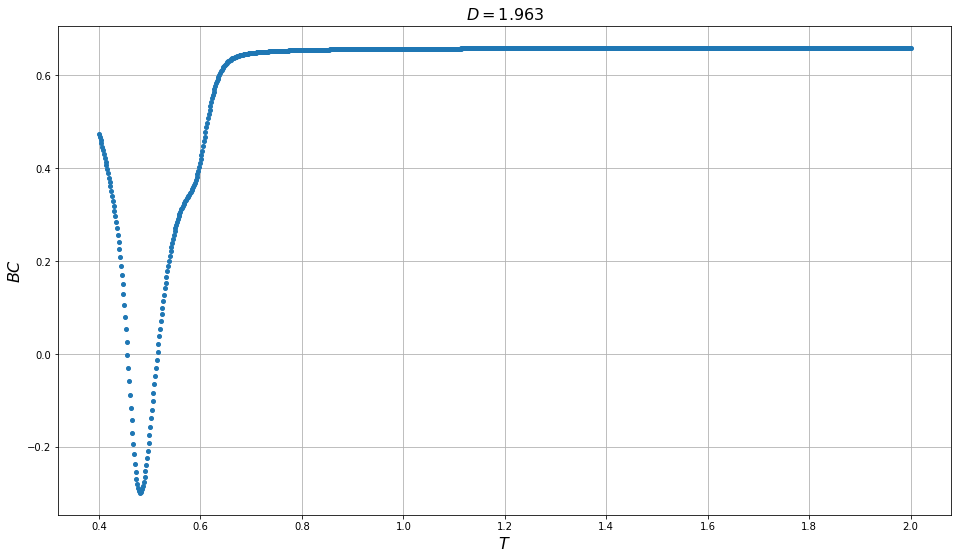

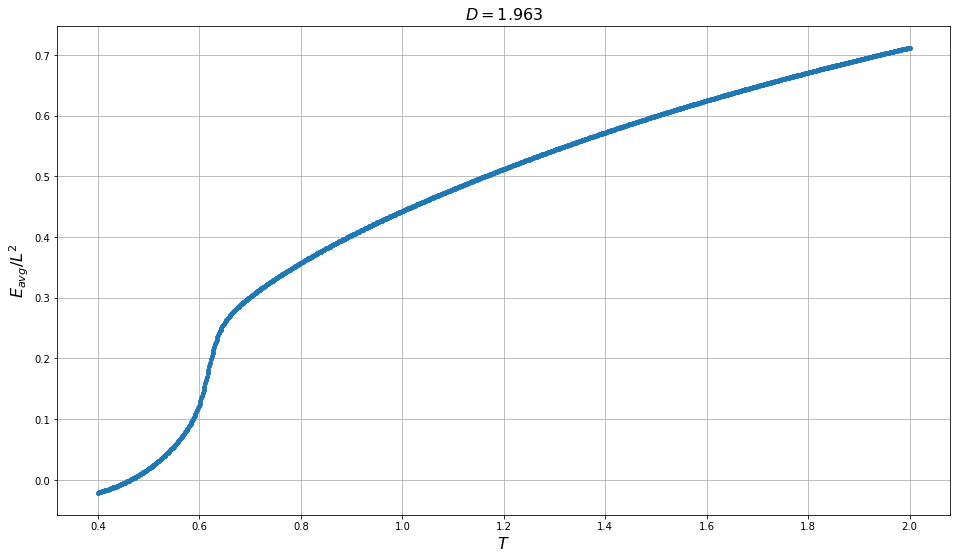

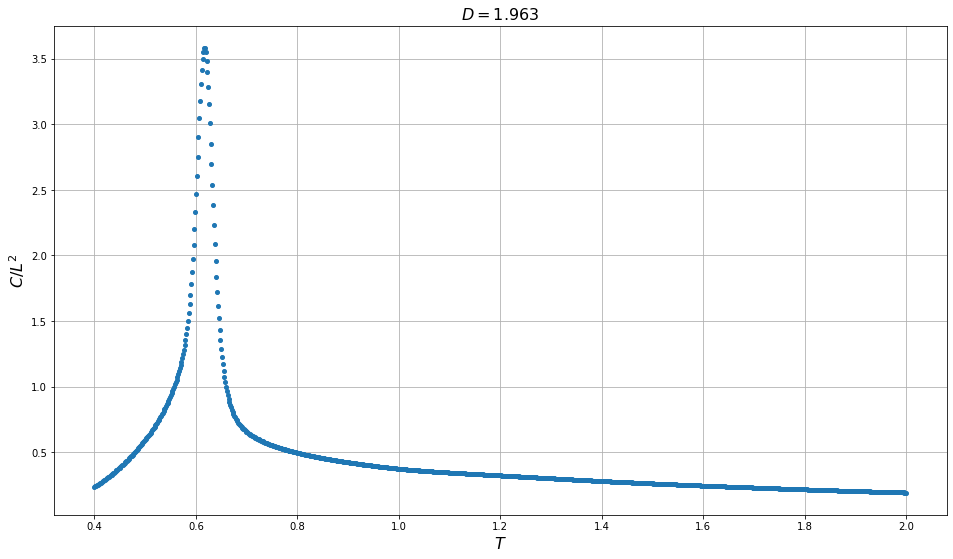

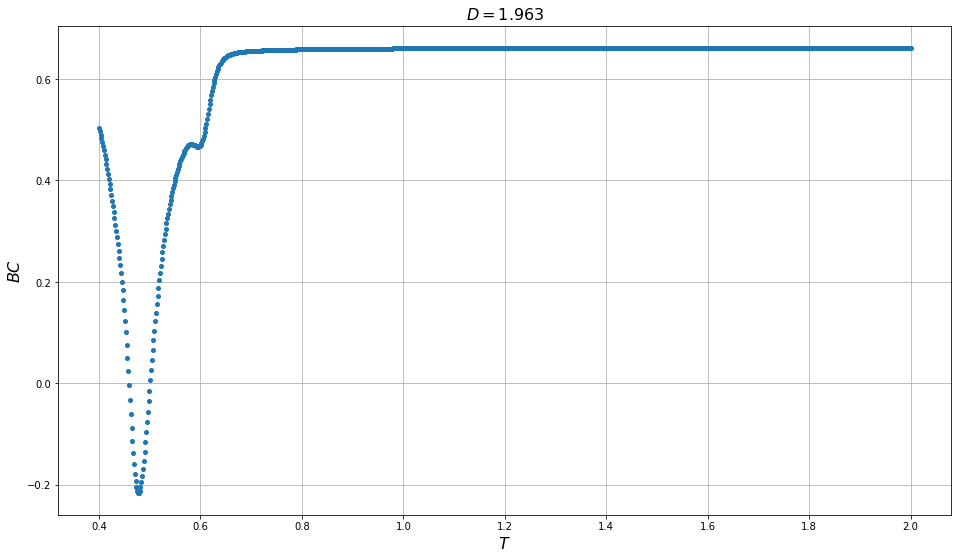

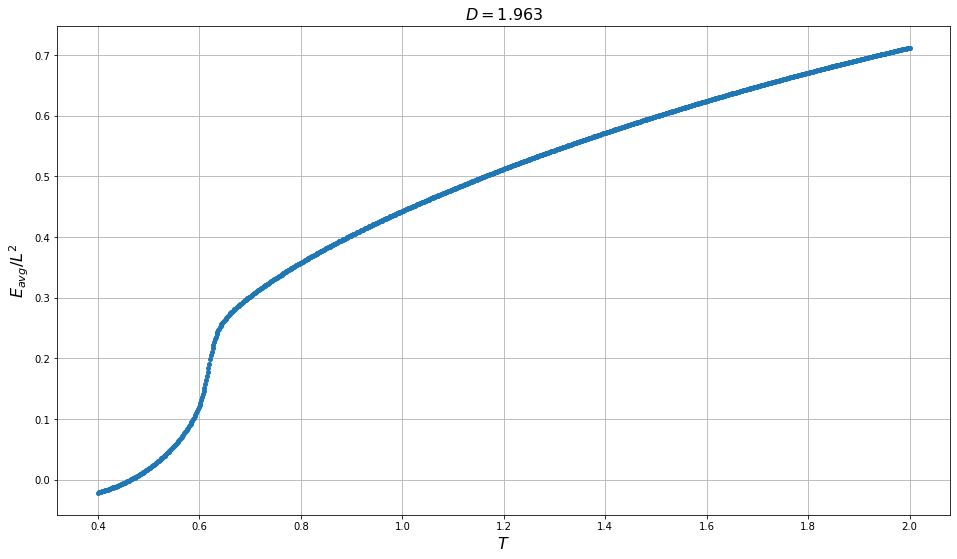

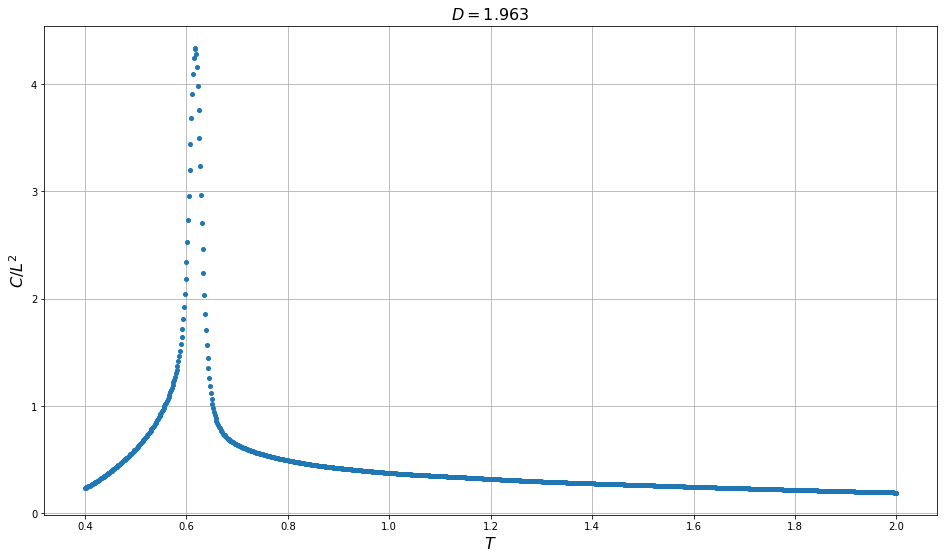

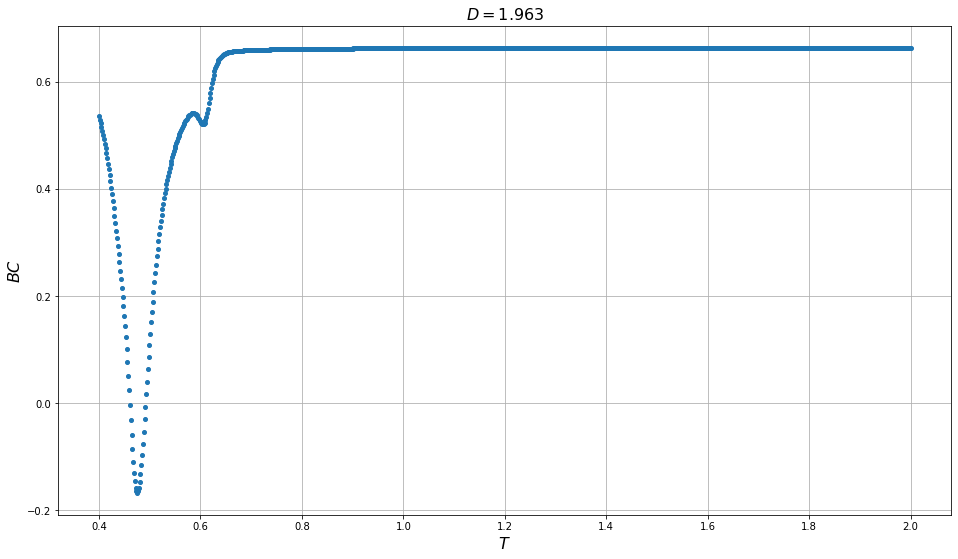

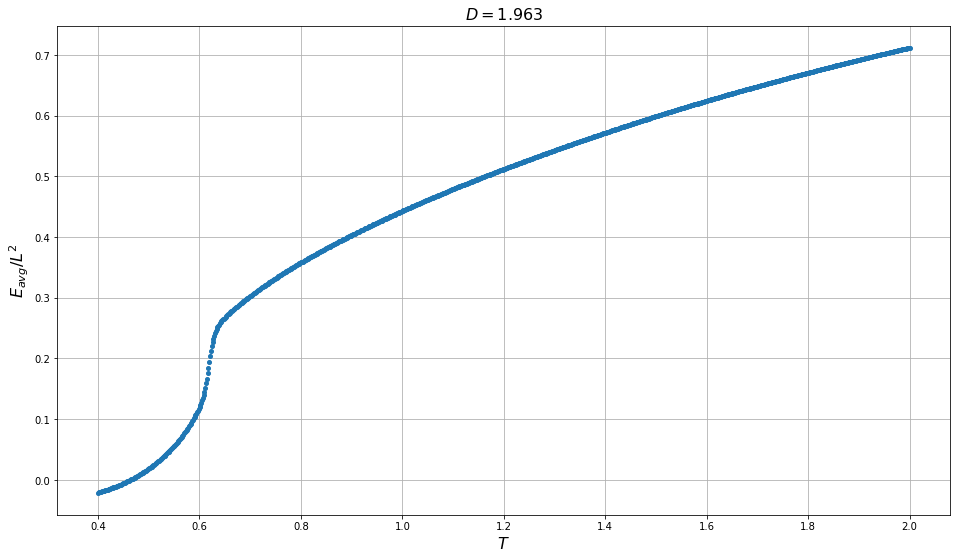

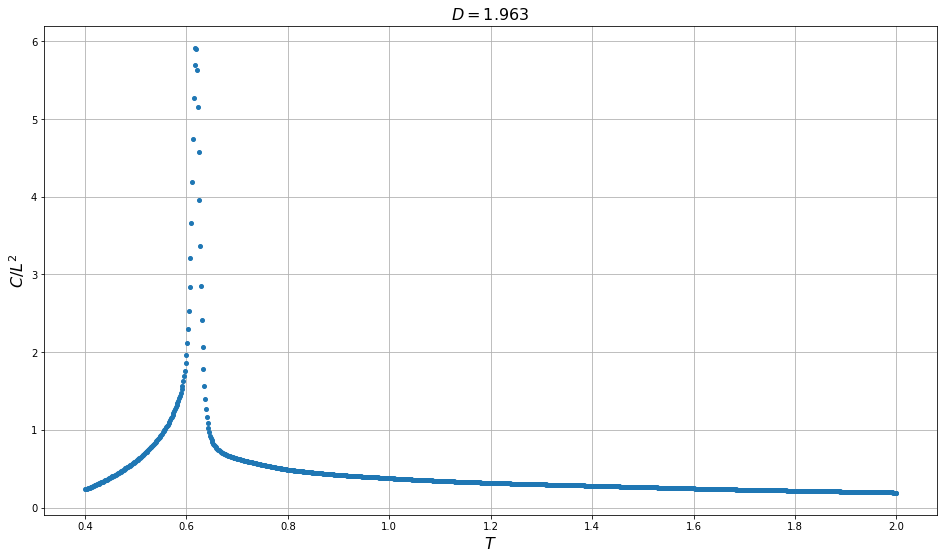

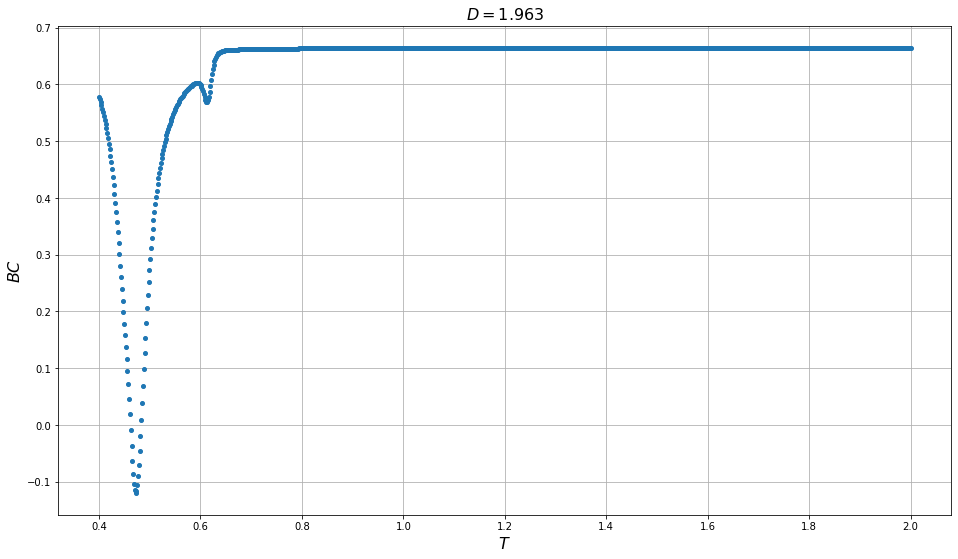

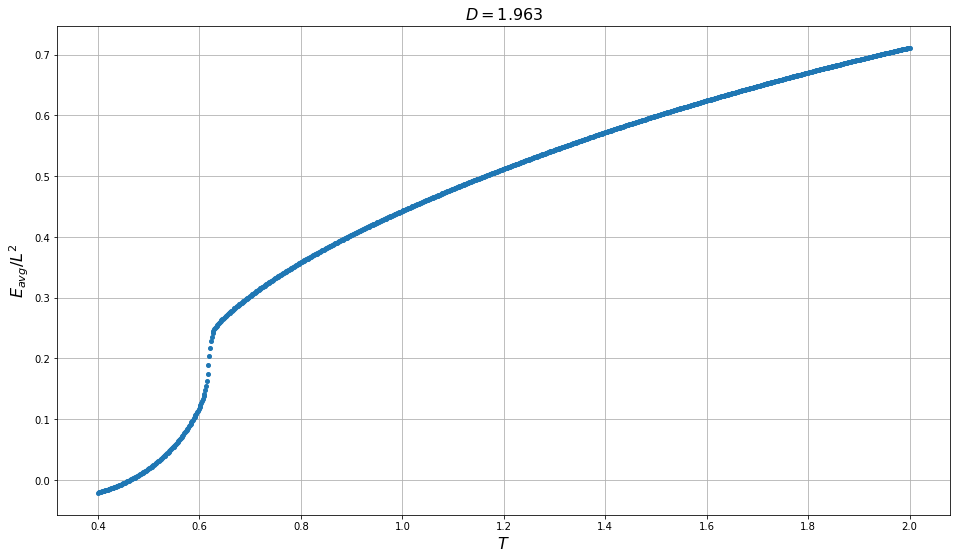

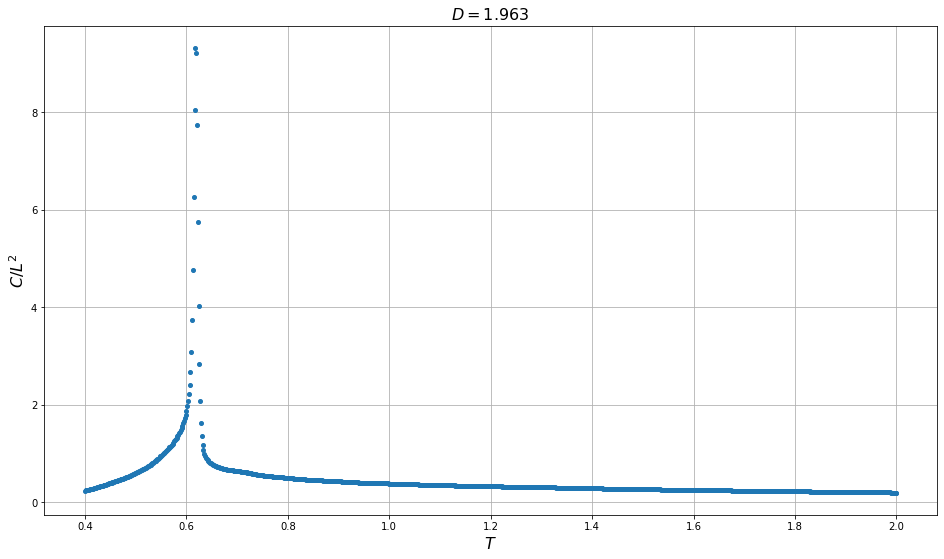

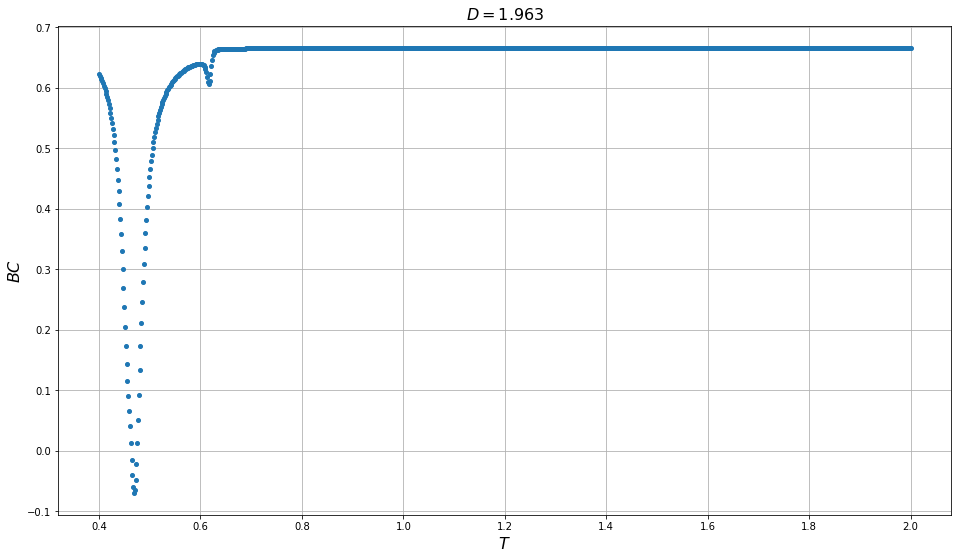

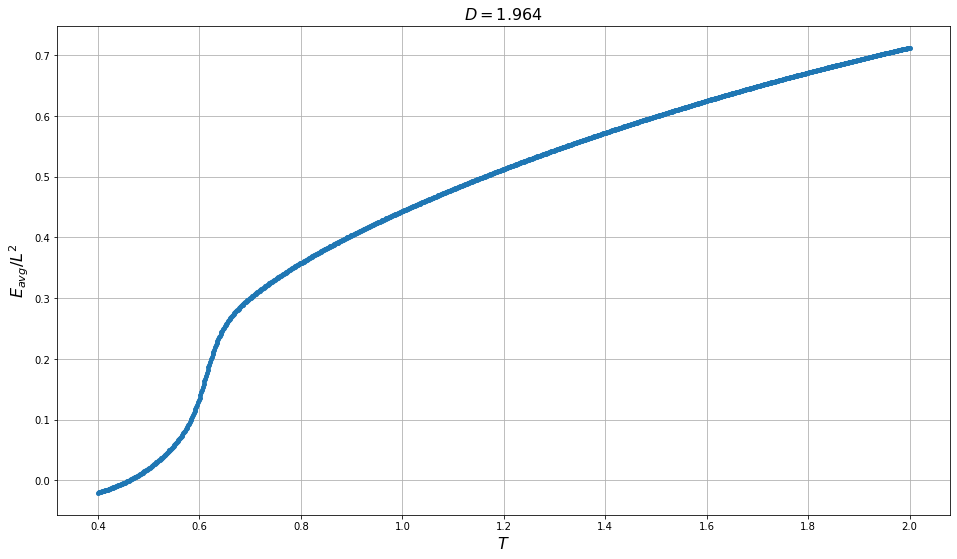

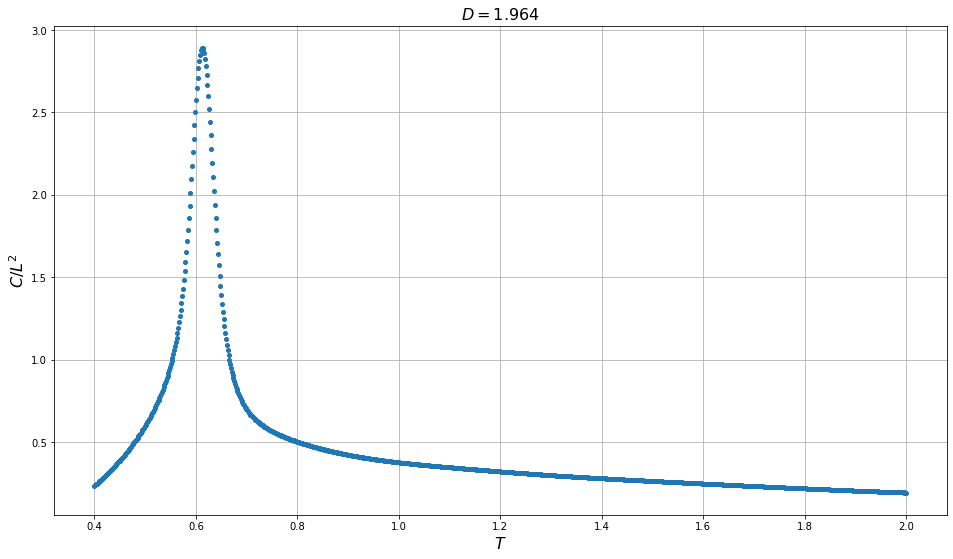

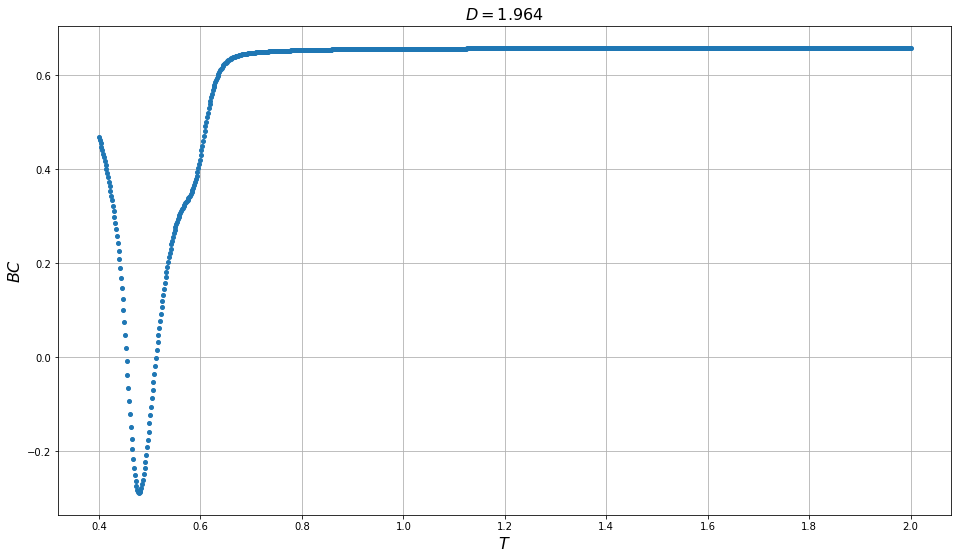

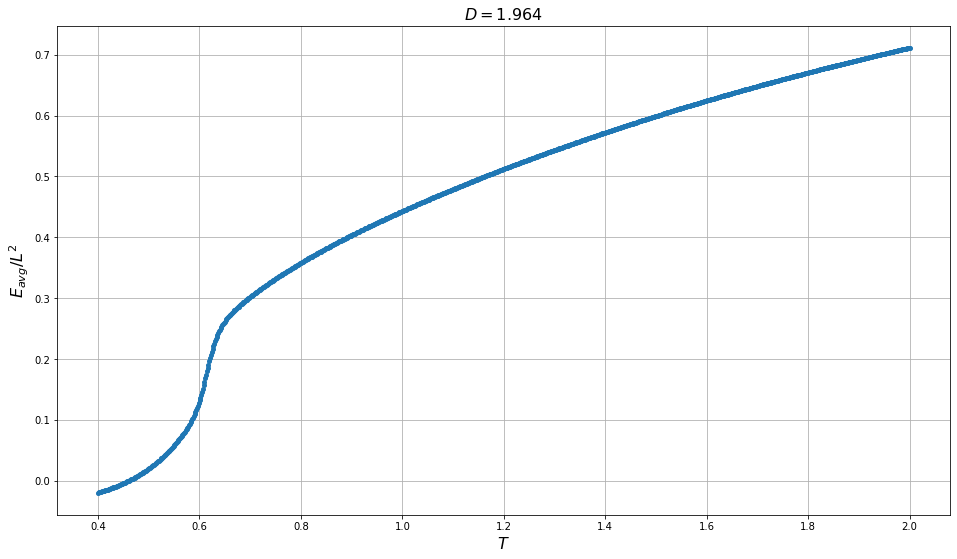

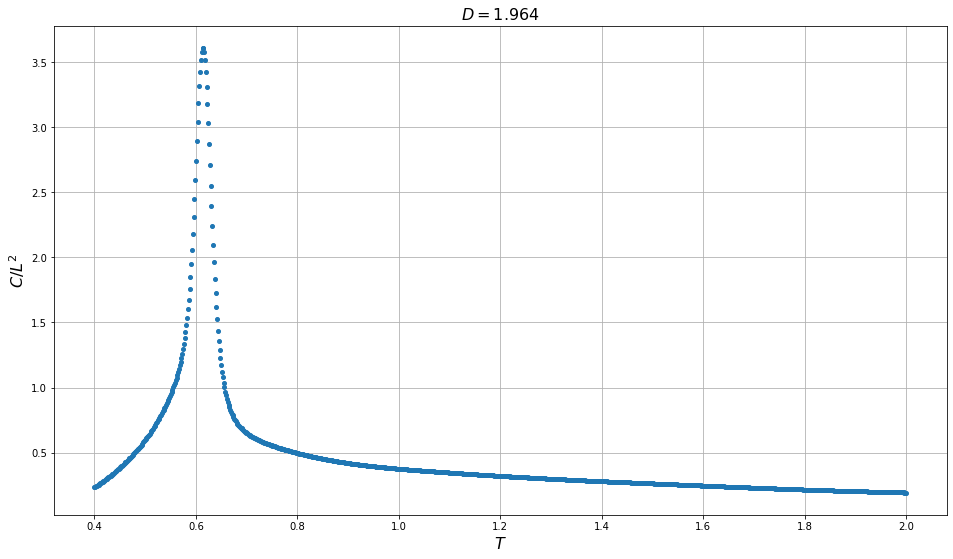

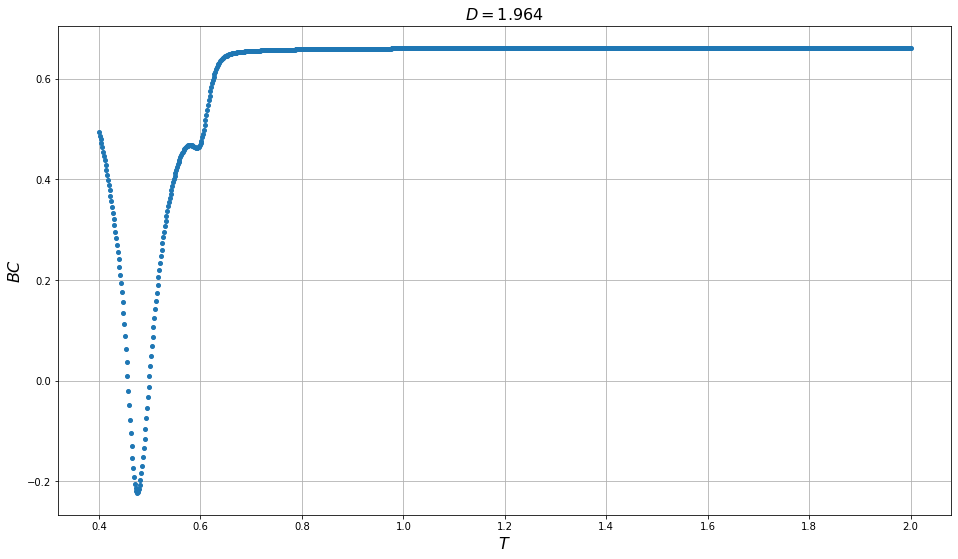

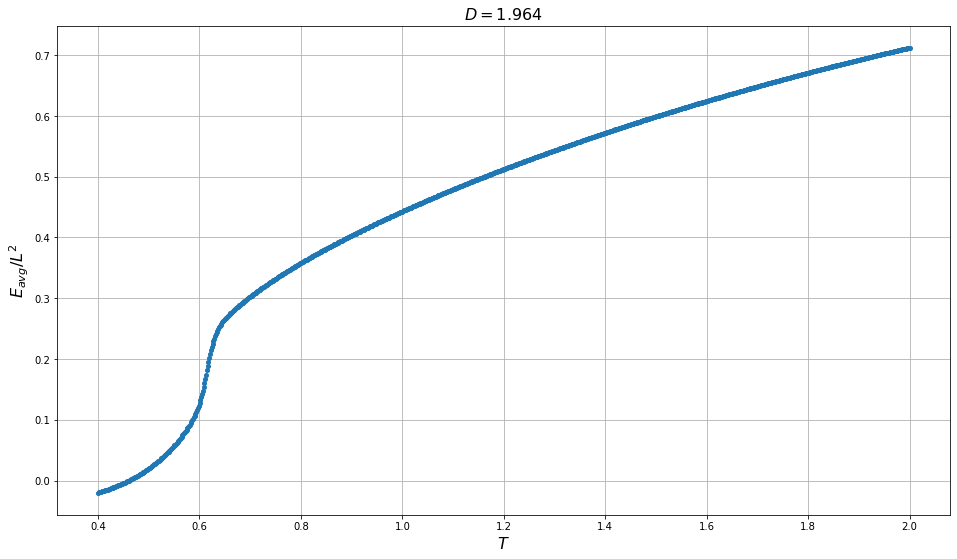

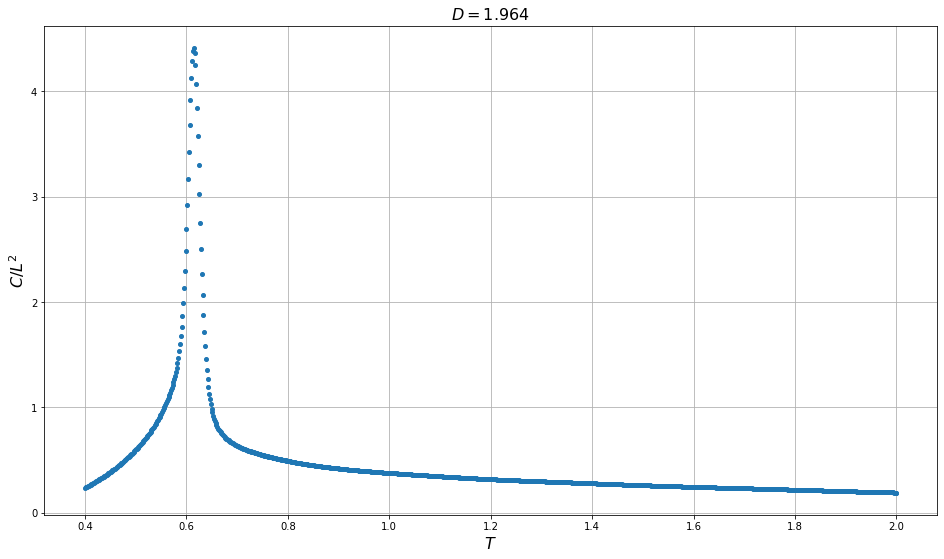

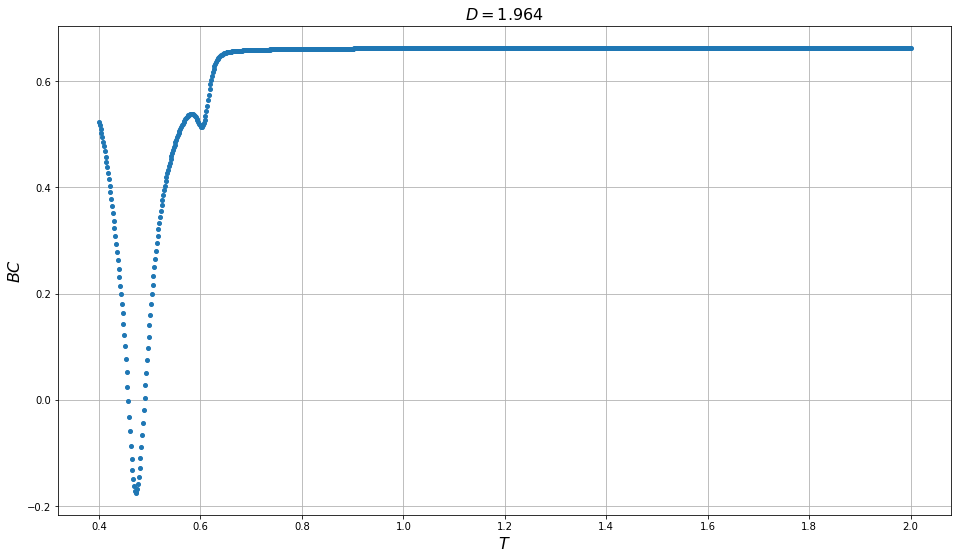

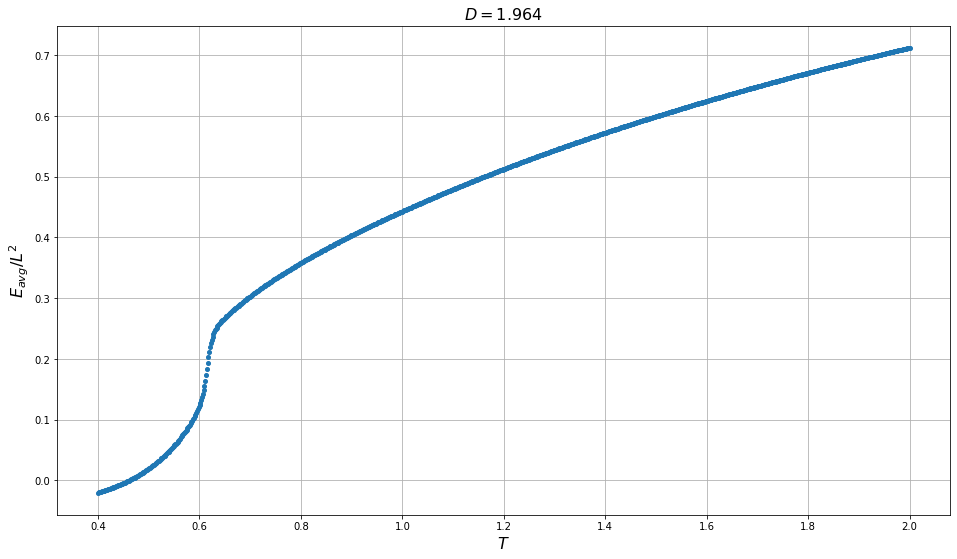

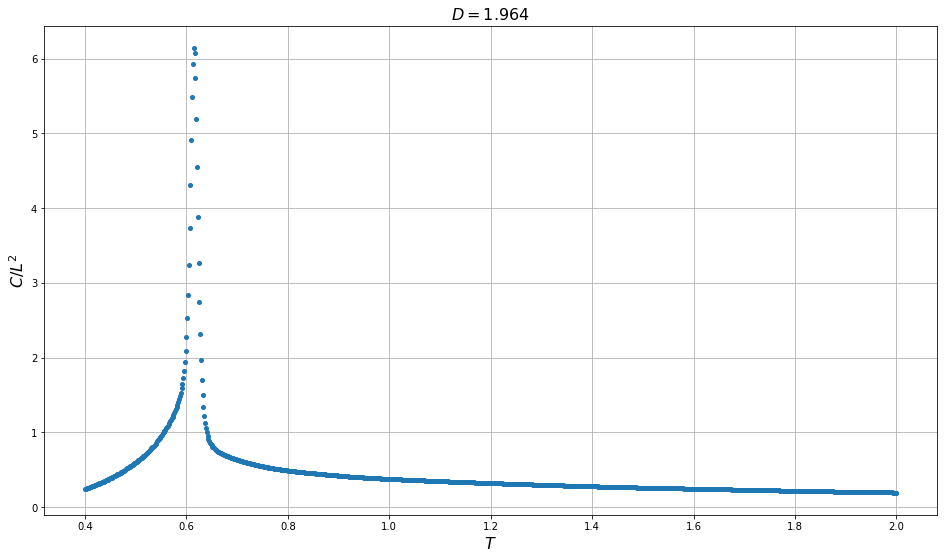

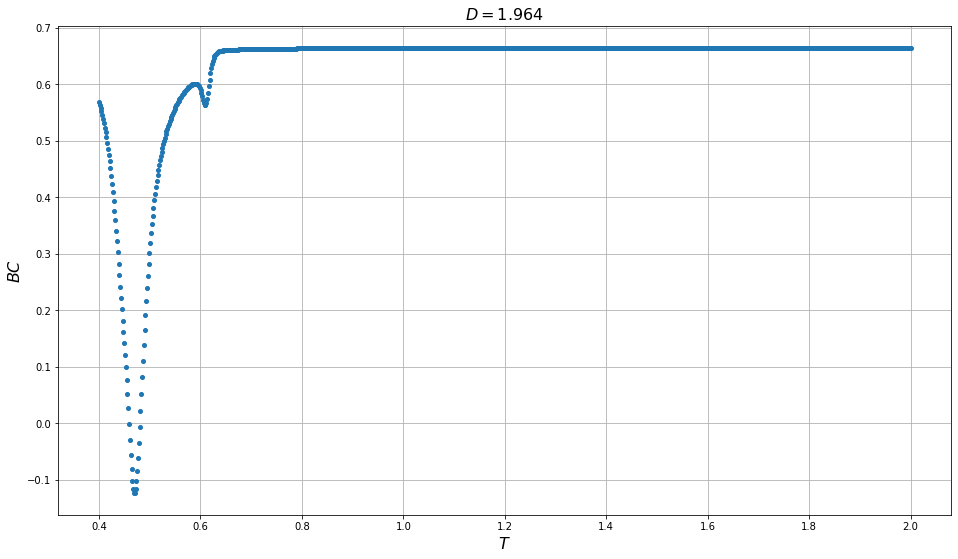

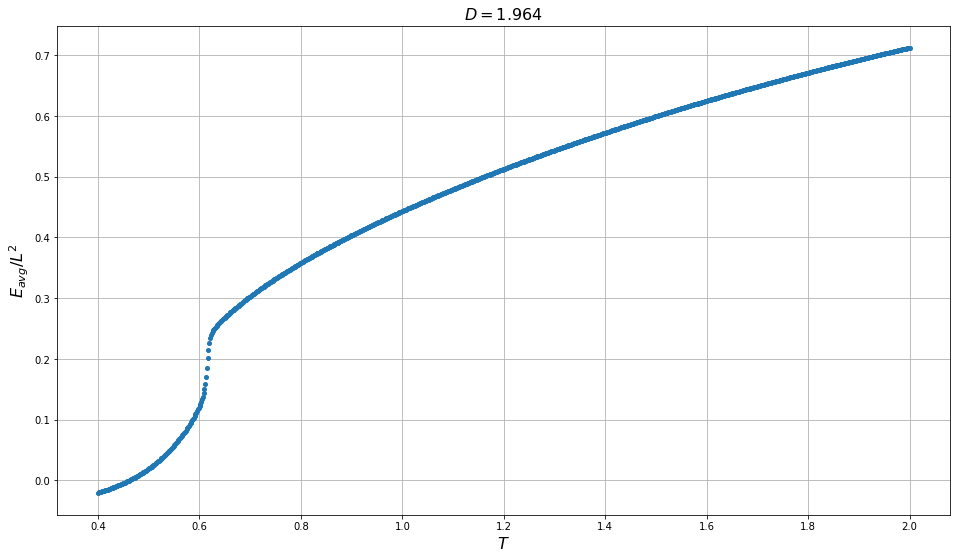

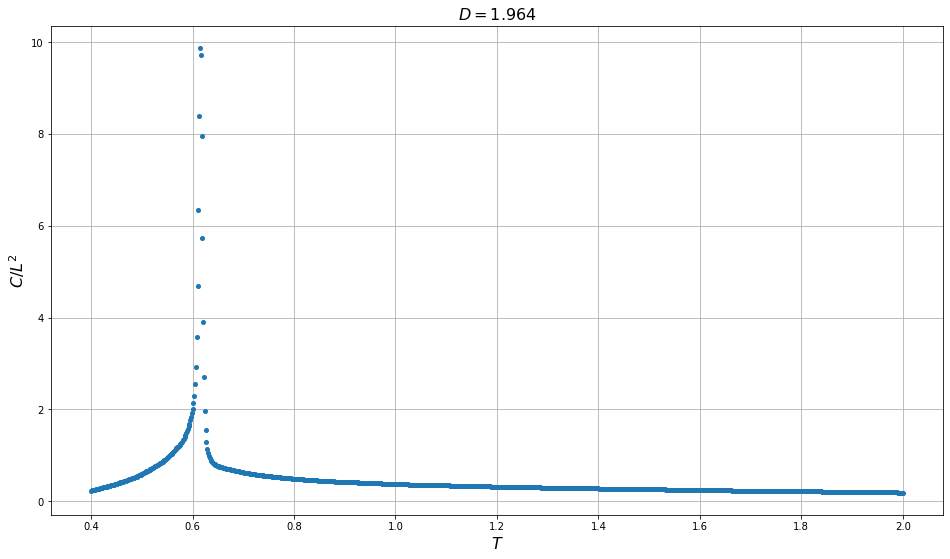

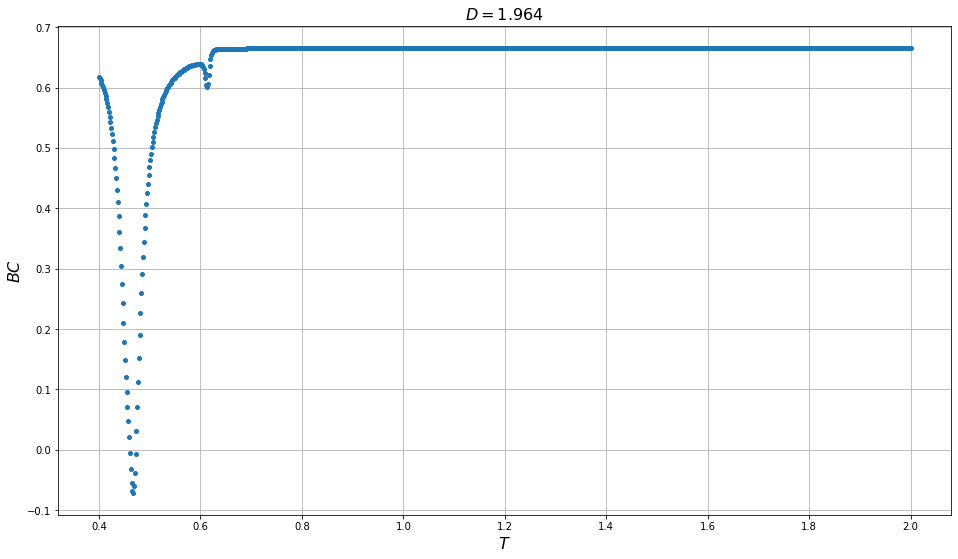

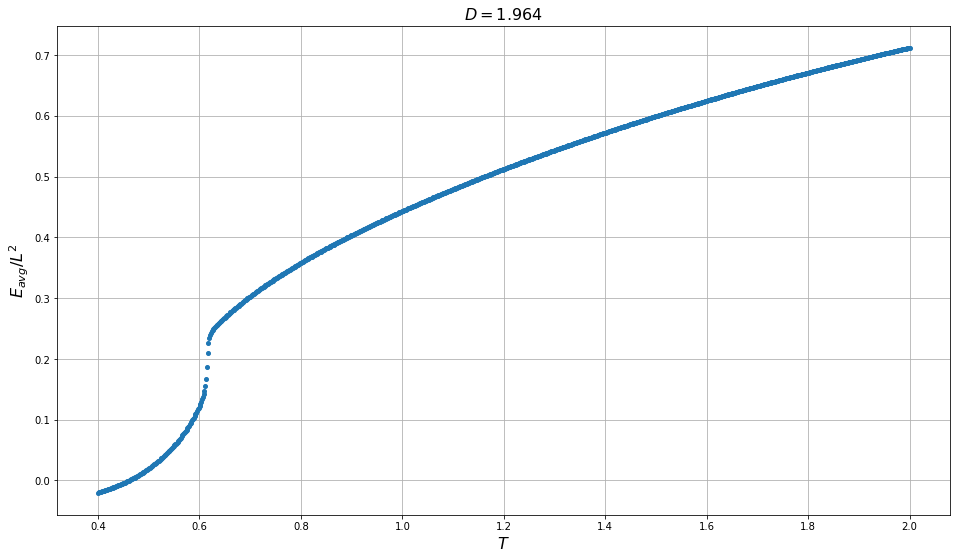

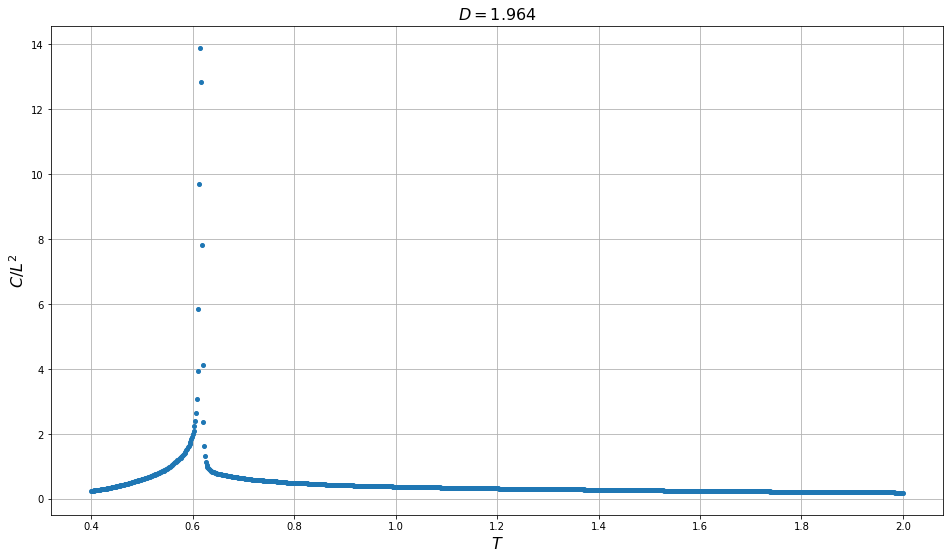

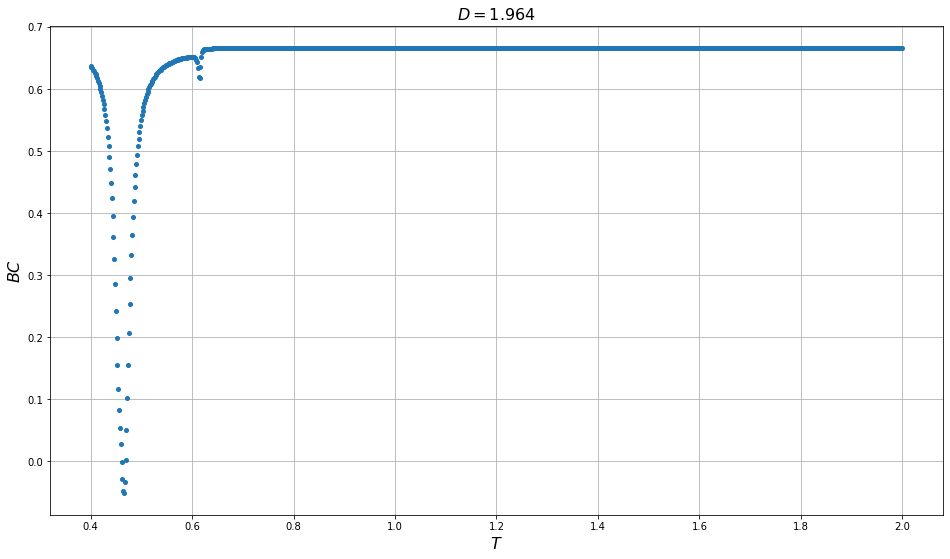

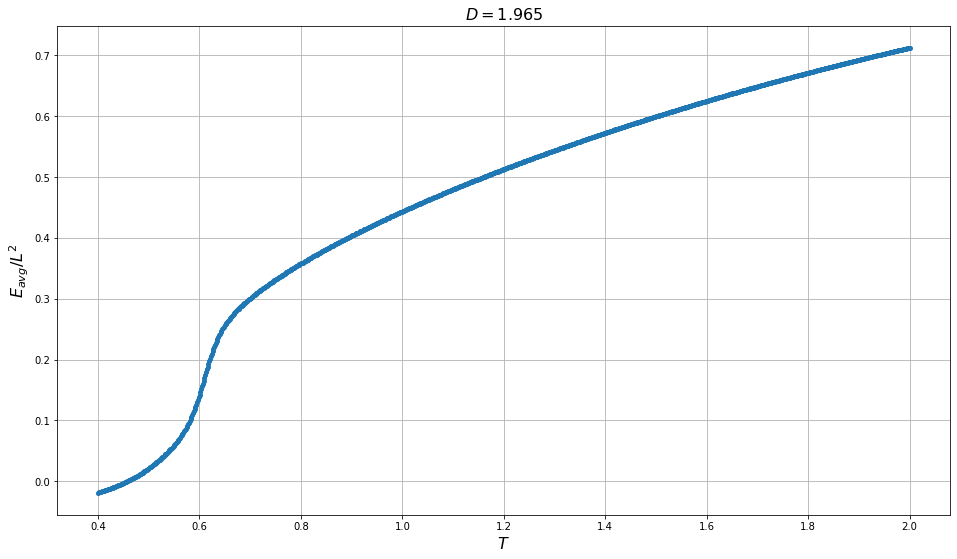

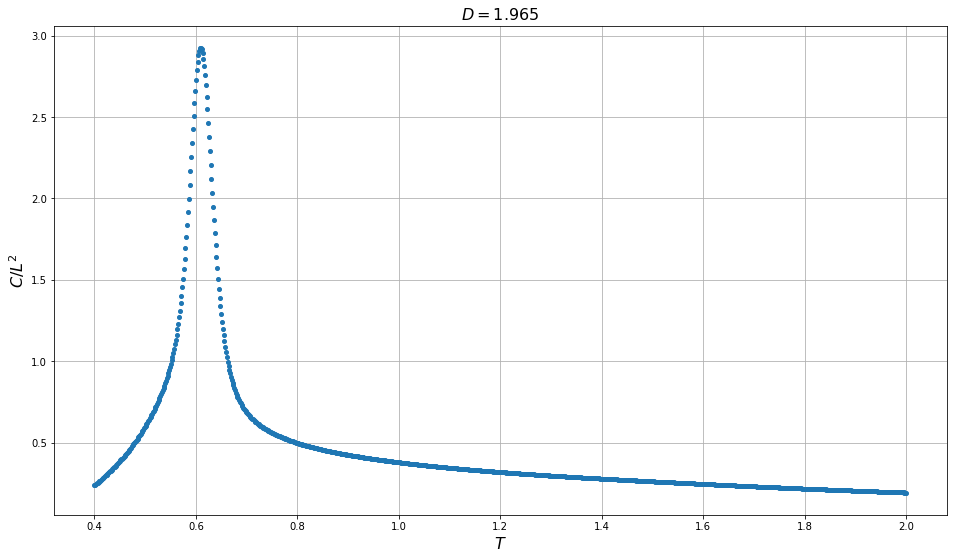

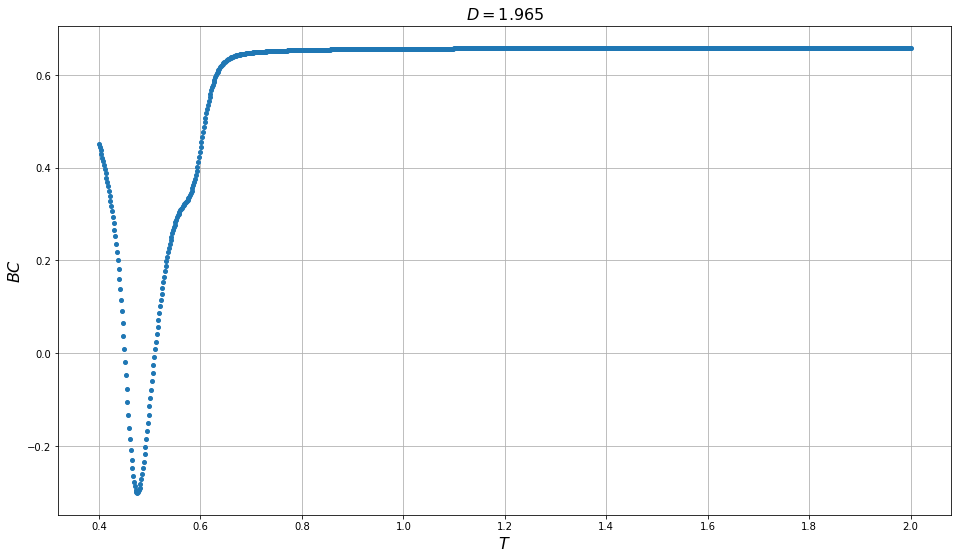

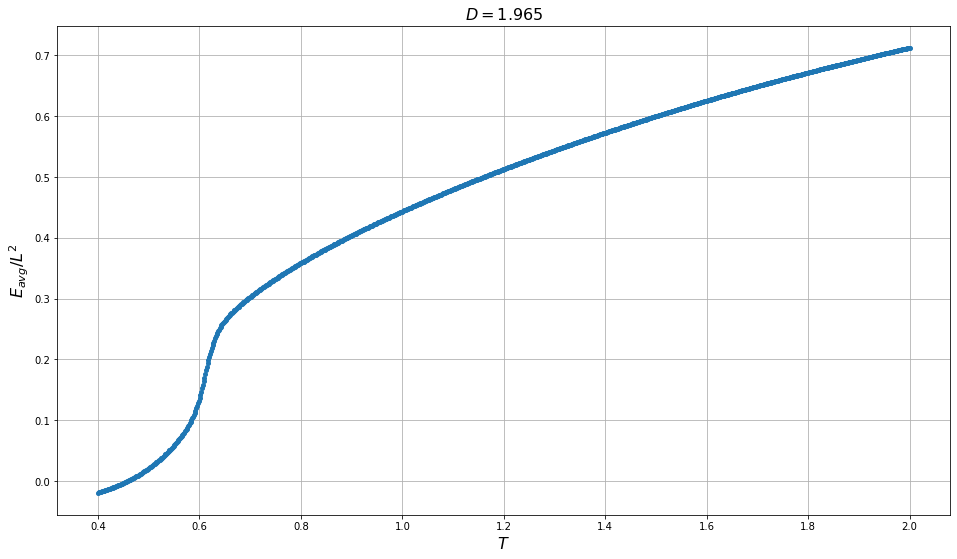

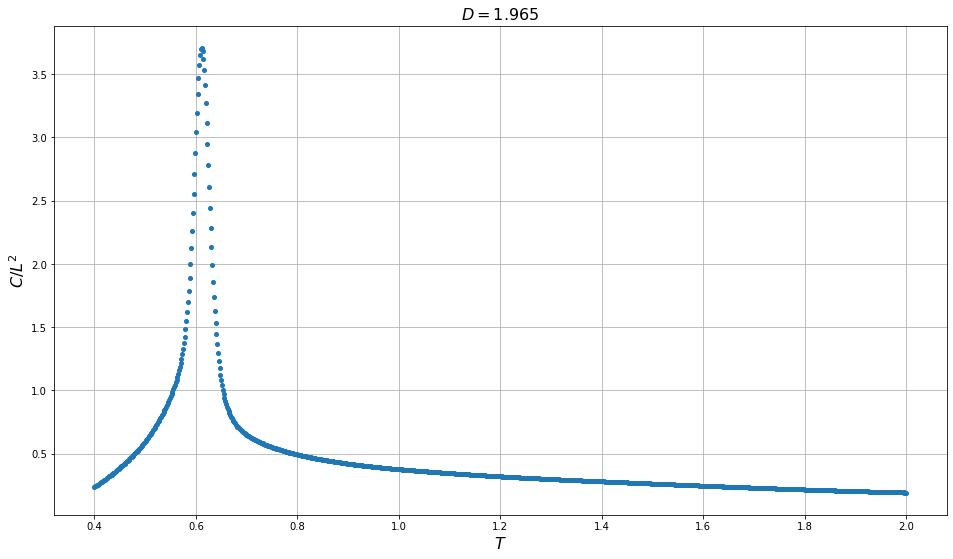

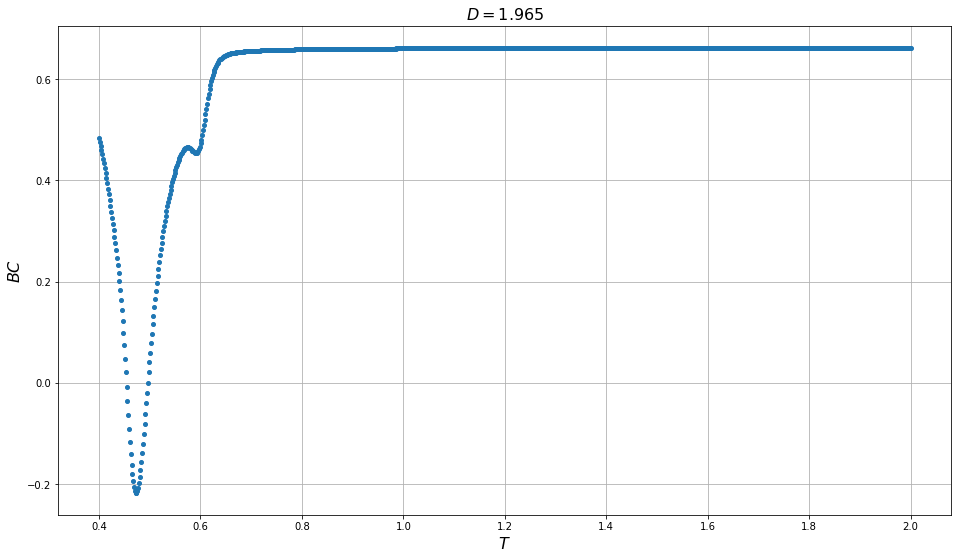

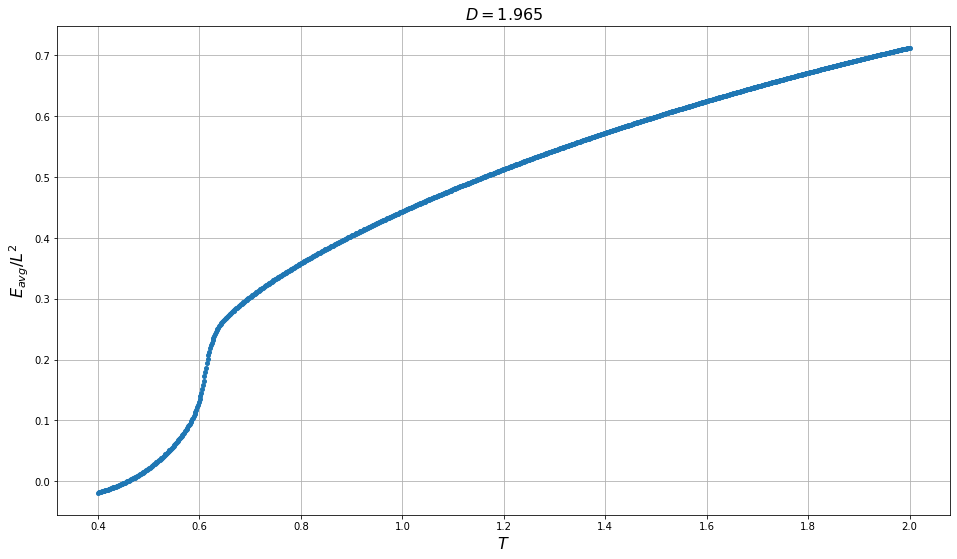

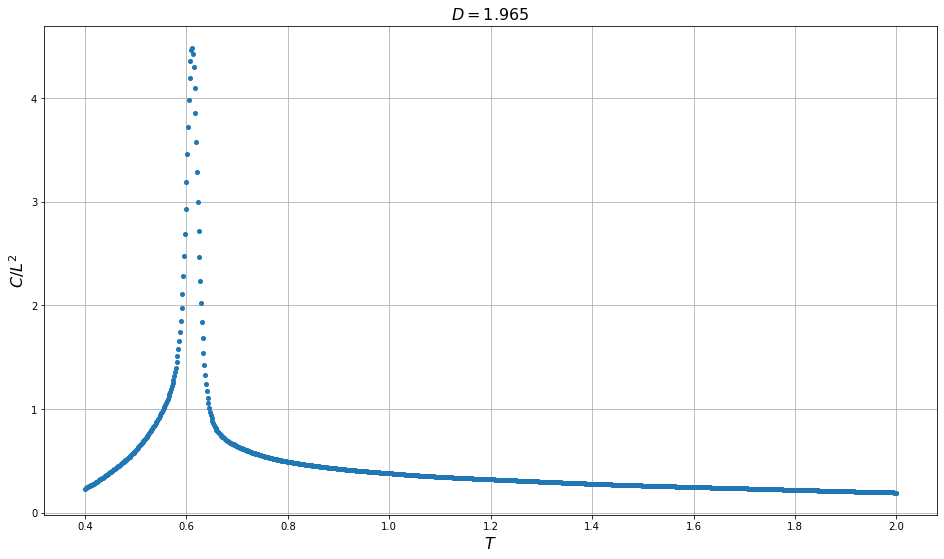

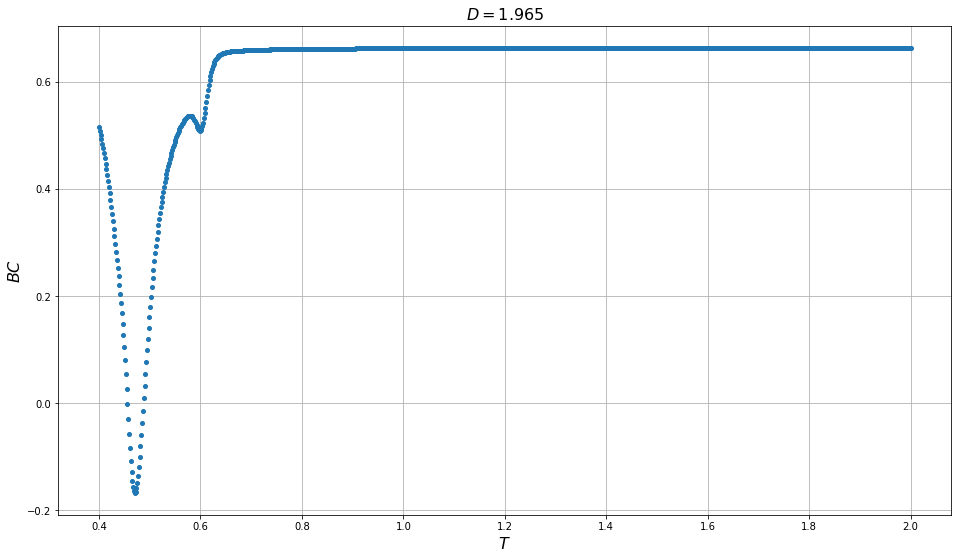

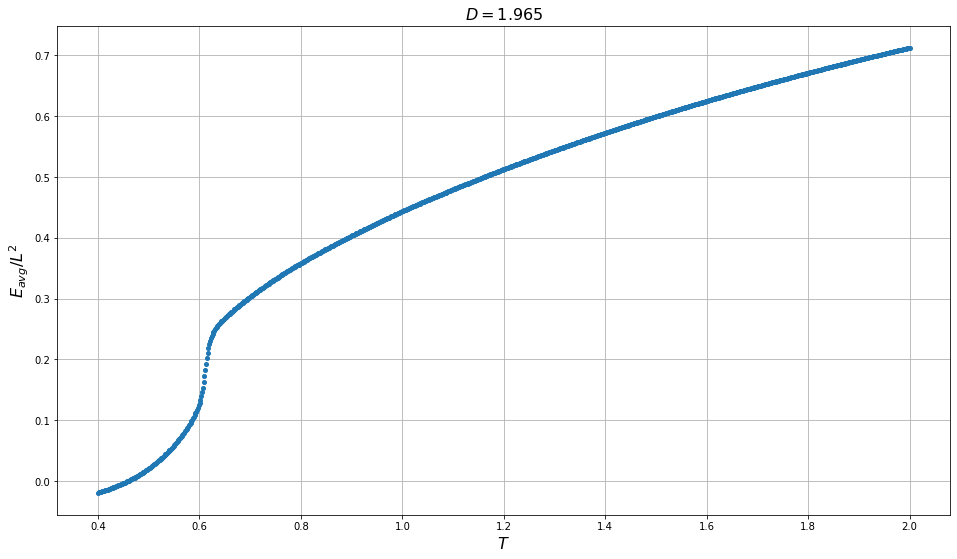

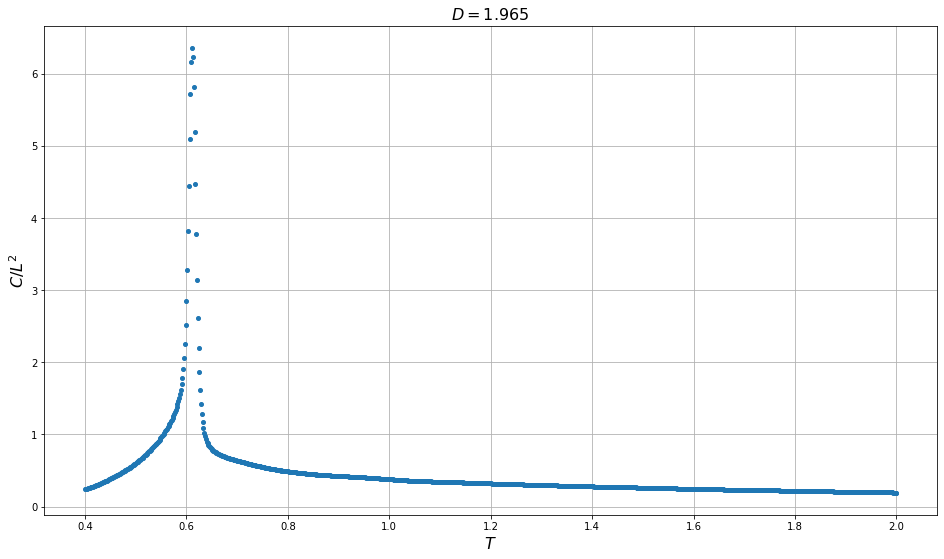

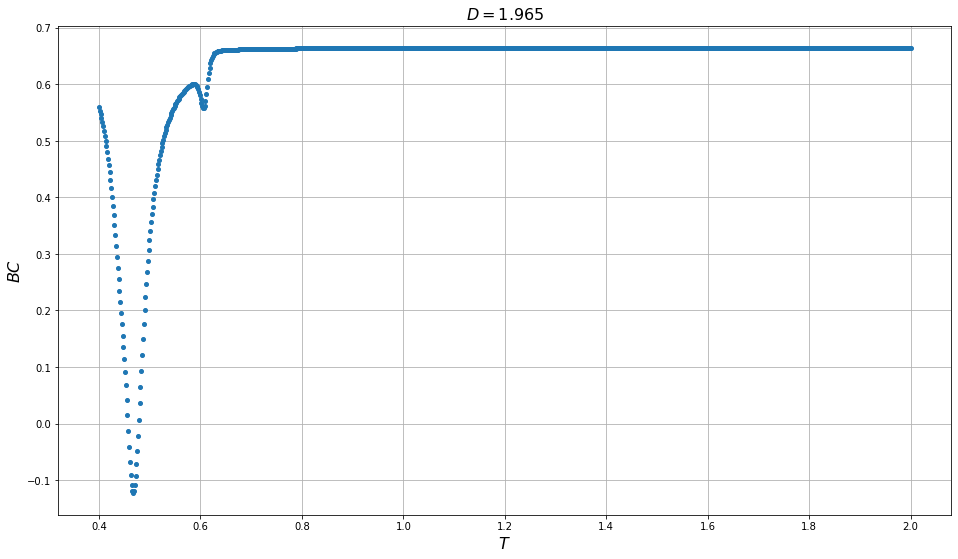

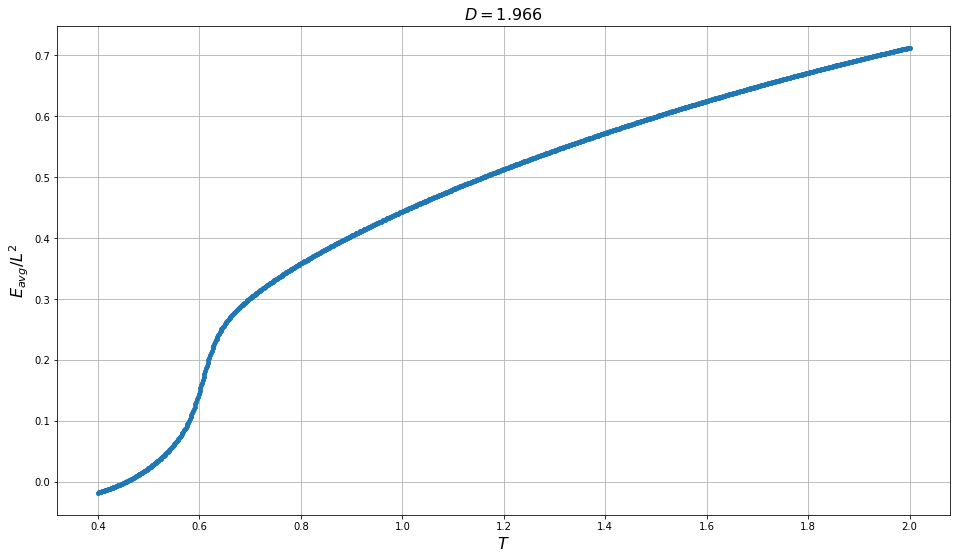

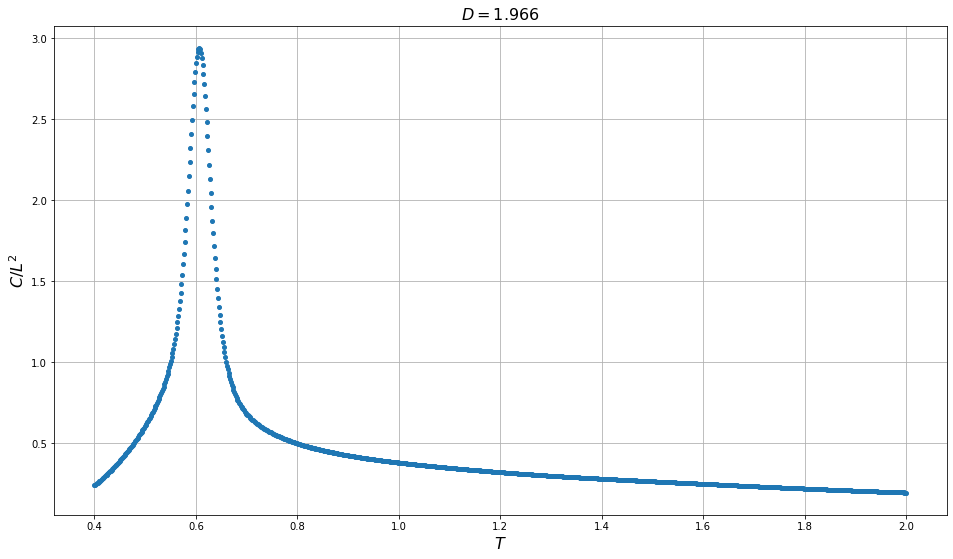

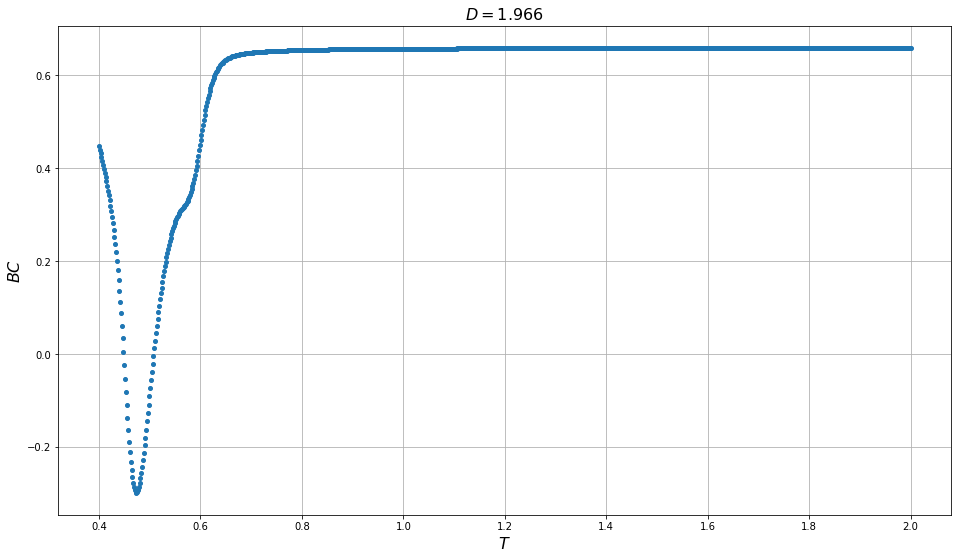

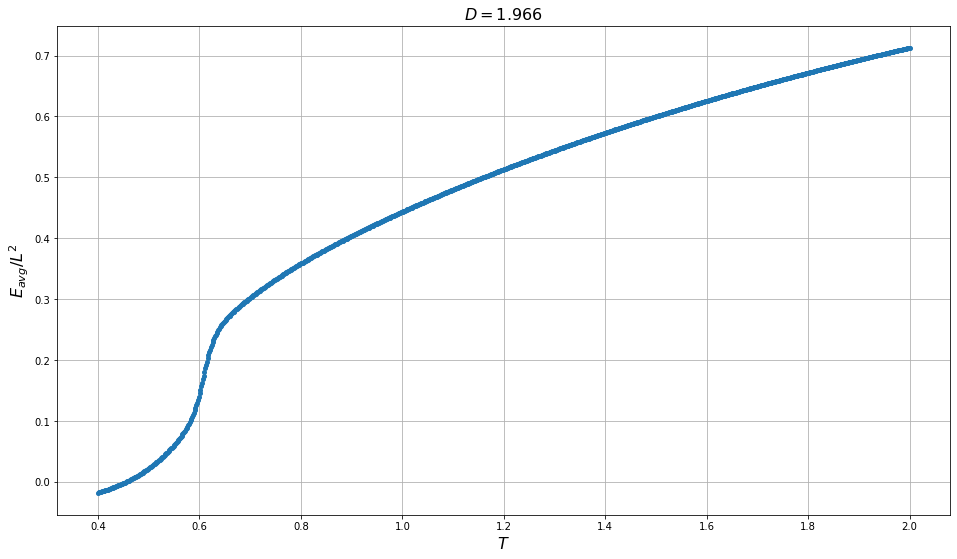

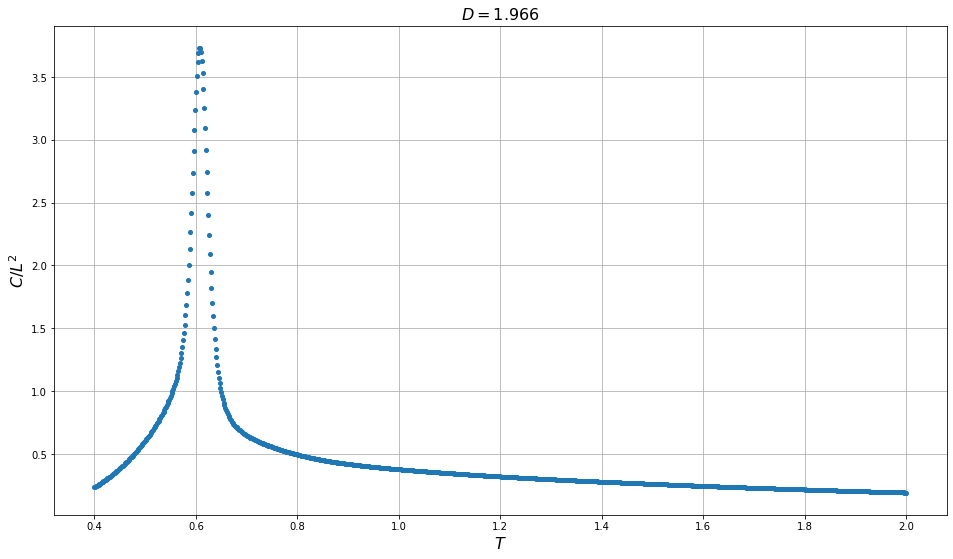

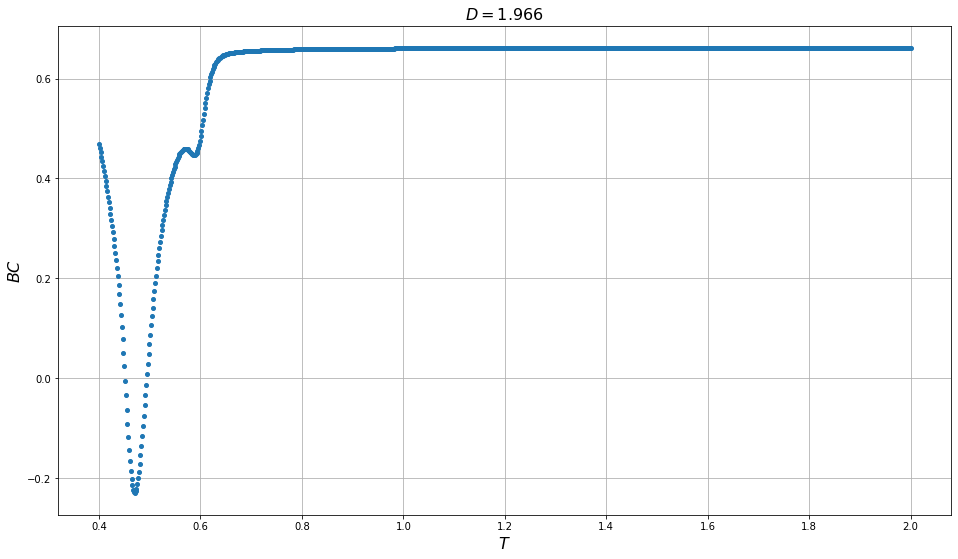

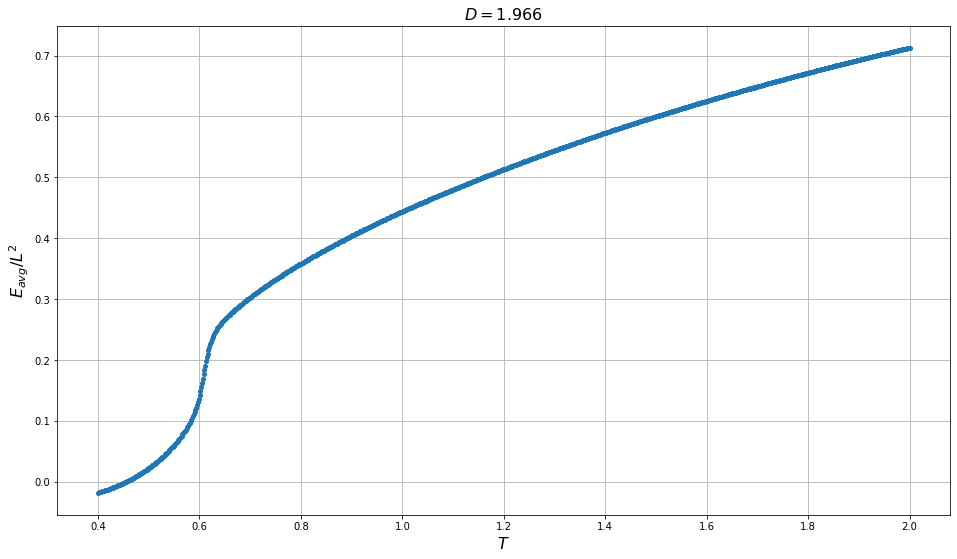

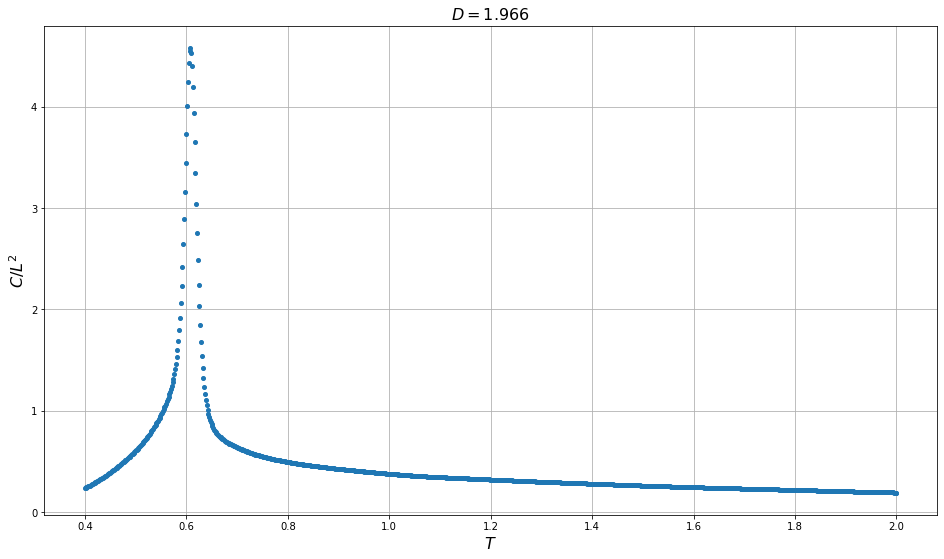

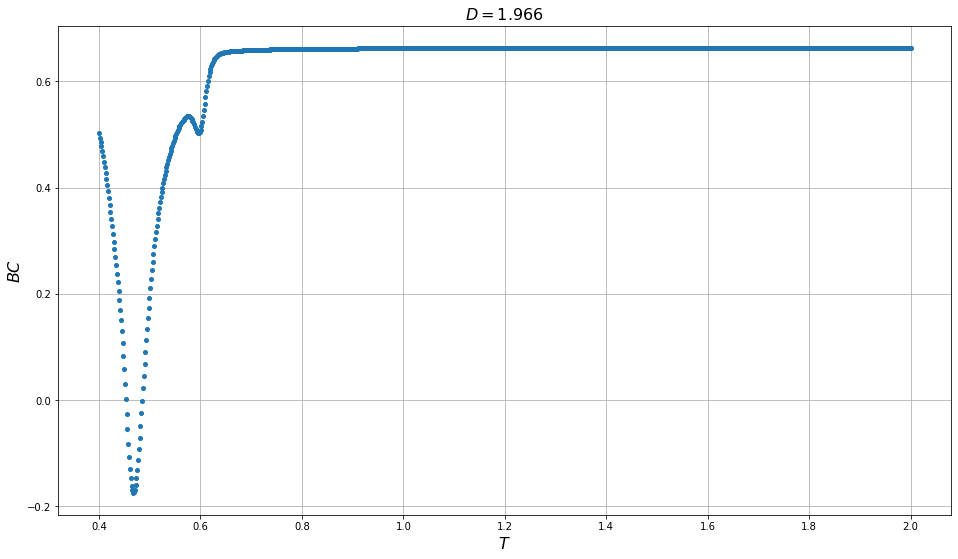

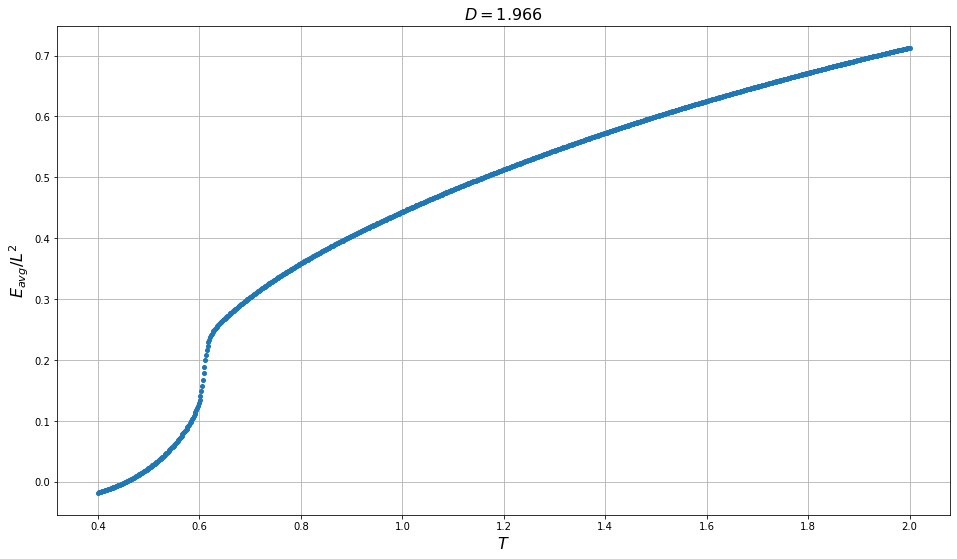

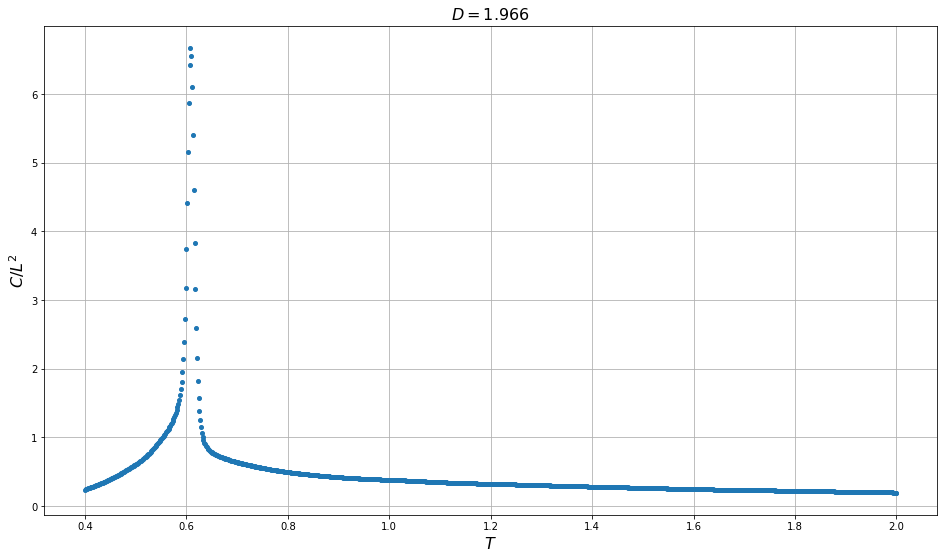

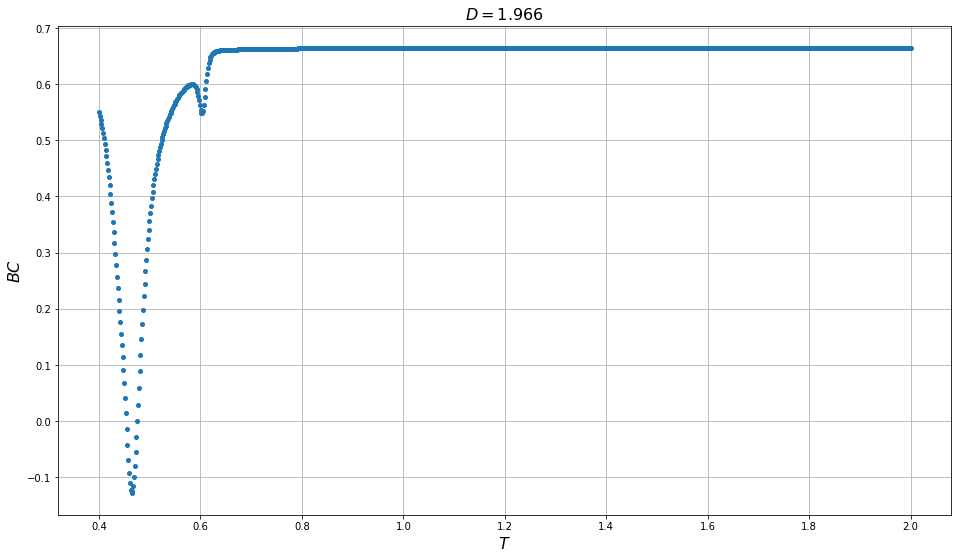

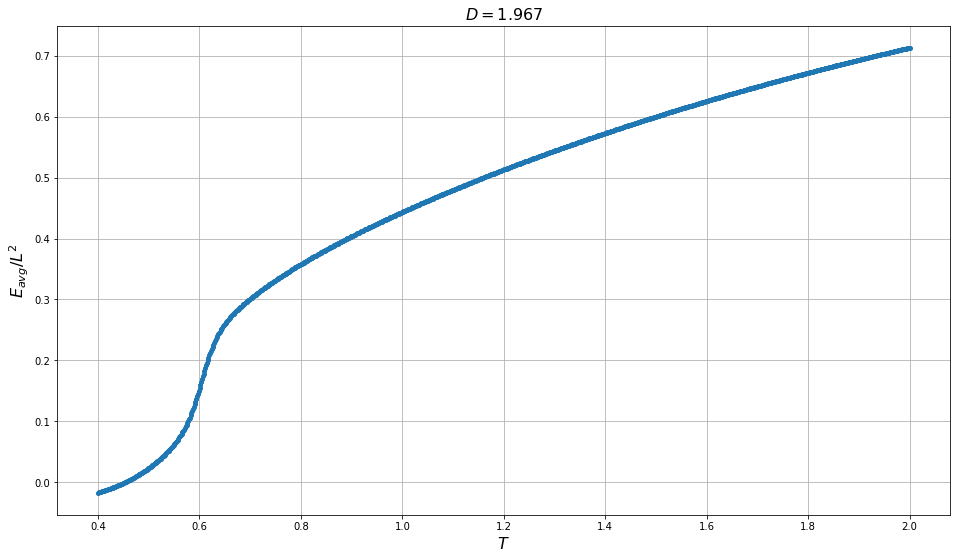

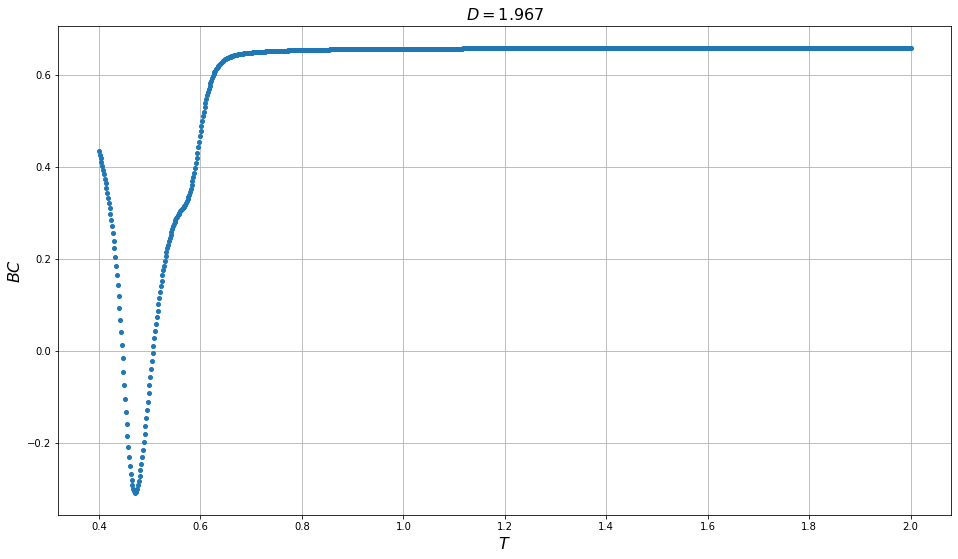

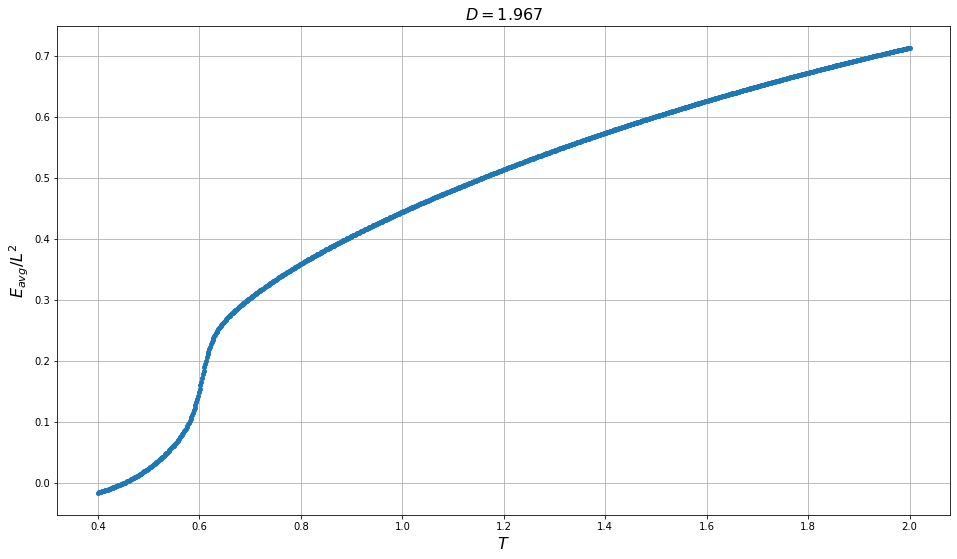

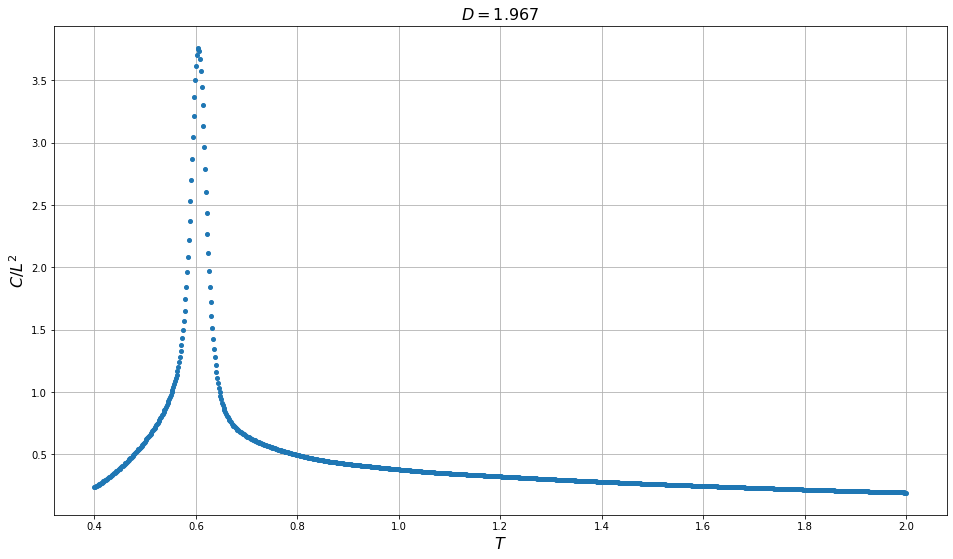

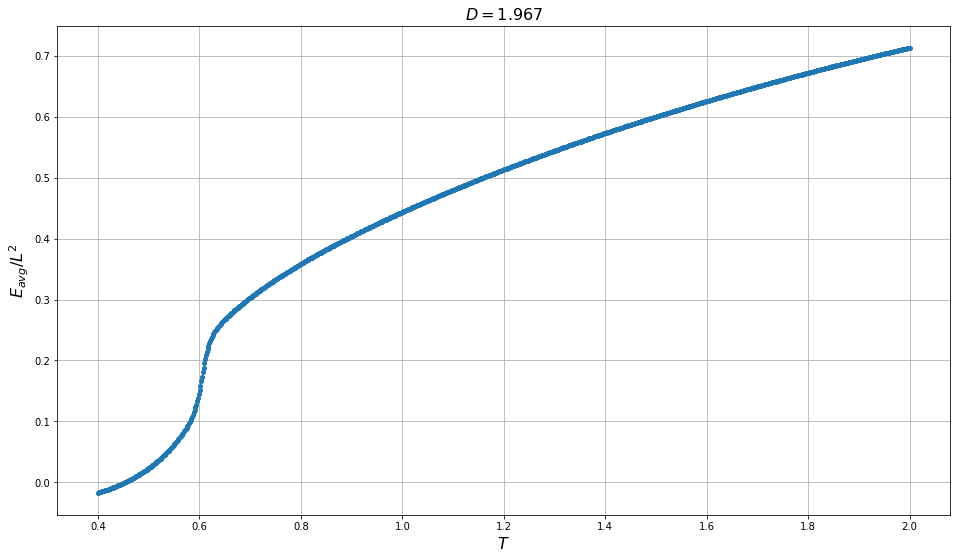

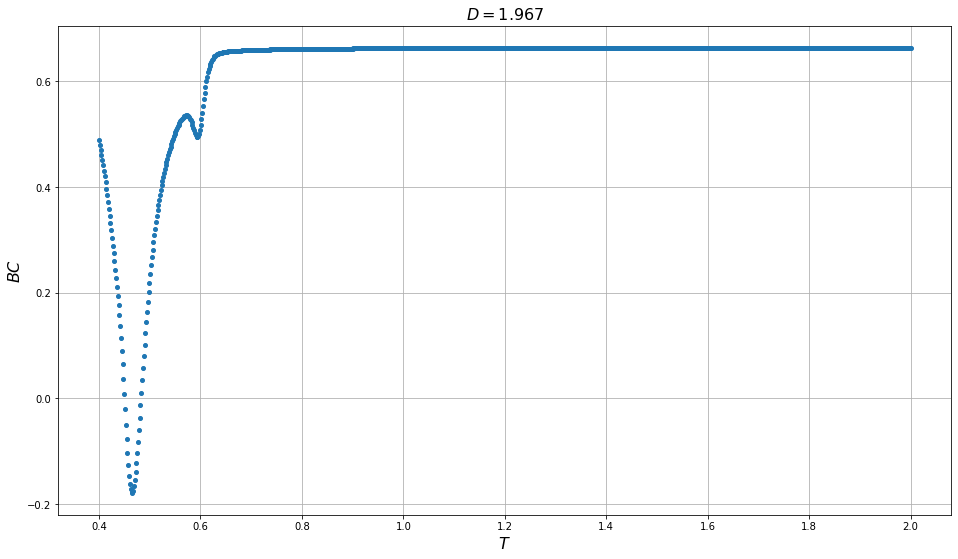

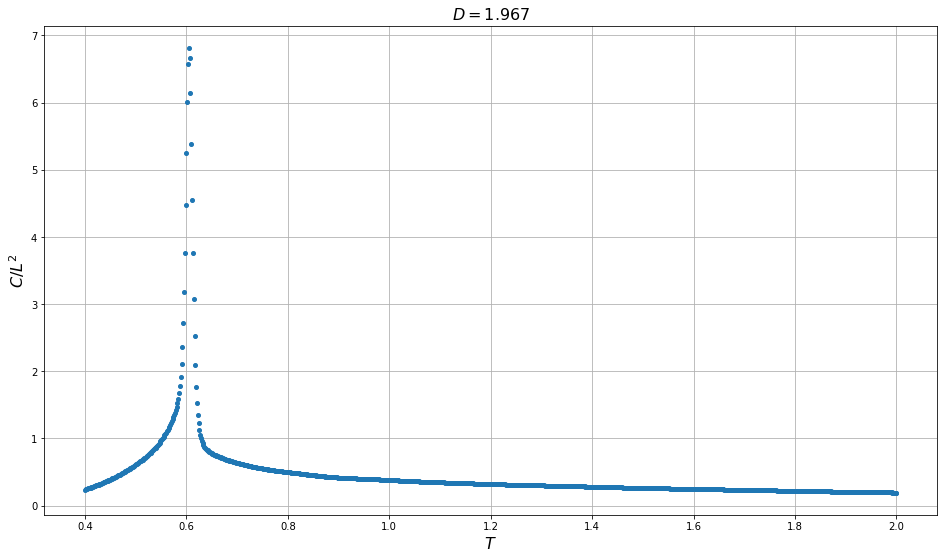

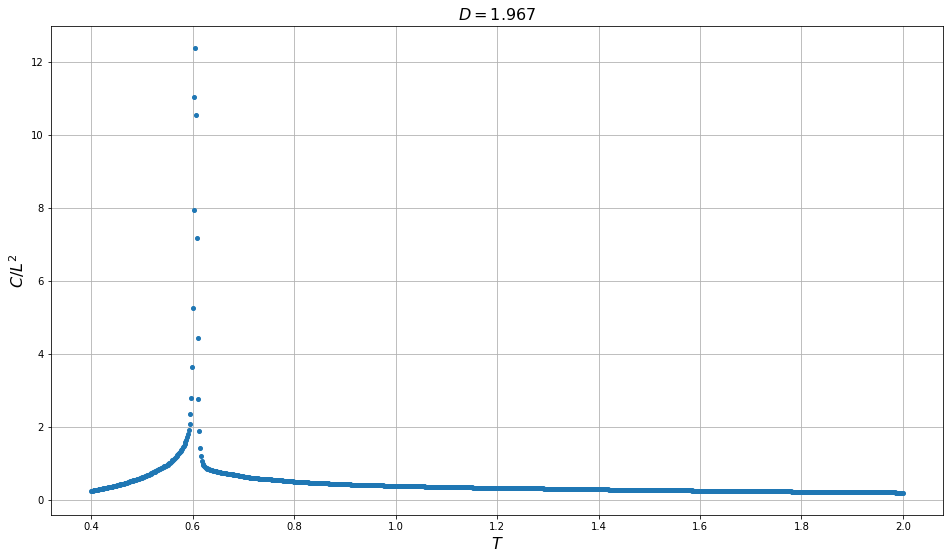

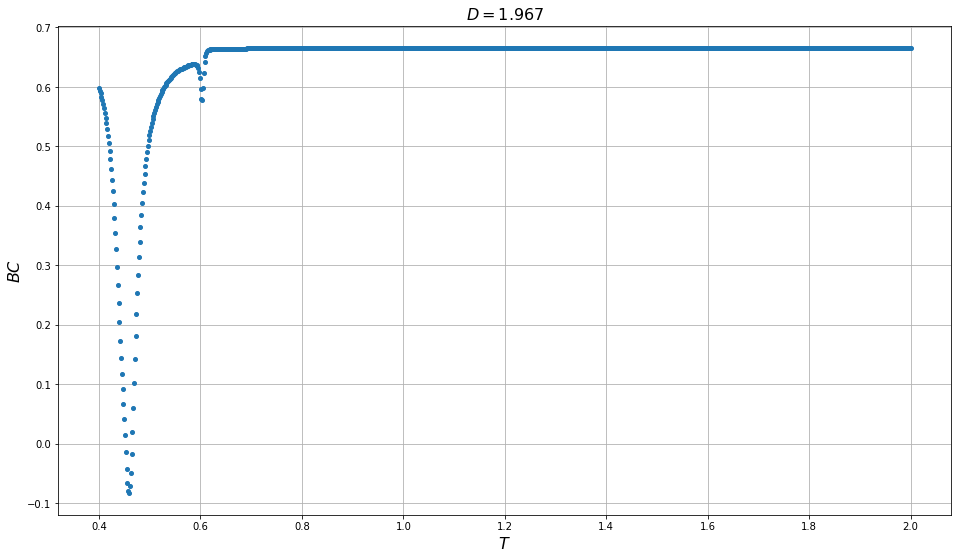

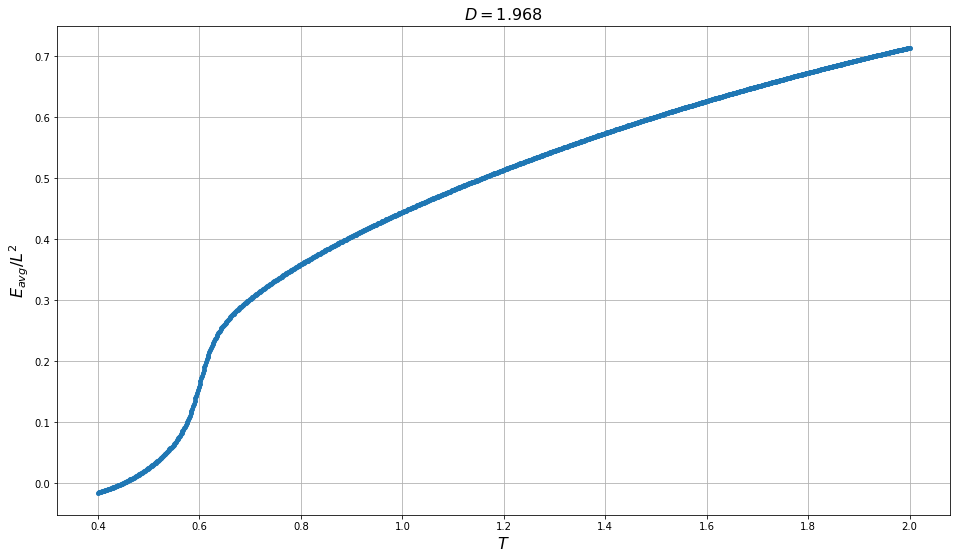

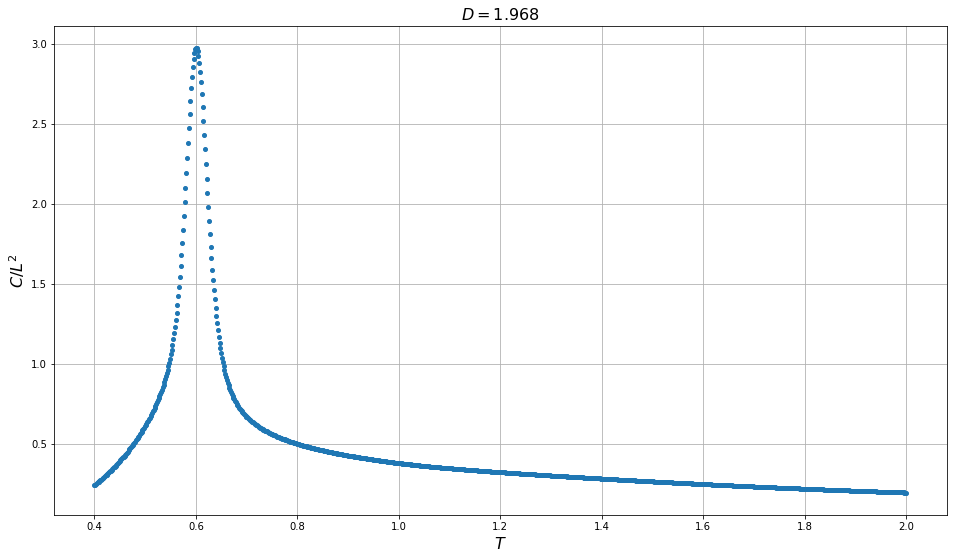

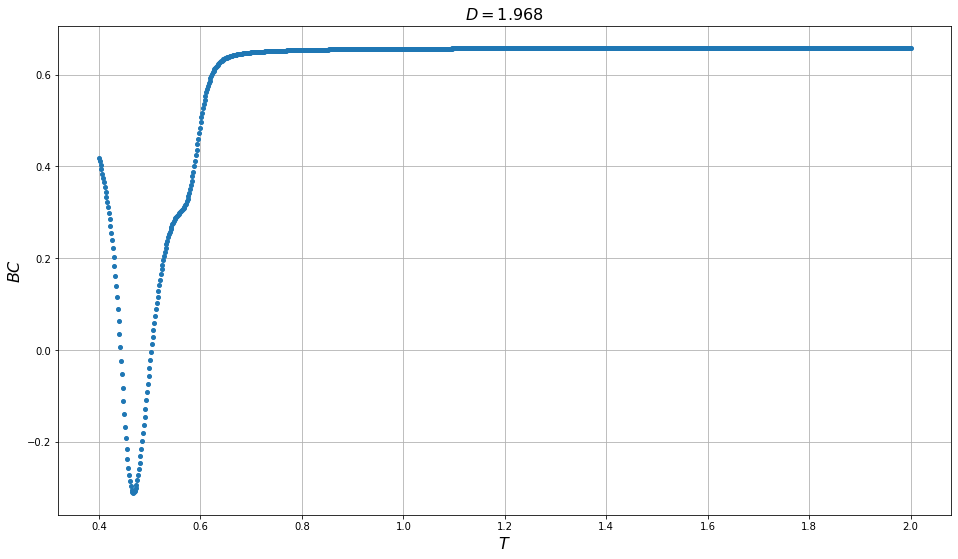

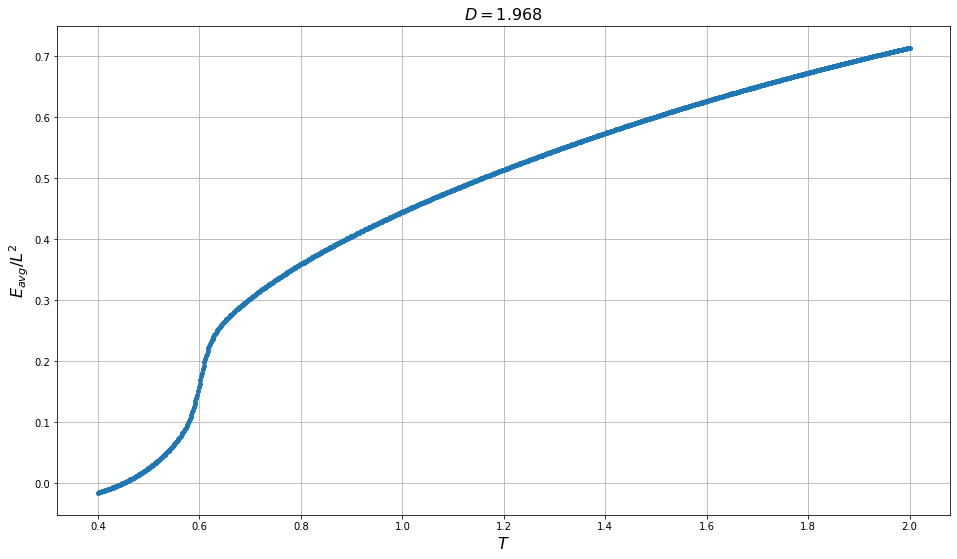

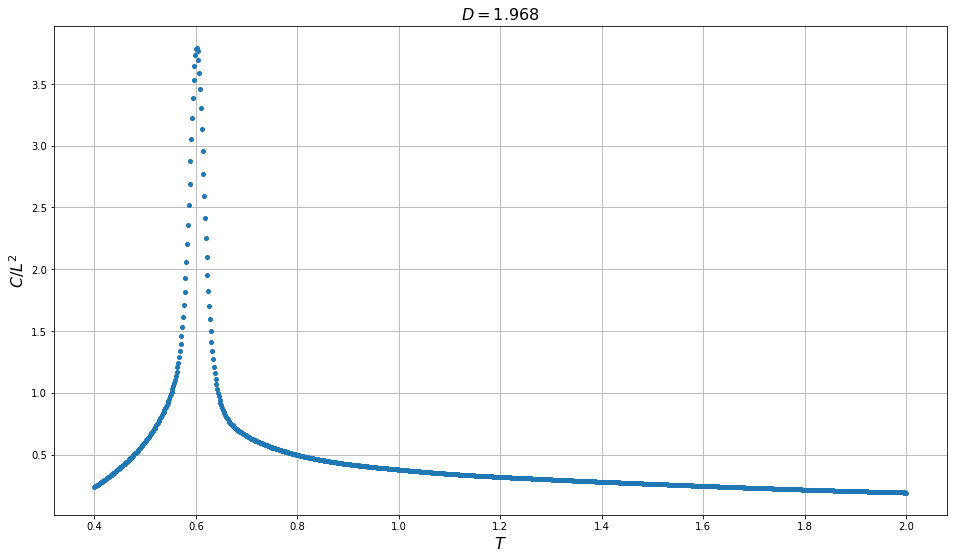

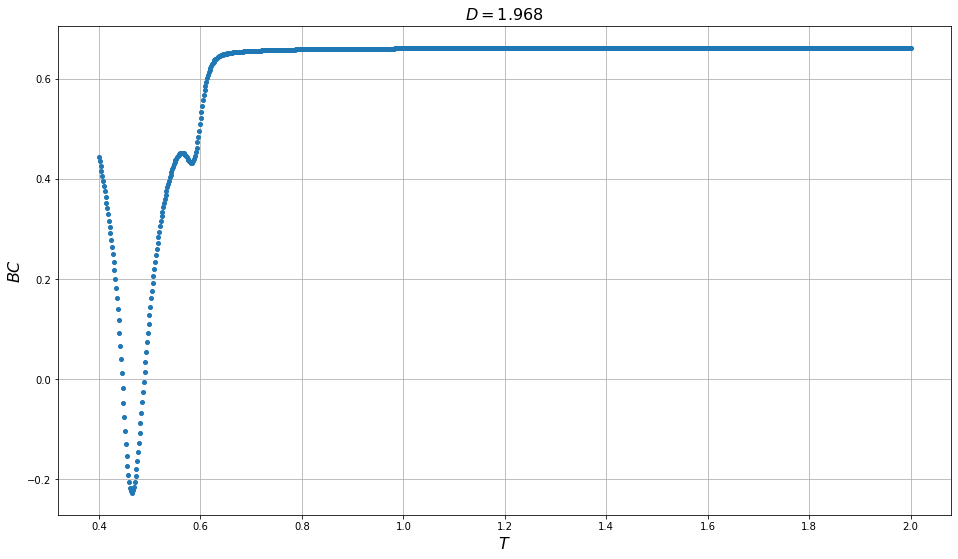

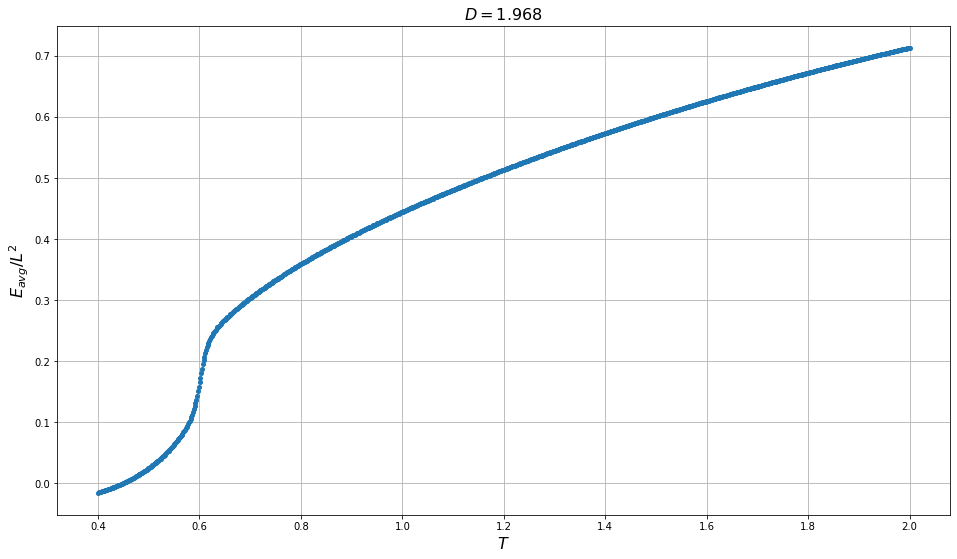

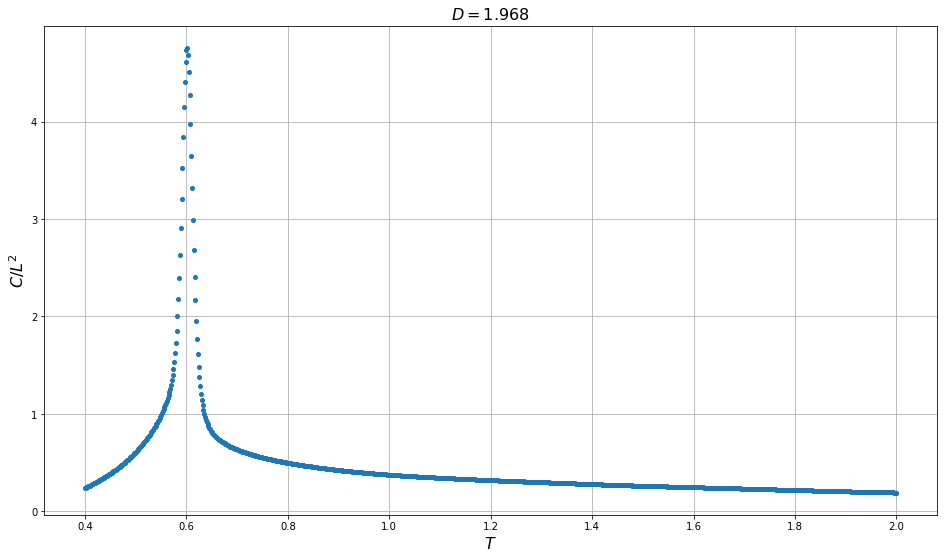

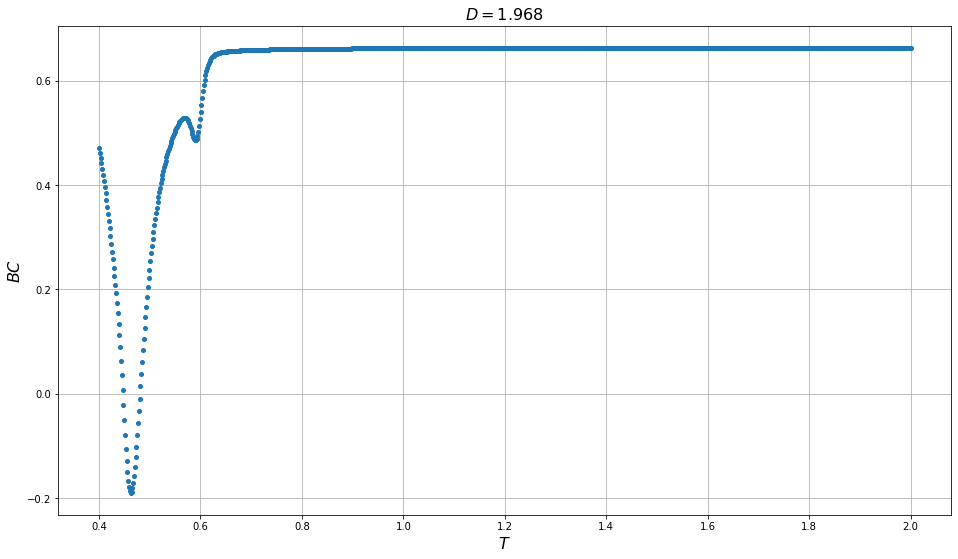

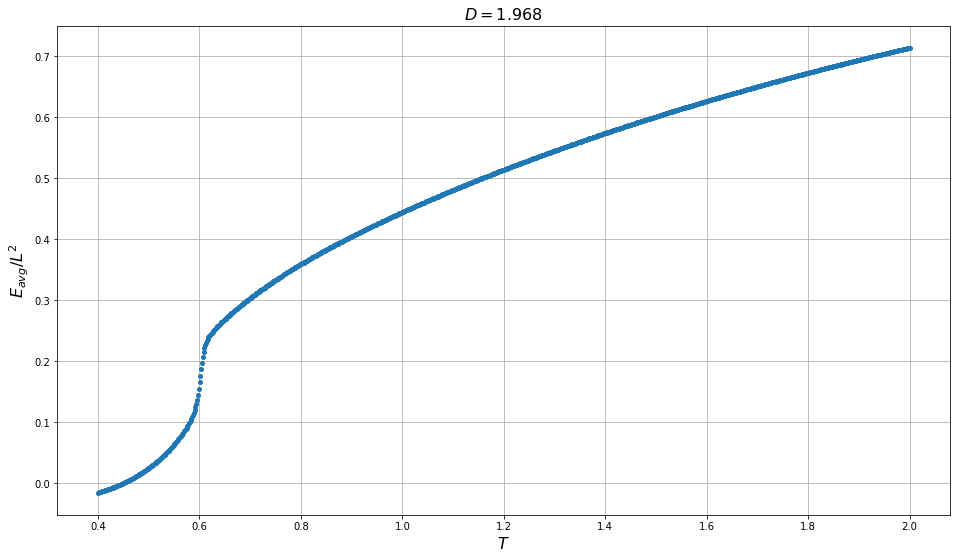

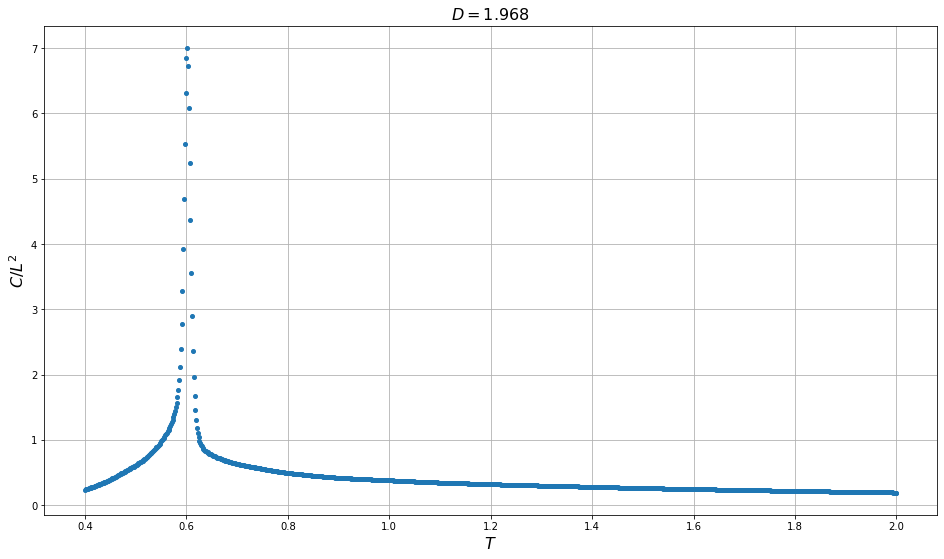

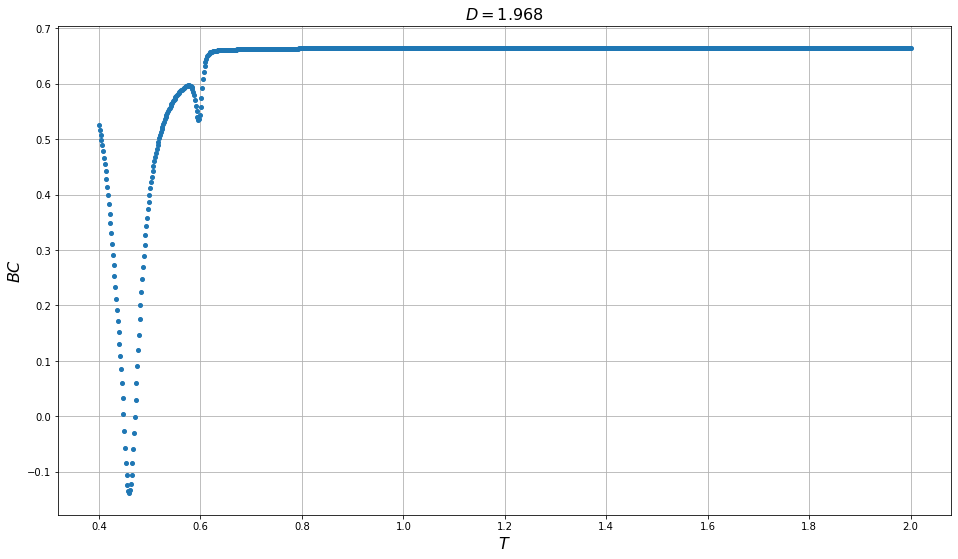

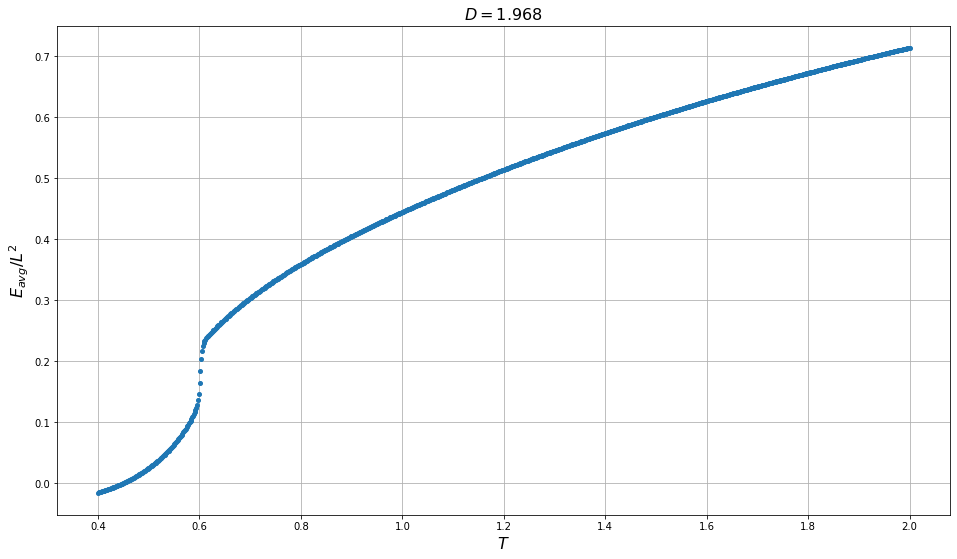

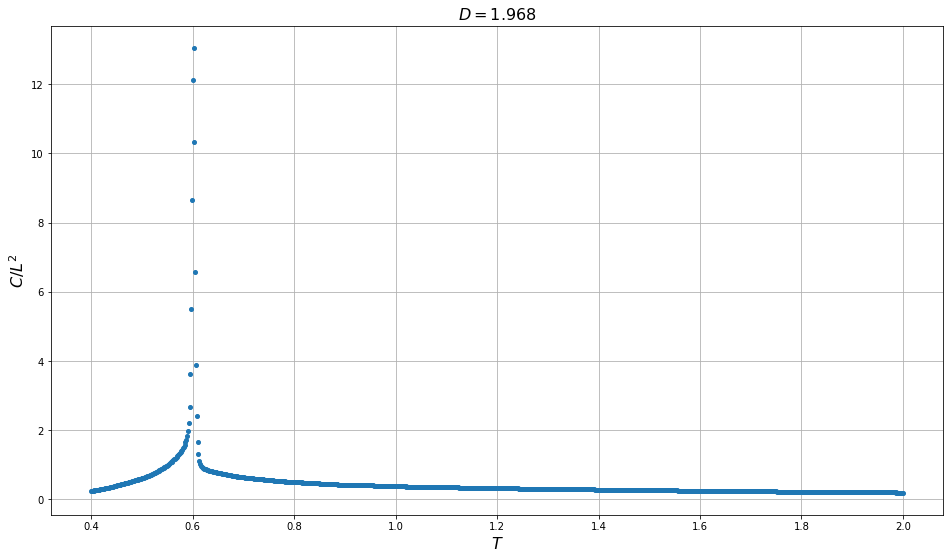

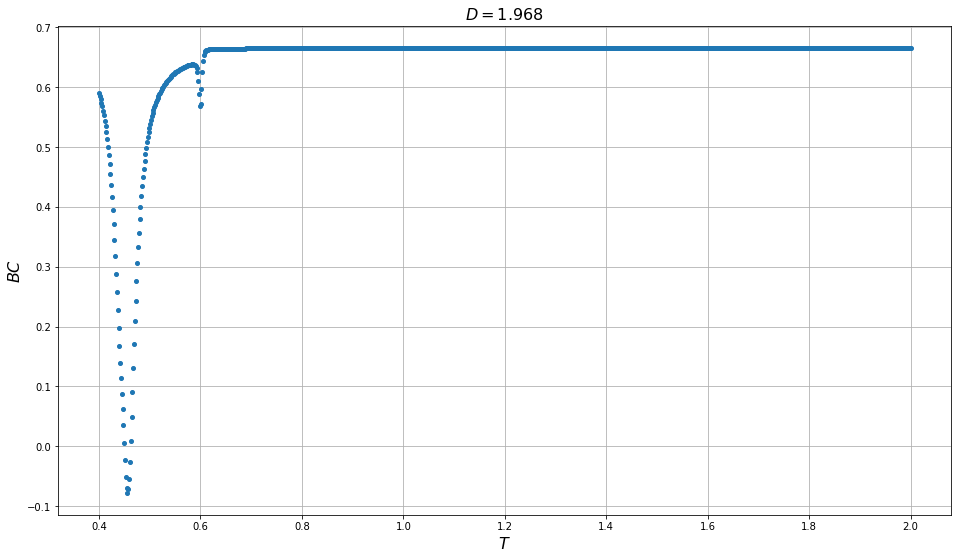

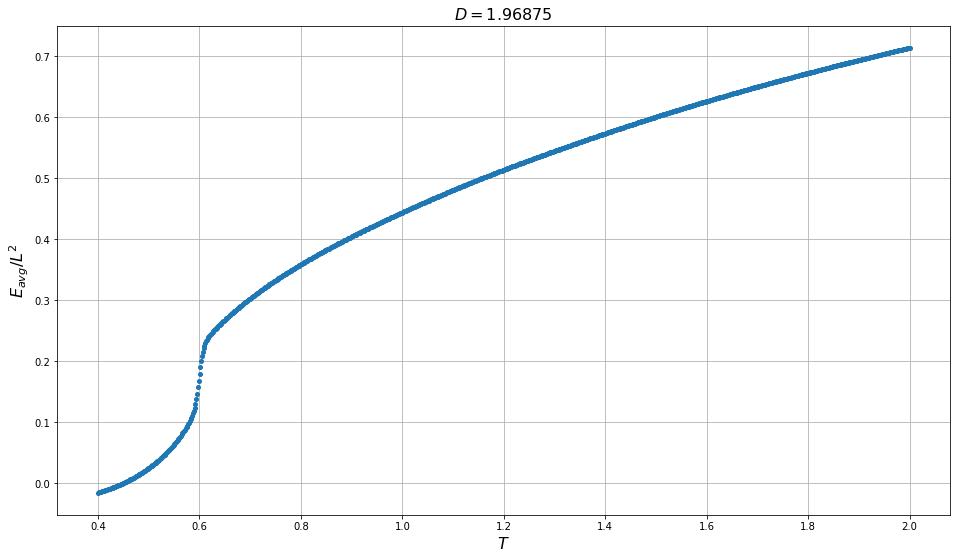

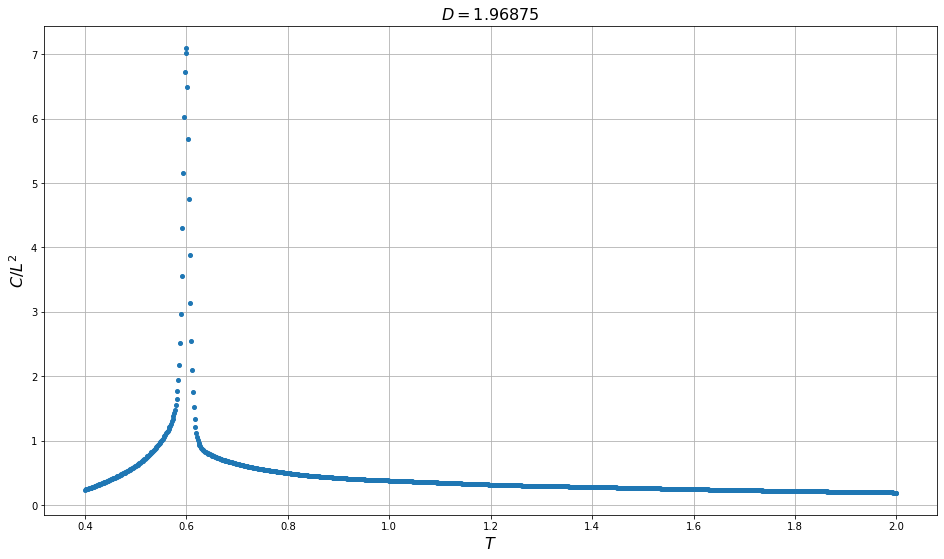

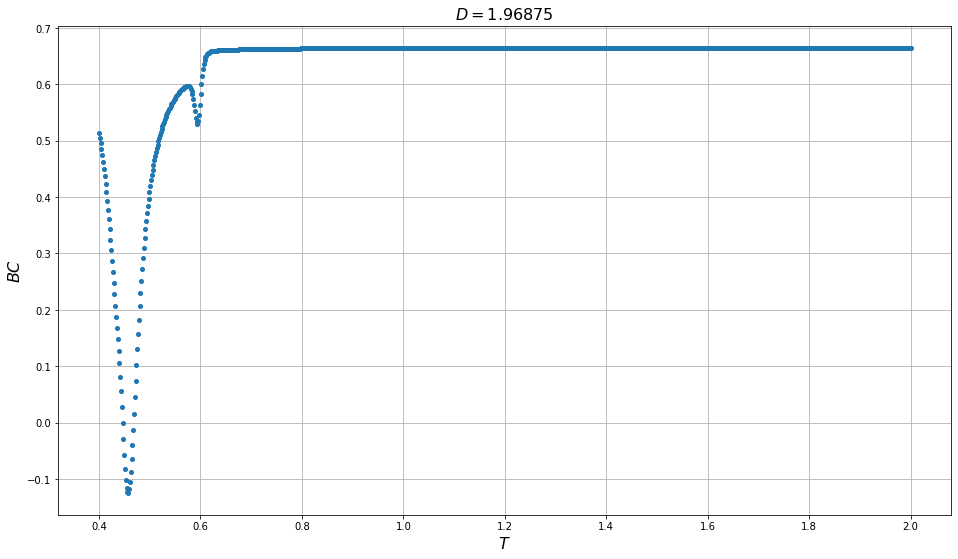

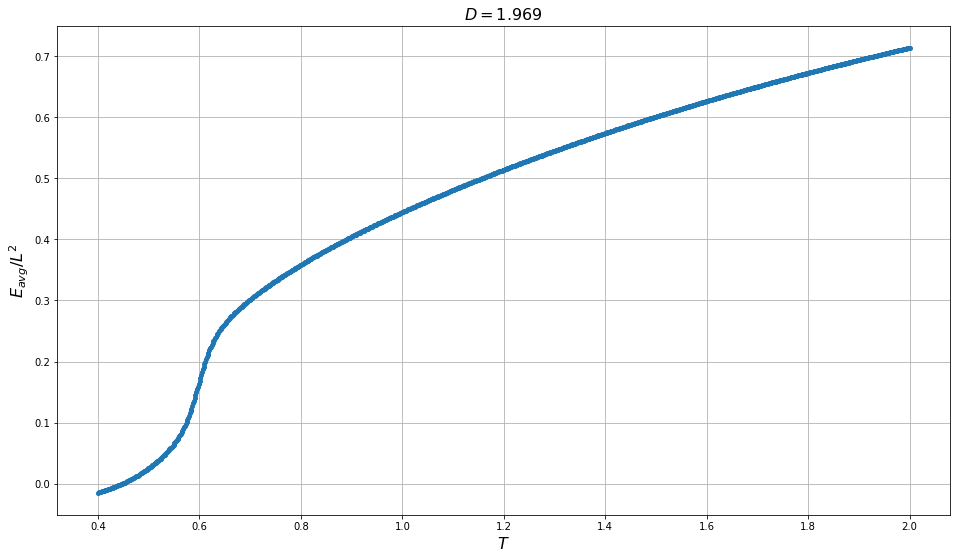

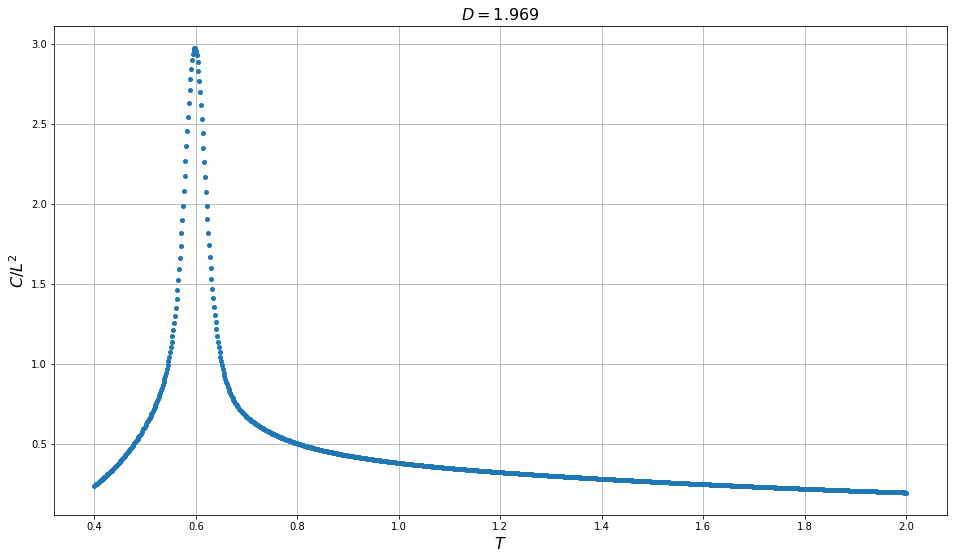

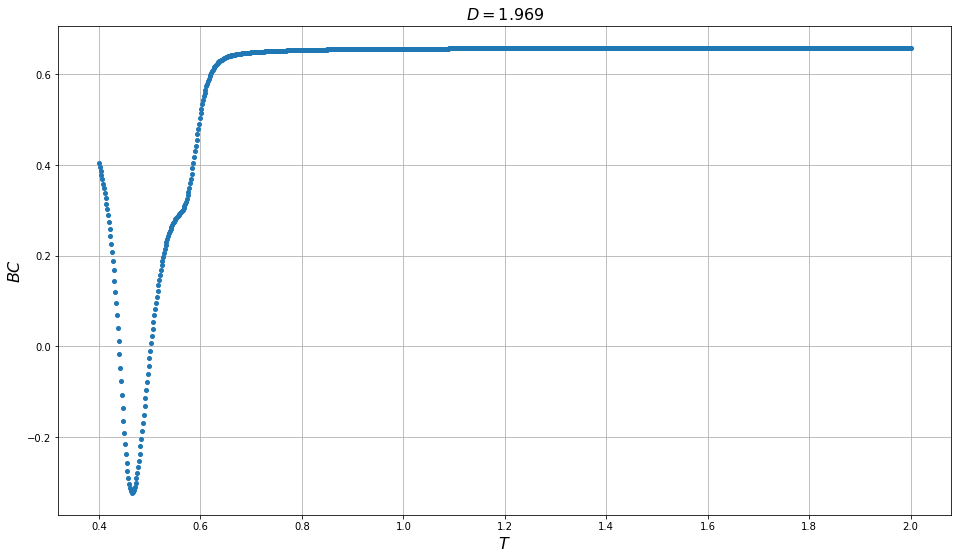

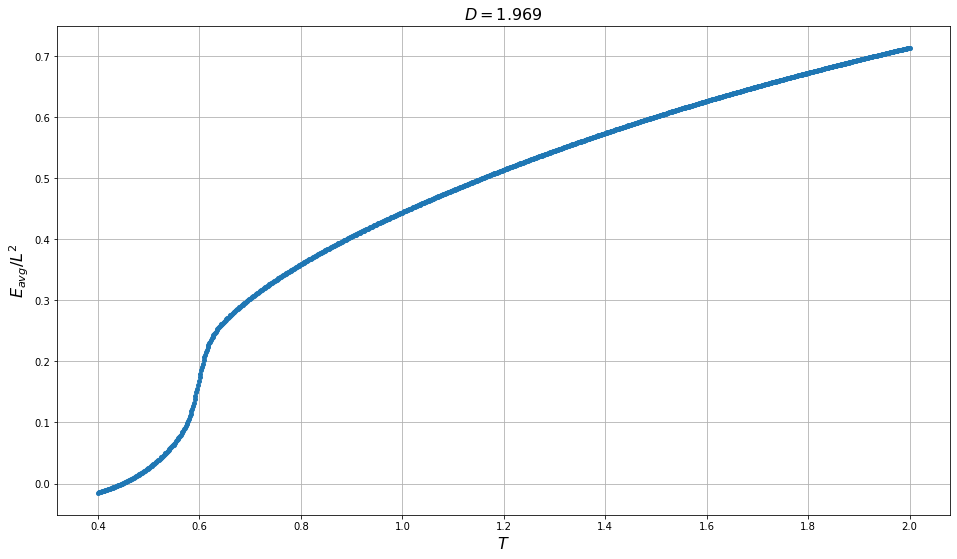

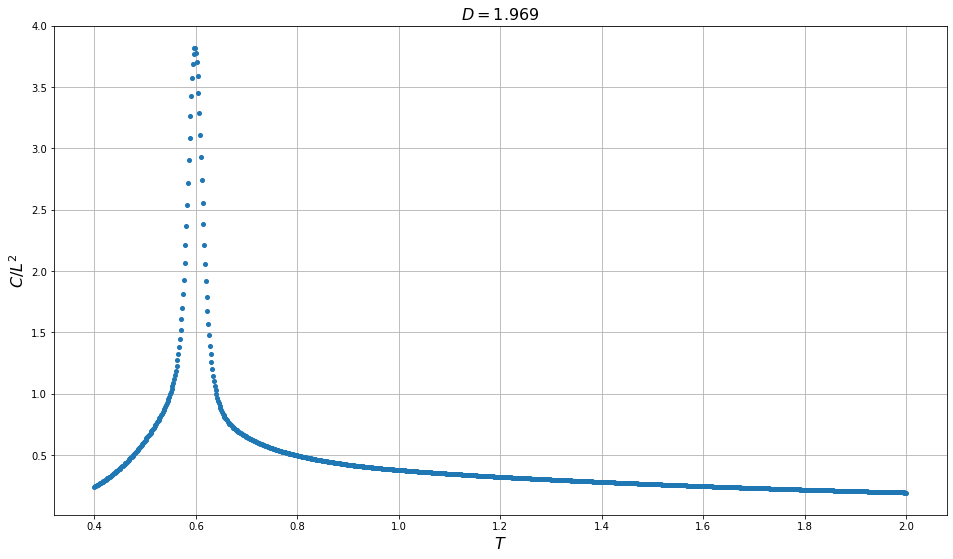

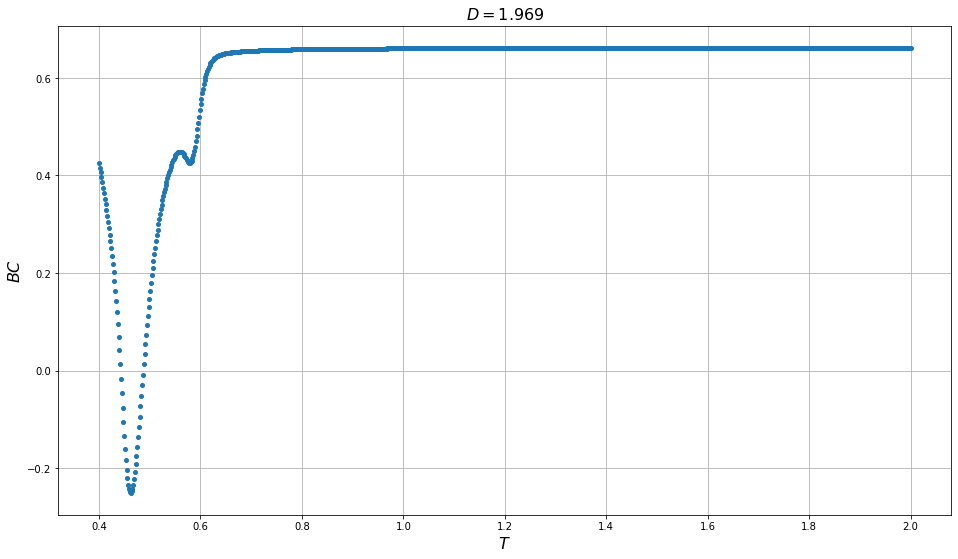

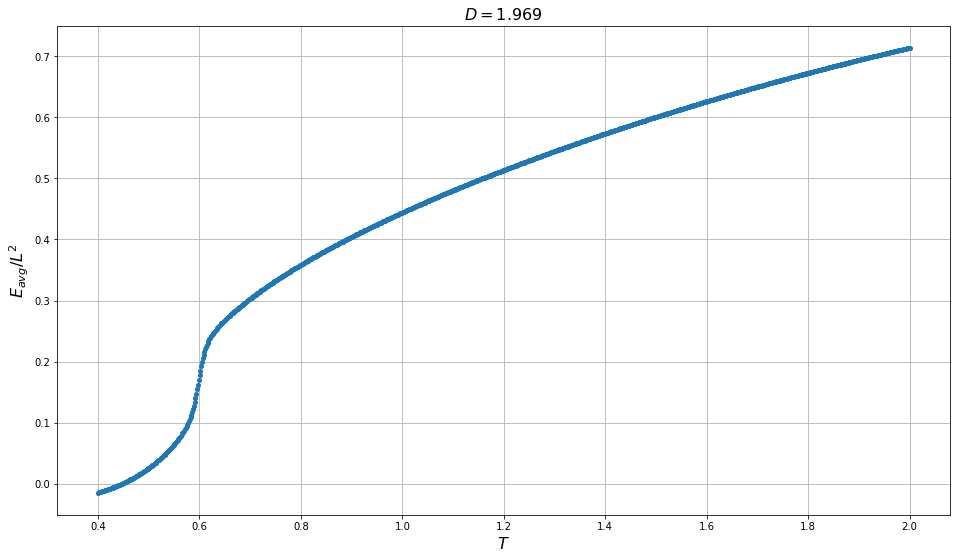

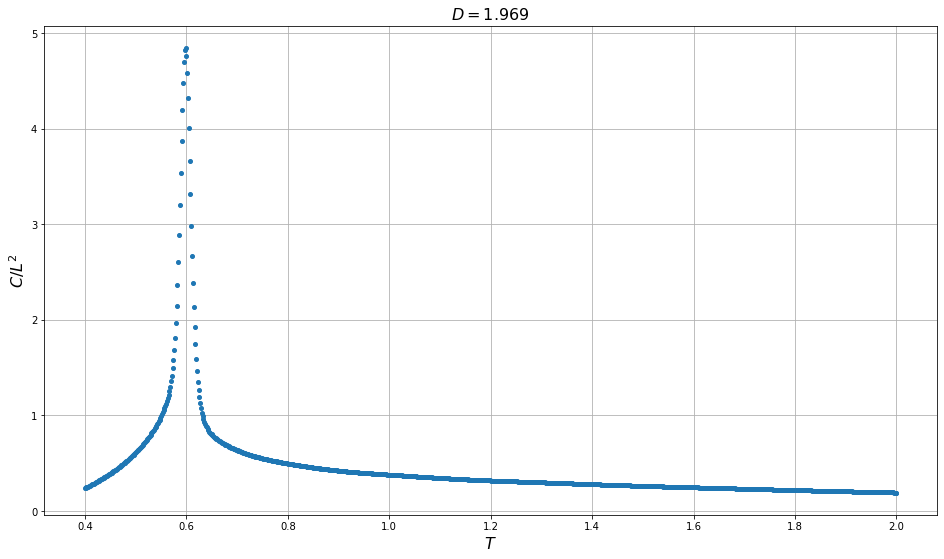

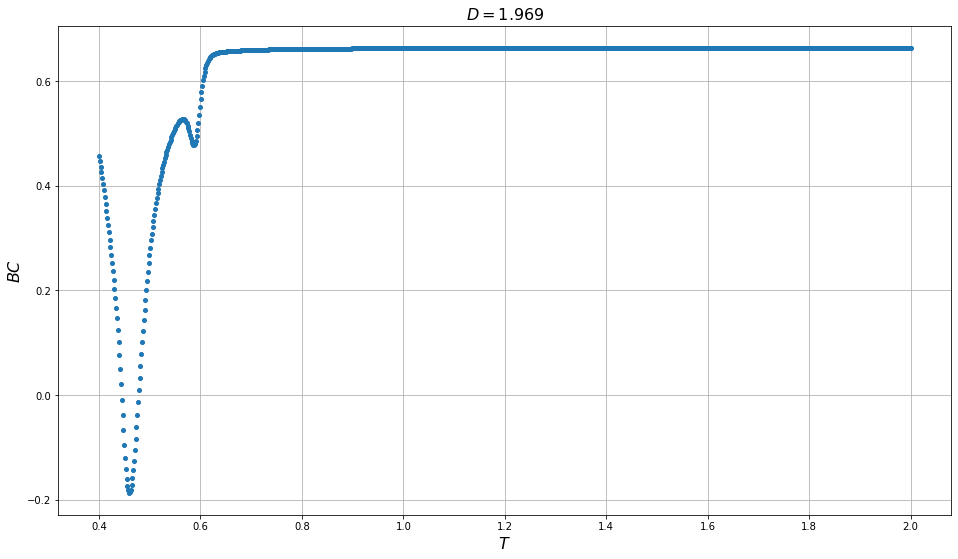

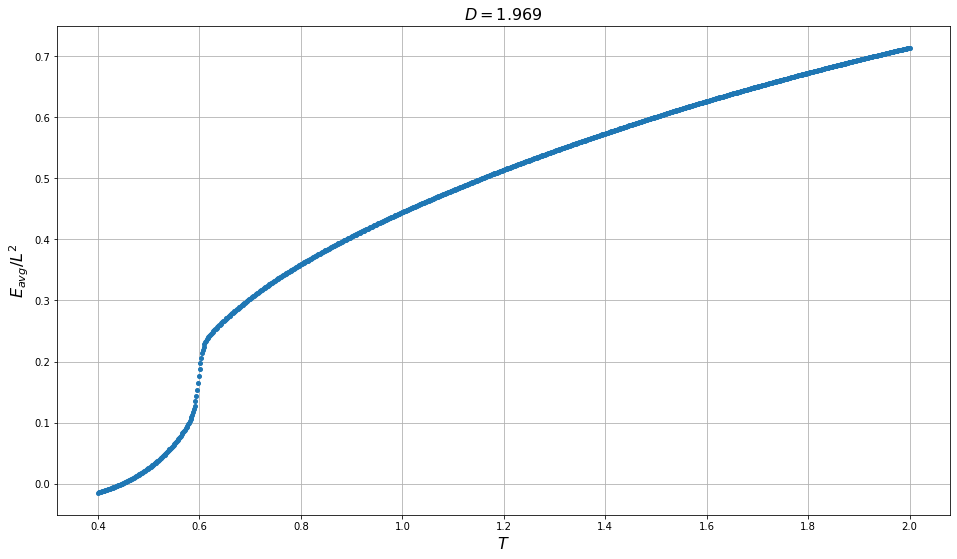

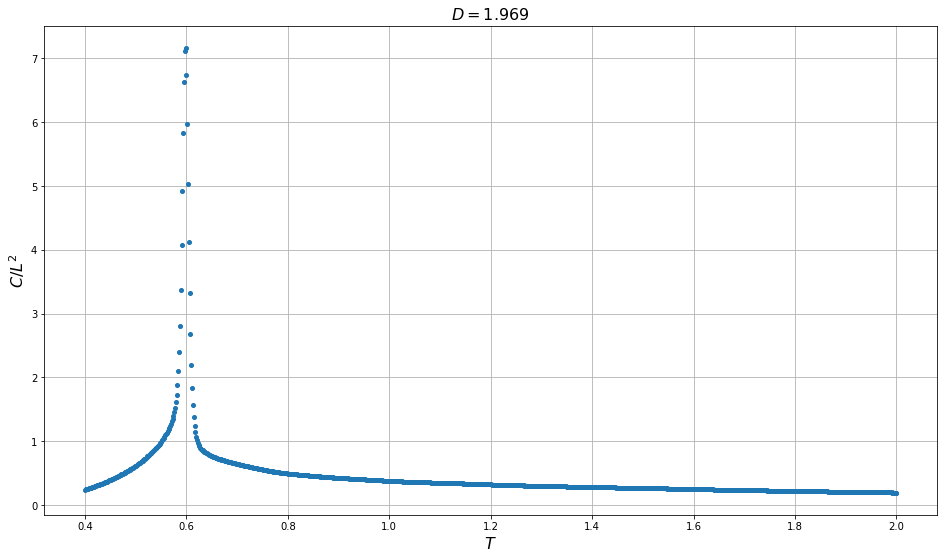

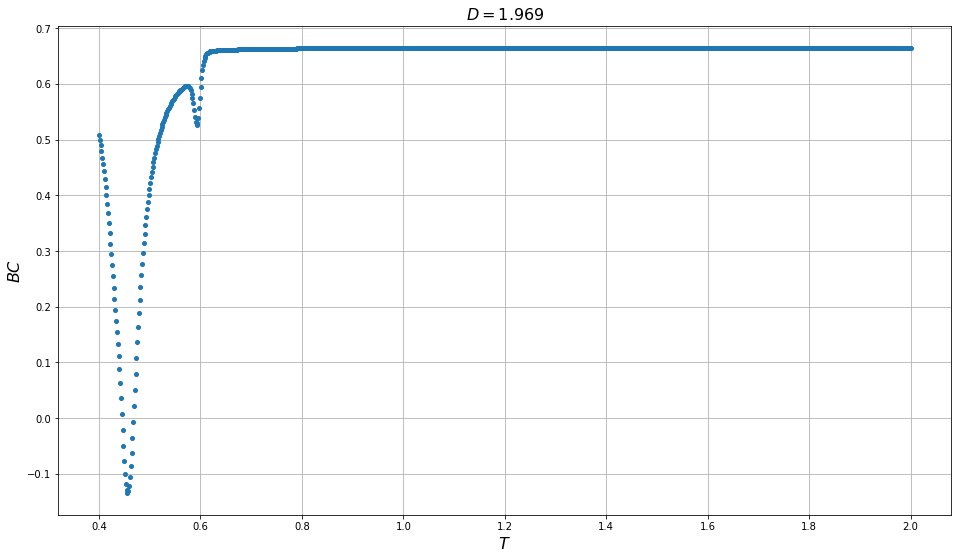

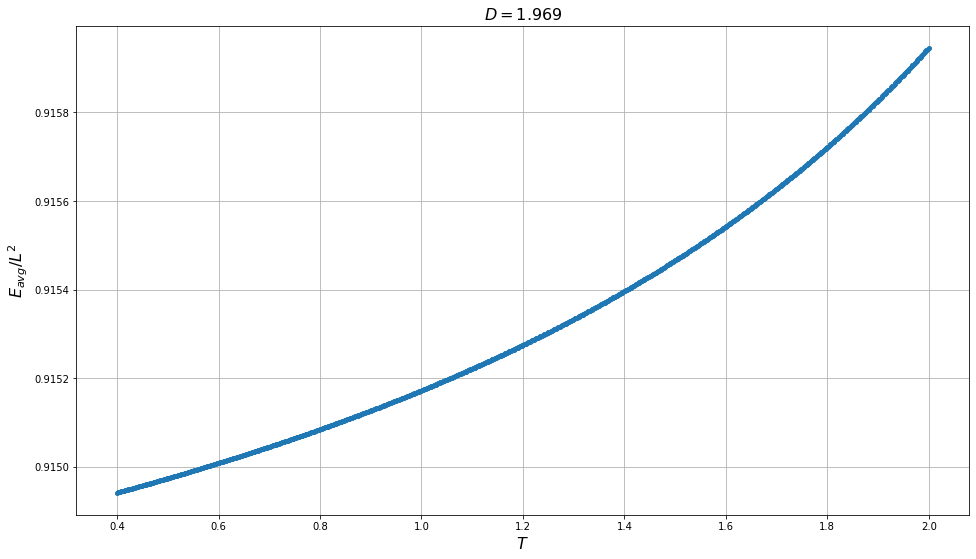

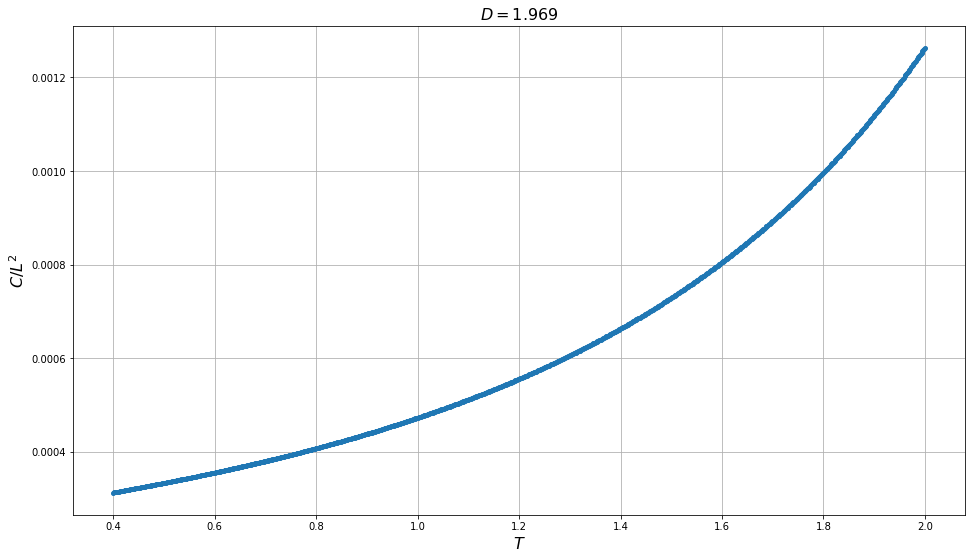

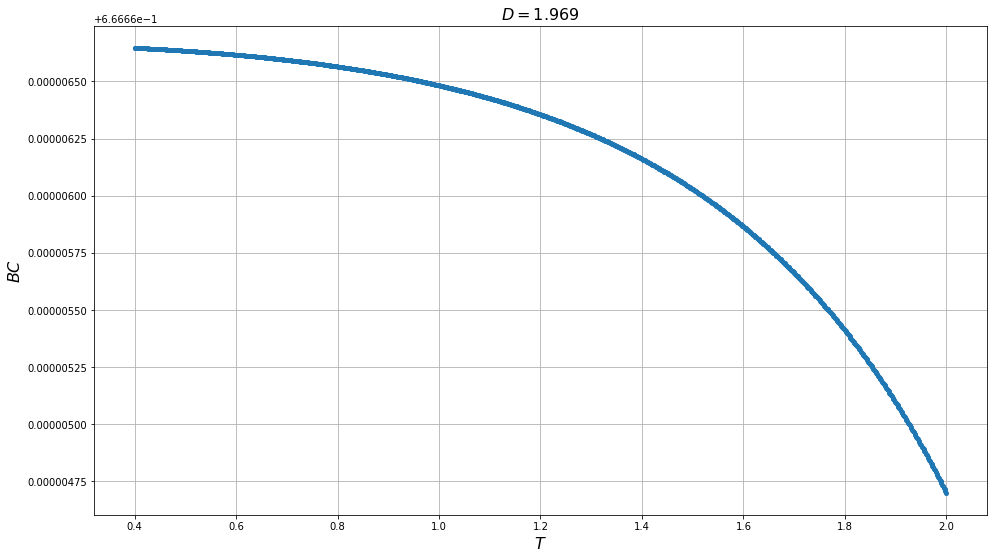

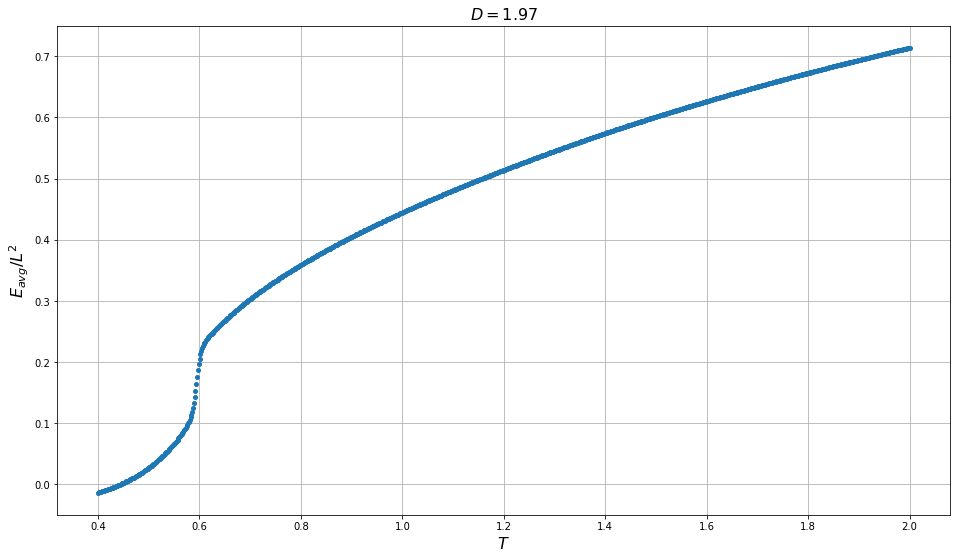

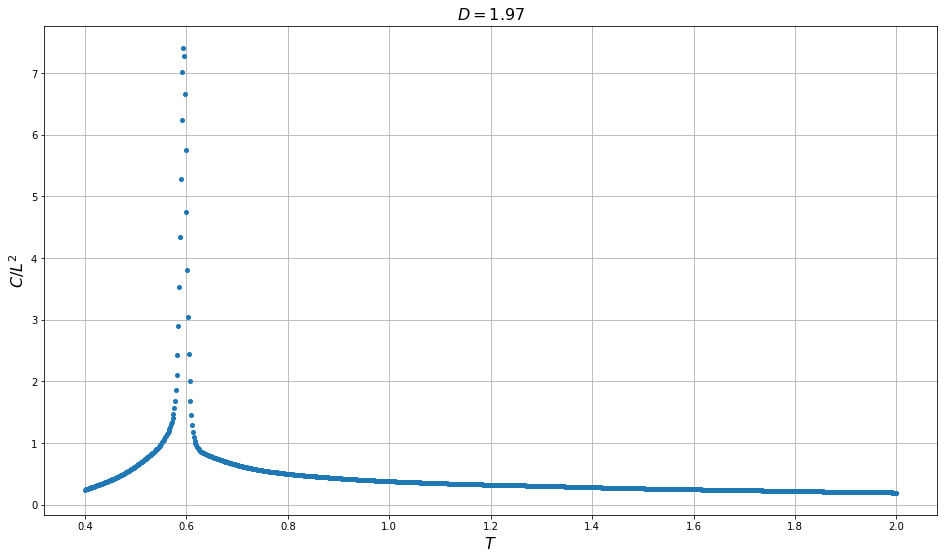

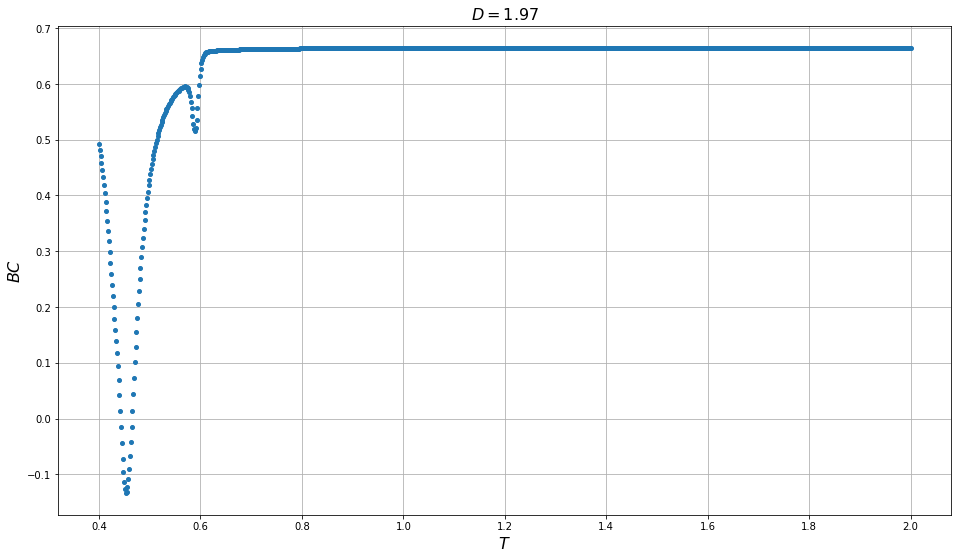

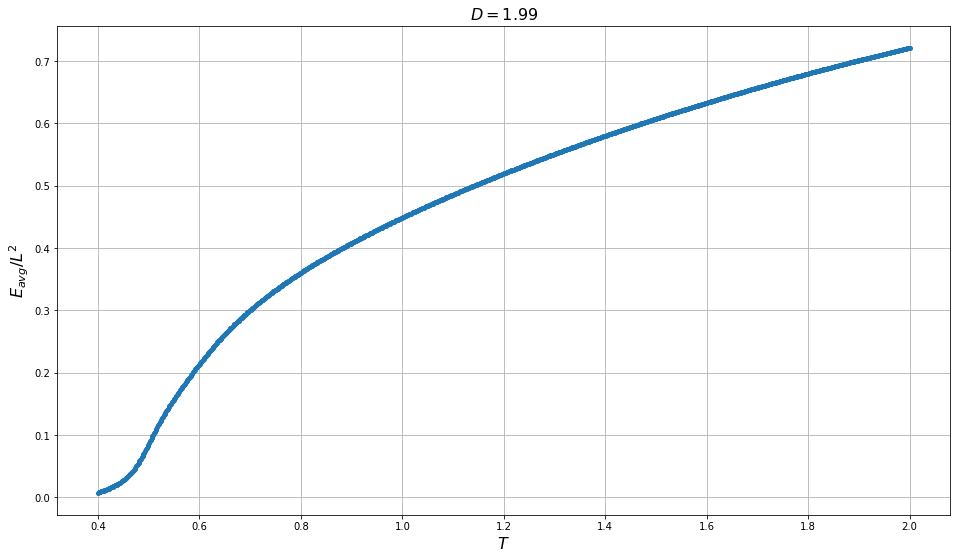

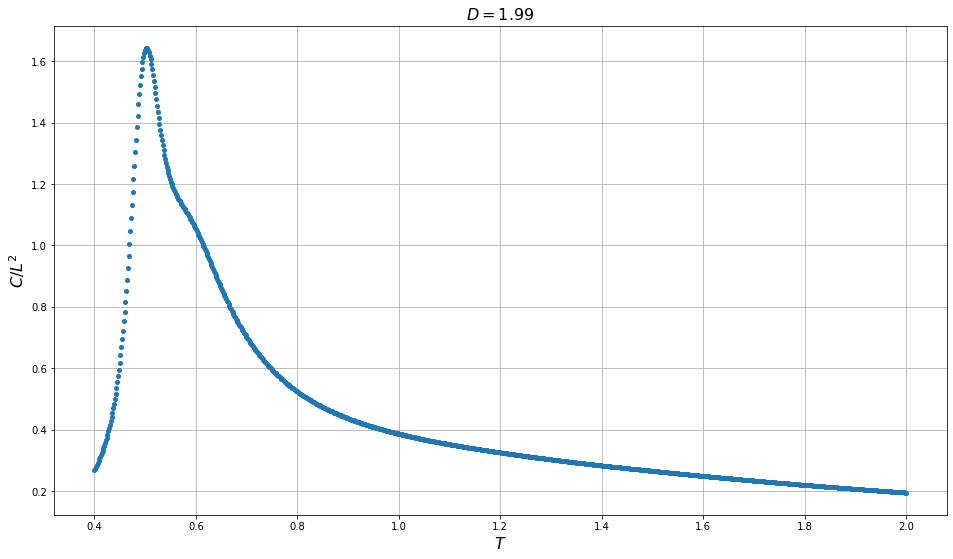

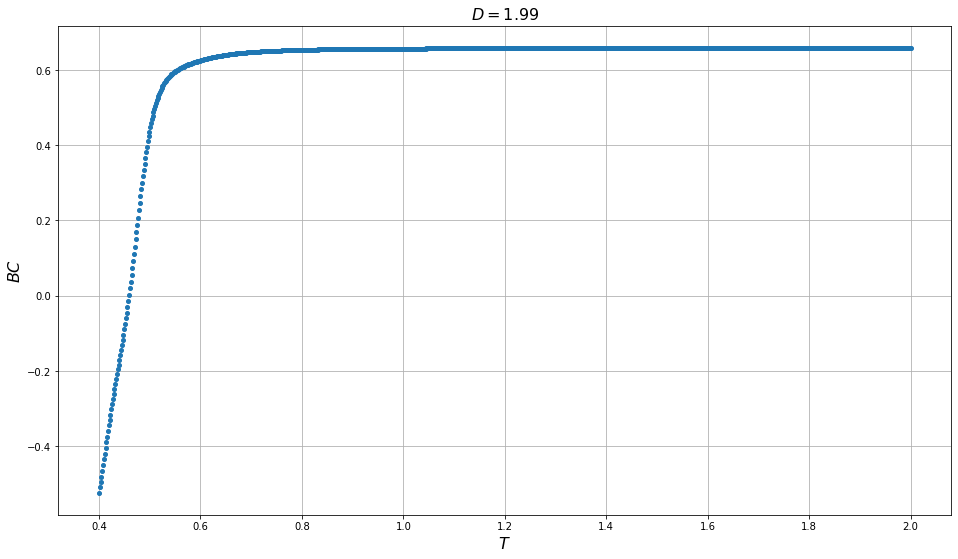

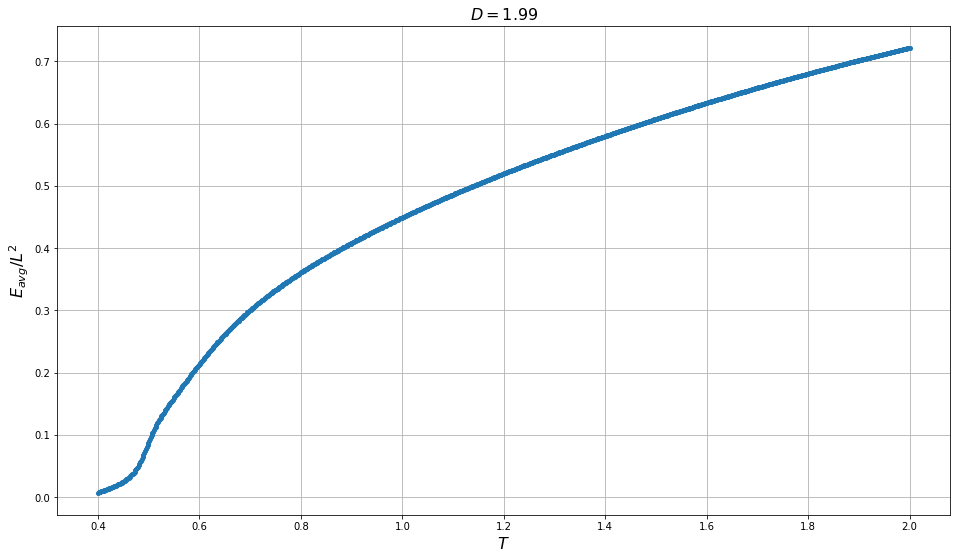

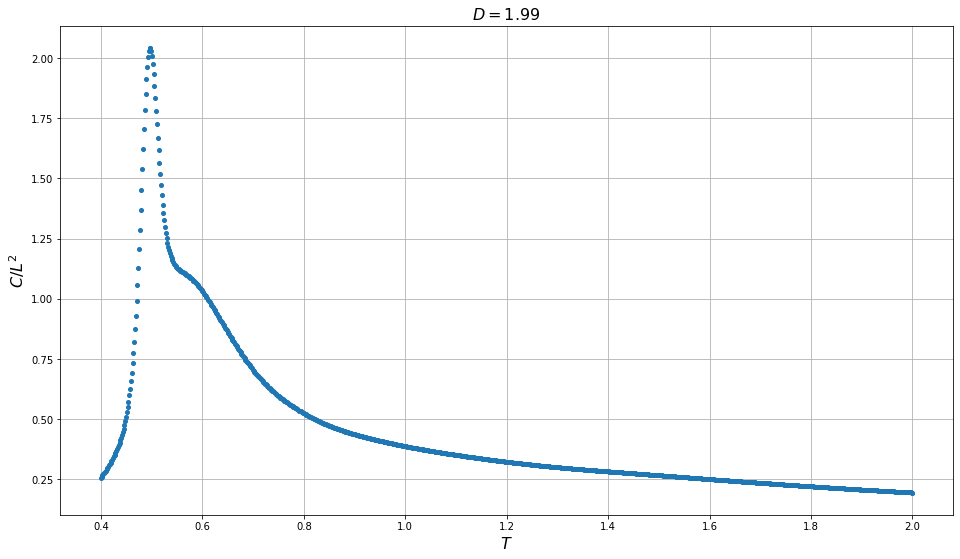

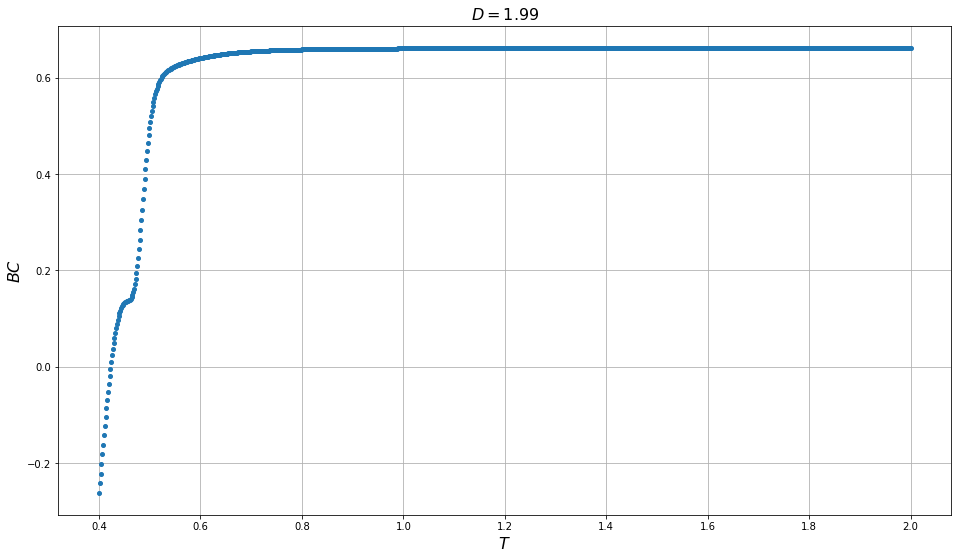

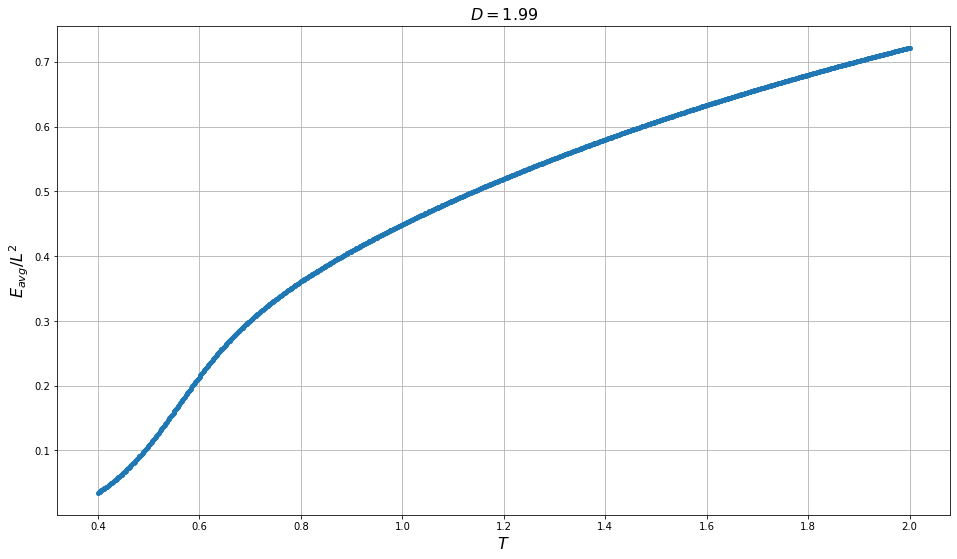

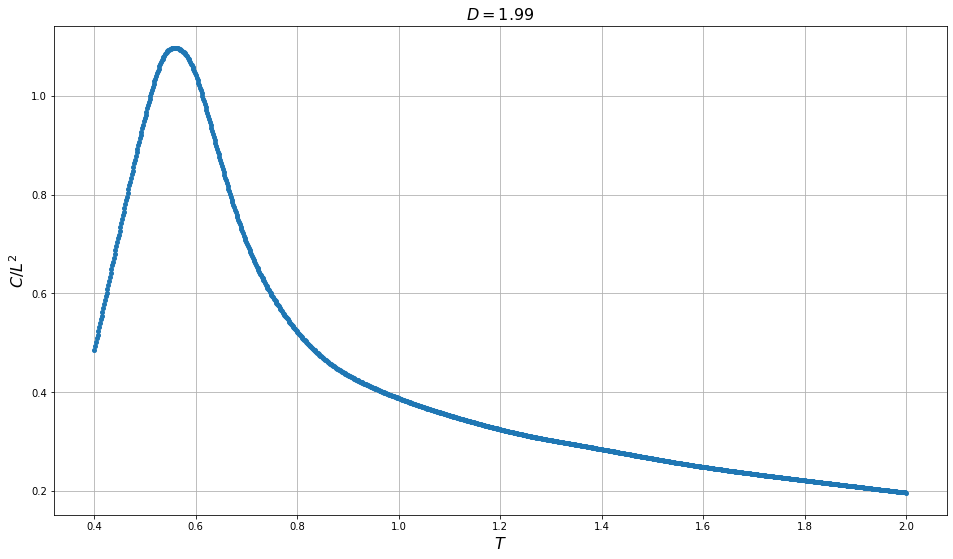

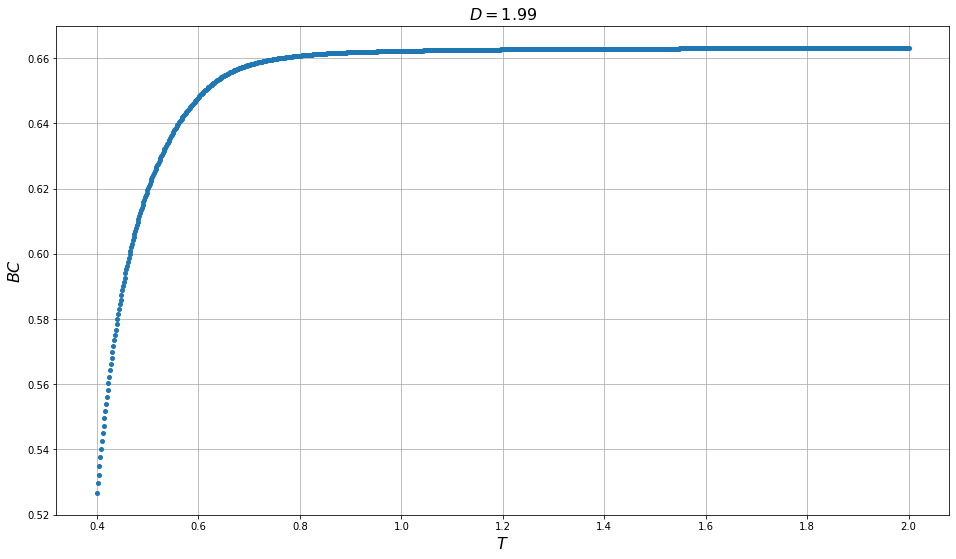

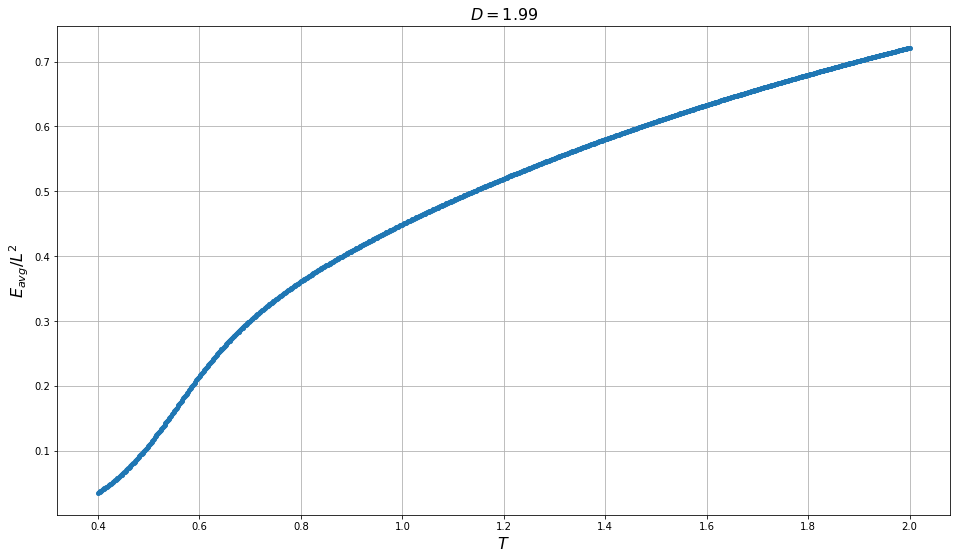

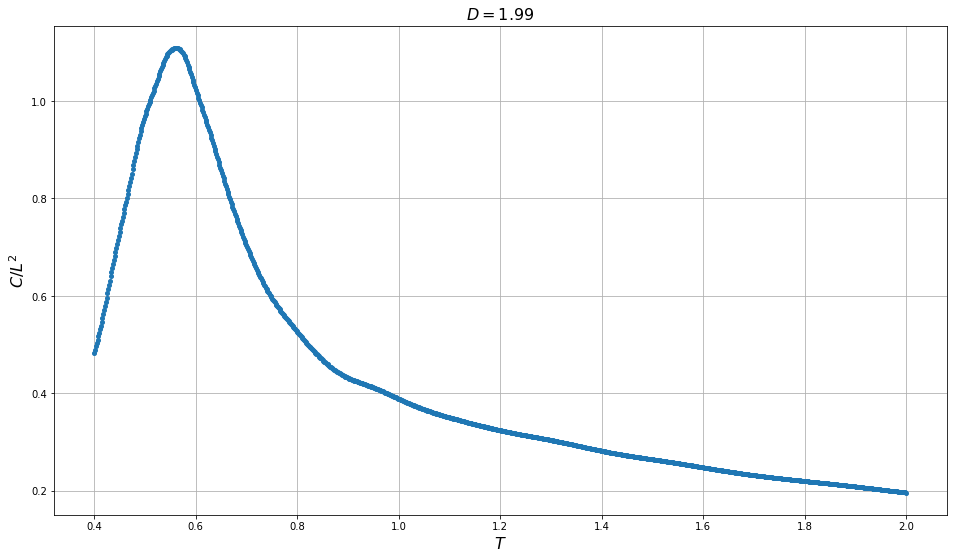

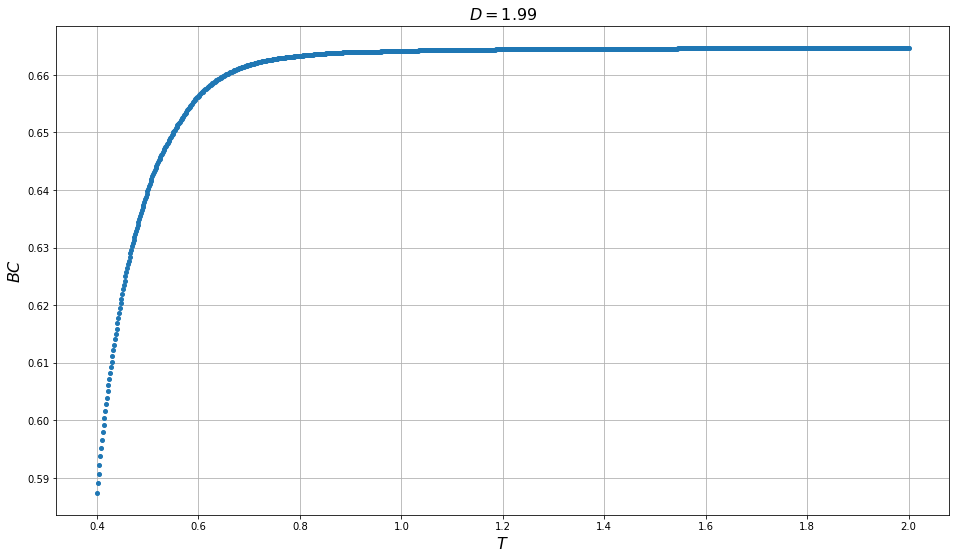

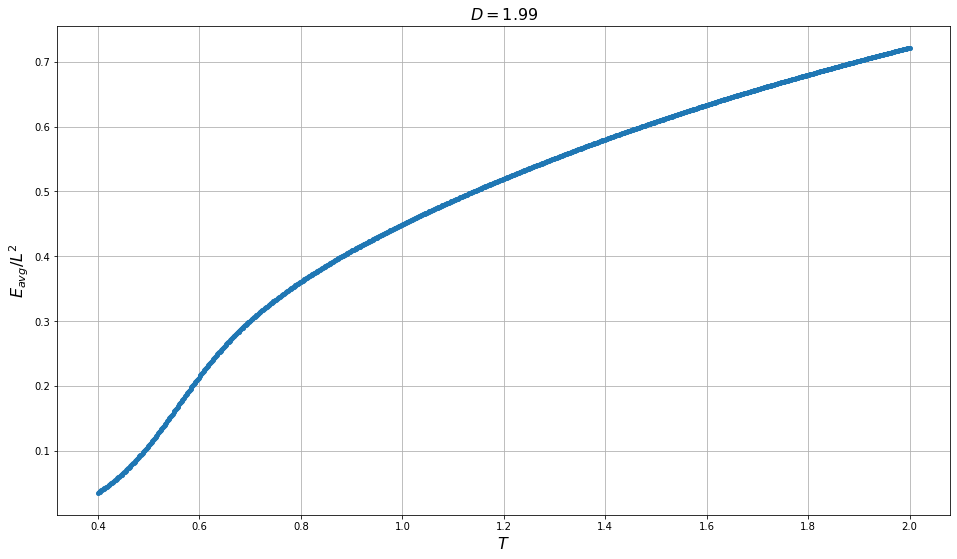

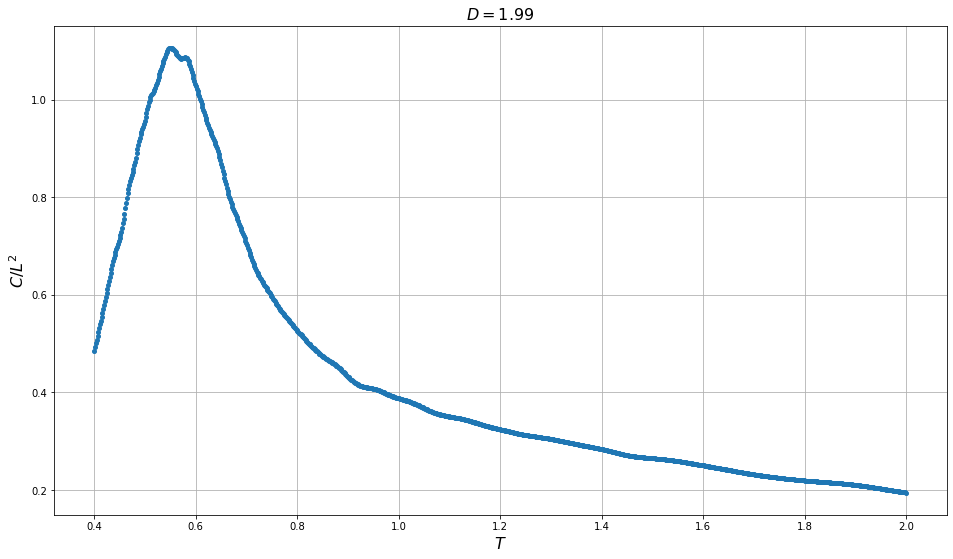

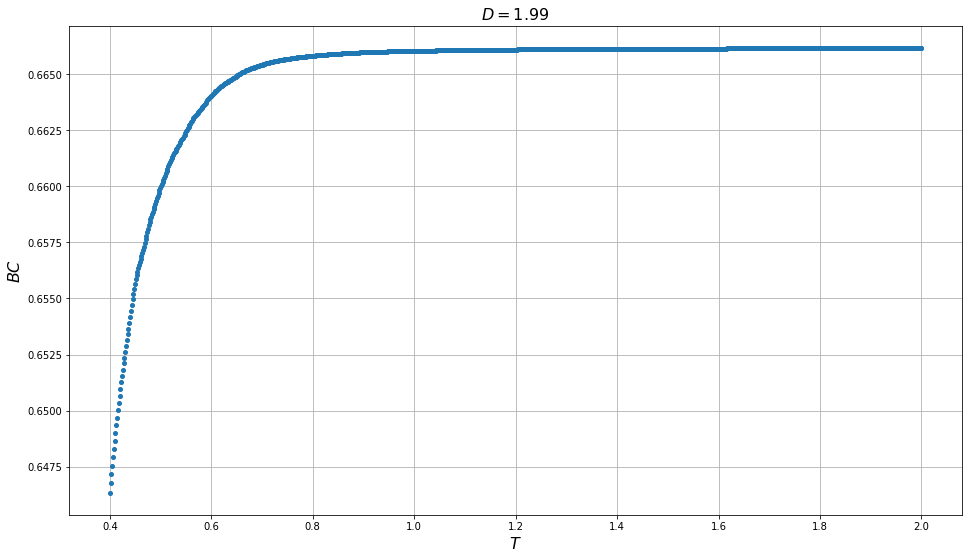

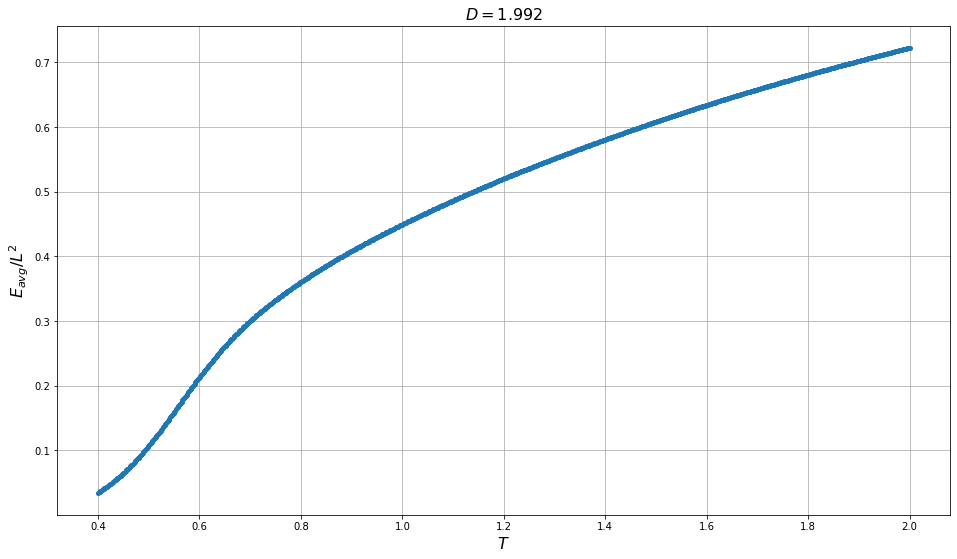

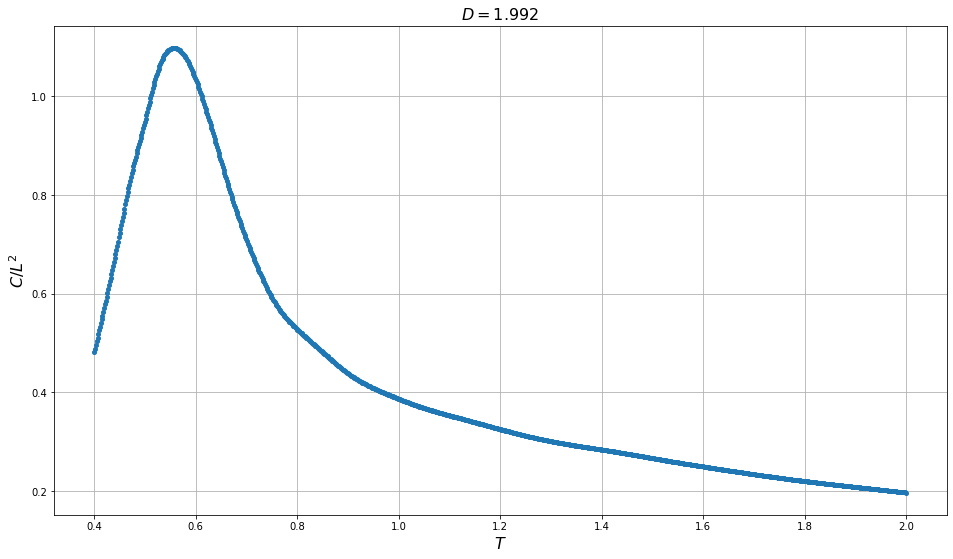

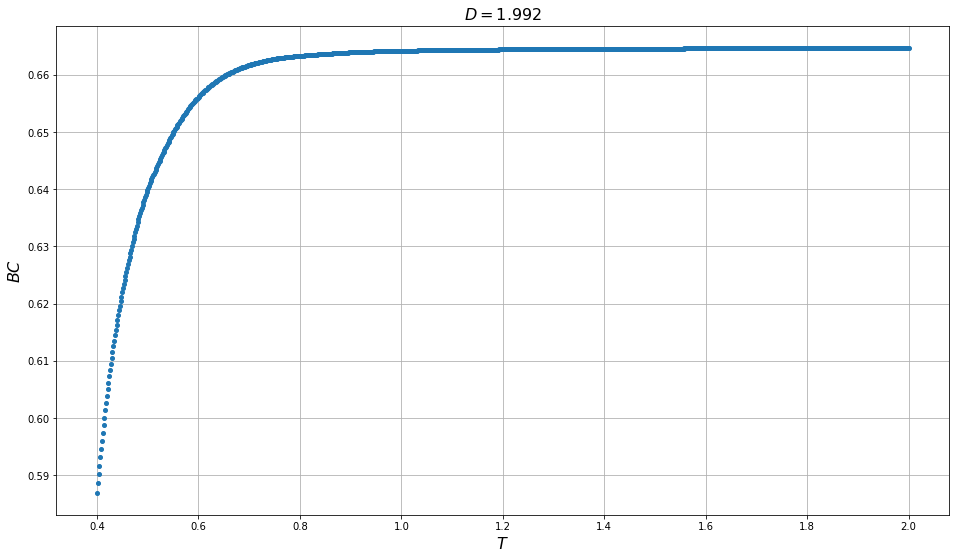

In [10]:
L_list = [#8, 12,
            16, 20, 24, 32, 48, 64, 96
         ];
#L_list = [32]
#x = [32]
for D in tqdm([#0.0, 0.5, 1.0, 1.5, 1.6,
                        #1.7,
                        #1.75,
                        1.8,
                        1.87, 1.875,
                        1.9, 1.92, 1.9375,
                        1.95, 1.96,
                        1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875,
                        1.969,
                        1.97,
                        1.99,
                        1.992,
                        0.01
                        ], desc="D"):
    for L in tqdm(L_list, desc="L"):
        cool, heat = [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": False
        }], [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": True
        }]

        parameters = []
        for x in zip(cool, heat):
            try:
                parameters.append(read_tuple_files(x))
            except:
                print("not found D{} L{}".format(D, L), flush=True)
                continue;
            print("found D{} L{}".format(D, L), flush=True)

        for i, x in enumerate(parameters):
            parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])

        hc = {}
        E = {}
        BC = {}

        for i, x in enumerate(parameters):
            heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
            L = st['L']
            N = L * L

            hc[L] = {}
            E[L] = {}
            BC[L] = {}
            
            
            frames_list = list(zip(itertools.repeat(st), np.linspace(0.4, 2.0, 1000)))
            
            with Pool(6) as p:
                pool_outputs = list(
                        p.map(calc_hc_tpl, tqdm(frames_list, total=len(frames_list)))
                )
            
            # T, C, average E, BinderCumulant
            for tpl in pool_outputs:
                T, x, y, z = tpl
                hc[L][T], E[L][T], BC[L][T] = x, y, z
                
            

            plt.figure(figsize=(16, 9))

            plt.plot([float(T) for T in E[st["L"]]], [float(E) / (L * L) for T, E in E[st["L"]].items()], 'o', markerSize = 4)
            plt.grid()
            plt.title("$D={}$".format(st["D"]), fontsize=16)
            plt.ylabel('$E_{avg} / L^2$', fontsize=16)
            plt.xlabel('$T$', fontsize=16)
            plt.savefig("./images/E_avg(T)_D{}_L{}.png".format(st["D"], st["L"]))


            plt.figure(figsize=(16, 9))

            plt.plot([float(T) for T in hc[st["L"]]], [float(C) / (L * L) for T, C in hc[st["L"]].items()], 'o', markerSize = 4)
            plt.grid()
            plt.title("$D={}$".format(st["D"]), fontsize=16)
            plt.ylabel('$C / L^2$', fontsize=16)
            plt.xlabel('$T$', fontsize=16)
            plt.savefig("./images/C(T)_D{}_L{}.png".format(st["D"], st["L"]))

            plt.figure(figsize=(16, 9))

            plt.plot([float(T) for T in BC[st["L"]]], [bc for T, bc in BC[st["L"]].items()], 'o', markerSize = 4)
            plt.grid()
            plt.title("$D={}$".format(st["D"]), fontsize=16)
            plt.ylabel('$BC$', fontsize=16)
            plt.xlabel('$T$', fontsize=16)
            plt.savefig("./images/BC(T)_D{}_L{}.png".format(st["D"], st["L"]))


            with open("./tmp/E_avg(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
                json.dump(E, fp);
            with open("./tmp/hc(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
                json.dump(hc, fp);
            with open("./tmp/BC(T)_D{}_L{}.txt".format(st["D"], st["L"]), 'w') as fp:
                json.dump(BC, fp);
            
            #print("calculated D{} L{}".format(st["D"], st["L"]), flush=True)

In [ ]:
L = 32
for D in log_progress([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87, 1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
                       1.962, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
                       1.97, 1.99, 1.992]):

    with open("./tmp/E_avg(T)_D{}_L{}.txt".format(D, L), 'r') as fp:
        E = json.load(fp);

    plt.figure(figsize=(16, 9))

    plt.plot([float(T) for T in E['32']], [E / (L * L) for T, E in E['32'].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(D), fontsize=16)
    plt.ylabel('$E_{avg} / L^2$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.savefig("./E_avg(T)_D{}_L{}.png".format(D, L))


In [ ]:
L = 32
#D = 0.0
for D in log_progress([0.0, 0.5, 1.0, 1.5, 1.75, 1.8, 1.87, 1.875, 1.9, 1.92, 1.9375, 1.95, 1.96,
                       1.962, 1.965, 1.966, 1.967, 1.968, 1.96875, 1.969,
                       1.97, 1.99, 1.992]):

    with open("./tmp/hc(T)_D{}_L{}.txt".format(D, L), 'r') as fp:
        hc = json.load(fp);

    plt.figure(figsize=(16, 9))

    plt.plot([float(T) for T in hc['32']], [C / (L * L) for T, C in hc['32'].items()], 'o', markerSize = 4)
    plt.grid()
    plt.title("$D={}$".format(D), fontsize=16)
    plt.ylabel('$C$', fontsize=16)
    plt.xlabel('$T$', fontsize=16)
    plt.savefig("./C(T)_D{}_L{}.png".format(D, L))


In [ ]:
plt.figure(figsize=(16, 9))

i = 8
heat, cool = parameters[i]["heat"], parameters[i]["cool"]

plt.plot([E for E in cool["culling_factor"]], [S for E, S in cool["culling_factor"].items()]
         , 'o', label="L={}; cool".format(cool["L"]))
plt.plot([E for E in heat["culling_factor"]], [S for E, S in heat["culling_factor"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))

plt.ylabel("$culling_factor(E)$")
plt.xlabel("E")
#plt.ylim([-200, -175])
#plt.xlim([-216, -175])
#plt.xlim([-800, -500])
plt.legend()
plt.grid()
#plt.savefig("./culling_factor_D{}_L{}.png".format(heat["D"], heat["L"]))

In [ ]:
i = 8
heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]

plt.figure(figsize=(16, 9))

plt.plot([E for E in heat["S"]],
         [S + 100 for E, S in heat["S"].items()]
         , 'o', label="heat, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in cool["S"]],
         [S + 100 for E, S in cool["S"].items()]
         , 'o', label="cool, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in st["S"]],
         [S for E, S in st["S"].items()]
         , 'o', label="stitched, L={}".format(st["L"]), markersize=2)

plt.ylabel("$S(E)$")
plt.xlabel("E")

plt.title('D={}'.format(st["D"]))
plt.legend()
plt.grid()
plt.savefig("./S_stitched(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [16]:
L_list = [8#, 12, 16, 20, 24, 32, 48, 64#, 96
         ];
#L_list = [32]
#x = [32]
for D in tqdm([#0.0, 0.5, 1.0, 1.5, 1.6,
                        1.7,# 1.75, 1.8,
                        #1.87, 1.875,
                        #1.9, 1.92, 1.9375,
                        #1.95, 1.96,
                        #1.962, 1.963, 1.964, 1.965, 1.966, 1.967, 1.968, 1.96875,
                        #1.969,
                        #1.97,
                        #1.99,
                        #1.992
                        ]):
    for L in tqdm(L_list):
        cool, heat = [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": False
        }], [{
            "q": 3,
            "D": D,
            "L": L,
            "R" : 131072,
            "nSteps" : 10,
            "seed" : 0,
            "heat": True
        }]

        parameters = []
        for x in zip(cool, heat):
            try:
                parameters.append(read_tuple_files(x))
            except:
                print("not found D{} L{}".format(cool["D"], cool["L"]), flush=True)
                continue;
            print("found D{} L{}".format(x[0]["D"], x[0]["L"]), flush=True)

        for i, x in enumerate(parameters):
            parameters[i]["stitched"] = stitch_S(x["heat"], x["cool"])

        i = 0
        heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]

        hc = {}
        E = {}
        BC = {}

        for i, x in enumerate(parameters):
            heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
            L = st['L']
            N = L * L

            hc[L] = {}
            E[L] = {}
            BC[L] = {}
            for T in tqdm(np.linspace(0.4, 2.0, 1000)):
                _, hc[L][T], E[L][T], BC[L][T] = calc_hc(st, T)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


found D1.7 L8
